In [1]:
from tqdm.auto import tqdm
import ee
try:
    ee.Authenticate(auth_mode='notebook')
    ee.Initialize(project = 'ee-gsingh')
except: 
    ee.Authenticate()
    ee.Initialize()

import geemap
from geeml.utils import eeprint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import wkt

from sklearn.ensemble import RandomForestClassifier
from tabpfn import TabPFNClassifier
from tabpfn_extensions.many_class import ManyClassClassifier
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, classification_report, f1_score

c:\ProgramData\Anaconda3\envs\erthy\Lib\site-packages\sklearn\utils\_param_validation.py:11: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 2.3.2)
  from scipy.sparse import csr_matrix, issparse


## Prepare data LUCAS reference points

In [3]:
# Step 1: Load the datasets
print("Step 1: Loading datasets...")
elc10_feats = ee.FeatureCollection('projects/nina/ELC10/LUCAS_combined_reference_final')
# Load LUCAS points and polygons
# Filter for LUCAS points from 2015
lucas_points_2015 = ee.FeatureCollection("JRC/LUCAS_HARMO/THLOC/V1").filter(ee.Filter.eq('year', 2015))
# Filter for LUCAS points from 2018
lucas_points_2018 = ee.FeatureCollection("JRC/LUCAS_HARMO/THLOC/V1").filter(ee.Filter.eq('year', 2018))  # Filter for 2018 points
lucas_polygons = ee.FeatureCollection("JRC/LUCAS_HARMO/COPERNICUS_POLYGONS/V1/2018")

print("ELC10 features count:", elc10_feats.size().getInfo())
print("LUCAS points count (2015):", lucas_points_2015.size().getInfo())
print("LUCAS points count (2018):", lucas_points_2018.size().getInfo())

# Check for shared data between lucas points 2018 and polygons dataset
# Filter LUCAS points to only include those in ELC10
elc10_point_ids = elc10_feats.aggregate_array('POINT_ID').distinct()
filtered_lucas_points = lucas_points_2018.filter(ee.Filter.inList('point_id', elc10_point_ids))
print("Filtered LUCAS points count:", filtered_lucas_points.size().getInfo())
# Get point_ids from filtered LUCAS points
lucas_point_ids = filtered_lucas_points.aggregate_array('point_id').distinct()

# Filter polygons using point_ids from filtered LUCAS points
filtered_polygons = lucas_polygons.filter(ee.Filter.inList('point_id', lucas_point_ids))

print("Filtered (shared) polygons count:", filtered_polygons.size().getInfo())

# Check the number of shared points between 2015 and 2018 datasets
shared_point_ids = lucas_points_2015.filter(ee.Filter.inList('point_id', lucas_point_ids))
print("Number of shared points between 2015 and 2018 datasets:", shared_point_ids.size().getInfo())

Step 1: Loading datasets...
ELC10 features count: 71485
LUCAS points count (2015): 340143
LUCAS points count (2018): 337854
Filtered LUCAS points count: 71485
Filtered (shared) polygons count: 53657
Number of shared points between 2015 and 2018 datasets: 42791


In [19]:
# Step 2: Determine reclassification typology
print("\nStep 2: Building reclassification typology...")

# Get unique LC classes from ELC10 dataset
elc10_classes = elc10_feats.aggregate_array('LC').distinct()
print("ELC10 LC classes:", elc10_classes.getInfo())

# Function to get corresponding LUCAS points and their lc1_labels for each ELC10 class
def get_lucas_classes_for_elc10_class(elc10_class):
    # Filter ELC10 points for this class
    elc10_class_points = elc10_feats.filter(ee.Filter.eq('LC', elc10_class))
    
    # Get point_ids for this class
    point_ids = elc10_class_points.aggregate_array('POINT_ID').distinct()
    
    # Get corresponding LUCAS points based on point_id
    corresponding_lucas = lucas_points_2018.filter(ee.Filter.inList('point_id', point_ids))
    
    # Get distinct lc1_label values for these LUCAS points
    lucas_classes = corresponding_lucas.aggregate_array('lc1_label').distinct()
    
    return {
        'elc10_class': elc10_class,
        'lucas_classes': lucas_classes,
        'point_count': elc10_class_points.size()
    }

# Build reclassification dictionary
reclassification_dict = {}
elc10_classes_list = elc10_classes.getInfo()

for elc10_class in elc10_classes_list:
    result = get_lucas_classes_for_elc10_class(elc10_class)
    lucas_classes_info = result['lucas_classes'].getInfo()
    point_count = result['point_count'].getInfo()
    
    print(f"ELC10 class '{elc10_class}' ({point_count} points) maps to LUCAS classes: {lucas_classes_info}")
    
    # Store in reclassification dictionary
    reclassification_dict[elc10_class] = lucas_classes_info

print("\nReclassification dictionary:", reclassification_dict)


Step 2: Building reclassification typology...
ELC10 LC classes: ['Artificial land', 'Woodland', 'Shrubland', 'Grassland', 'Bare land', 'Water', 'Wetland', 'Cropland']
ELC10 class 'Artificial land' (2360 points) maps to LUCAS classes: ['Buildings with 1 to 3 floors', 'Buildings with more than 3 floors', 'Non built-up area features', 'Greenhouses']
ELC10 class 'Woodland' (25201 points) maps to LUCAS classes: ['Broadleaved woodland', 'Pine dominated coniferous woodland', 'Pine dominated mixed woodland', 'Other mixed woodland', 'Spruce dominated coniferous woodland', 'Other coniferous woodland', 'Spruce dominated mixed woodland']
ELC10 class 'Shrubland' (4340 points) maps to LUCAS classes: ['Shrubland with sparse tree cover', 'Shrubland without tree cover']
ELC10 class 'Grassland' (15351 points) maps to LUCAS classes: ['Grassland with sparse tree/shrub cover', 'Grassland without tree/shrub cover']
ELC10 class 'Bare land' (1761 points) maps to LUCAS classes: ['Rocks and stones', 'Sand', 'L

In [5]:
# Step 3: Create final 2015 and 2018 datasets
print("\nStep 3: Filtering LUCAS points...")
# Filter 2015 points
# Get all point_ids from ELC10 dataset
elc10_point_ids = elc10_feats.aggregate_array('POINT_ID').distinct()

# Filter LUCAS points to only include those in ELC10, remove points with <50% cover (lc1_perc <= 2)
# and exclude classes with potential thematic and spectral ambiguity including
# linear artificial features (LUCAS LC1 code A22), other artificial areas (A39),
# temporary grasslands (B55), spontaneously re-vegetated surfaces (E30) and other bare land (F40).
filtered_lucas_points_2015 = lucas_points_2015.filter(ee.Filter.inList('point_id', elc10_point_ids))\
.filter(ee.Filter.inList('lc1_perc', ['> 75 %', '50 - 75 %']))\
.filter(ee.Filter.inList('lc1', ['A22', 'B55', 'E30', 'F40', '']).Not())
print("Filtered LUCAS points count (2015):", filtered_lucas_points_2015.size().getInfo())

# Filter 2018 points
filtered_lucas_points_2018 = lucas_points_2018.filter(ee.Filter.inList('point_id', elc10_point_ids))
print("Filtered LUCAS points count (2018):", filtered_lucas_points_2018.size().getInfo())

# Filter both collections to only include points that are in both 2015 and 2018 datasets
shared_point_ids = filtered_lucas_points_2015.aggregate_array('point_id').distinct()
filtered_lucas_points_2018 = filtered_lucas_points_2018.filter(ee.Filter.inList('point_id', shared_point_ids))
print("Filtered LUCAS points count (2018, shared with 2015):", filtered_lucas_points_2018.size().getInfo())


Step 3: Filtering LUCAS points...
Filtered LUCAS points count (2015): 33734
Filtered LUCAS points count (2018): 71485
Filtered LUCAS points count (2018, shared with 2015): 33734


In [20]:
# Step 4: Reclassify 2015 and 2018 points
print("\nStep 4: Reclassifying points...")

# -------------------------------------------------------------------
# Create remap lists from the reclassification dictionary
# -------------------------------------------------------------------
from_values = []
to_values = []

for elc10_class, lucas_classes in reclassification_dict.items():
    if lucas_classes:  # Only if lucas_classes is not empty
        for lucas_class in lucas_classes:
            from_values.append(lucas_class)
            to_values.append(elc10_class)

print(f"Remap from values: {from_values[:5]}...")  # Show first 5
print(f"Remap to values: {to_values[:5]}...")    # Show first 5

# Convert to Earth Engine lists
from_list = ee.List(from_values)
to_list = ee.List(to_values)

# Build dictionary for fast lookup
remap_dict = ee.Dictionary.fromLists(from_list, to_list)

# -------------------------------------------------------------------
# Function to remap classes
# -------------------------------------------------------------------
def remap_feature_collection(feature_collection, lookup_field, output_field):
    return feature_collection.map(
        lambda f: f.set(output_field, remap_dict.getString(f.getString(lookup_field)))
    )



Step 4: Reclassifying points...
Remap from values: ['Buildings with 1 to 3 floors', 'Buildings with more than 3 floors', 'Non built-up area features', 'Greenhouses', 'Broadleaved woodland']...
Remap to values: ['Artificial land', 'Artificial land', 'Artificial land', 'Artificial land', 'Woodland']...


In [21]:
labels2015 = filtered_lucas_points_2015.aggregate_array('lc1_label').distinct()
unmapped2015 = labels2015.removeAll(from_list)

print("Unmapped lc1 labels in 2015:", unmapped2015.getInfo())


Unmapped lc1 labels in 2015: ['Arable land (only pi)', 'Other artificial areas']


In [22]:
# Add two classes manually to the reclassification dictionary
reclassification_dict['Cropland'].append('Arable land (only pi)')
reclassification_dict['Artificial land'].append('Other artificial areas')

# Step 4: Reclassify 2015 and 2018 points
print("\nStep 4: rerun Reclassifying points...")

# -------------------------------------------------------------------
# Create remap lists from the reclassification dictionary
# -------------------------------------------------------------------
from_values = []
to_values = []

for elc10_class, lucas_classes in reclassification_dict.items():
    if lucas_classes:  # Only if lucas_classes is not empty
        for lucas_class in lucas_classes:
            from_values.append(lucas_class)
            to_values.append(elc10_class)

print(f"Remap from values: {from_values[:5]}...")  # Show first 5
print(f"Remap to values: {to_values[:5]}...")    # Show first 5

# Convert to Earth Engine lists
from_list = ee.List(from_values)
to_list = ee.List(to_values)

# Build dictionary for fast lookup
remap_dict = ee.Dictionary.fromLists(from_list, to_list)


Step 4: rerun Reclassifying points...
Remap from values: ['Buildings with 1 to 3 floors', 'Buildings with more than 3 floors', 'Non built-up area features', 'Greenhouses', 'Other artificial areas']...
Remap to values: ['Artificial land', 'Artificial land', 'Artificial land', 'Artificial land', 'Artificial land']...


In [23]:
# -------------------------------------------------------------------
# Apply to both collections (example with pts2015 and pts2018)
# -------------------------------------------------------------------
print("Applying simple remap...")

pts2015_reclassified = remap_feature_collection(filtered_lucas_points_2015, 'lc1_label', "reclass15").select('point_id','year', 'lc1', 'lc1_label', 'reclass15')
pts2018_reclassified = remap_feature_collection(filtered_lucas_points_2018, 'lc1_label', "reclass18").select('point_id','year', 'lc1', 'lc1_label', 'reclass18')

print("Reclassification complete.")
eeprint(pts2015_reclassified.limit(5))

Applying simple remap...
Reclassification complete.


In [53]:
change_points = ee.FeatureCollection(pts2015_reclassified.limit(5).aggregate_array('point_id').map(detect_change_by_point_id))
eeprint(change_points)

In [25]:
# Step 5: Determine land cover change between 2015 and 2018
print("\nStep 5: Detecting land cover change...")

# Make sure point_id is a string
pts2018_str = pts2018_reclassified.map(
    lambda f: f.set('point_id', ee.String(f.get('point_id')))
)

# Build dictionary of 2018 values
ids18   = pts2018_str.aggregate_array('point_id')
vals18  = pts2018_str.aggregate_array('reclass18')
dict18  = ee.Dictionary.fromLists(ids18, vals18)

# Map over 2015 points and check change
def add_change(feat):
    id = feat.get('point_id')
    elc15 = feat.getString('reclass15')
    elc18 = dict18.get(id)
    
    change = ee.Algorithms.If(elc15.compareTo(elc18).eq(0), 0, 1)
    return feat.set({'reclass18': elc18, 'change': change})

change_fc = pts2015_reclassified.map(add_change)

# Export change_points to an Earth Engine asset
export_task = ee.batch.Export.table.toAsset(
    collection=change_fc,
    description='Export_change_points_to_asset',
    assetId='projects/ee-gsingh/assets/postdoc/lucas_2015_2018_change'  # Replace with your actual asset path
)

# Start the export task
export_task.start()

# Summary statistics
# change_count = change_fc.filter(ee.Filter.eq('change', 1)).size()
# no_change_count = change_fc.filter(ee.Filter.eq('change', 0)).size()

# print("\nChange Summary:")
# print("Total points analyzed:", change_fc.size().getInfo())
# print("Points with change (1):", change_count.getInfo())
# print("Points with no change (0):", no_change_count.getInfo())



Step 5: Detecting land cover change...


In [27]:
import time
import ee

def monitor_export(task, poll_interval=120):
    """Monitor an Earth Engine export task until completion."""
    while True:
        status = task.status()
        state = status['state']
        
        if state == 'COMPLETED':
            print("Export completed successfully!")
            return True
        elif state in ['FAILED', 'CANCELLED']:
            print(f"Export failed with state: {state}")
            if 'error_message' in status:
                print(f"Error: {status['error_message']}")
            return False
        else:
            print(f"Current status: {state}")
            time.sleep(poll_interval)

# Usage
monitor_export(export_task)



Current status: RUNNING
Current status: RUNNING
Current status: RUNNING
Current status: RUNNING
Current status: RUNNING
Current status: RUNNING
Export completed successfully!


True

In [8]:
# // Import cleaned LUCAS data points for extraction
#   // a combination of Copernicus module from here: https://doi.org/10.5194/essd-2020-178
#   // and the theoretical points here: https://www.nature.com/articles/s41597-020-00675-z
feats = ee.FeatureCollection('projects/nina/ELC10/LUCAS_combined_reference_final')
Map = geemap.Map(center=[60, 10], zoom=4)
Map.addLayer(feats.style(color='red', fillColor='00000000'), {}, 'LUCAS points')
Map

Map(center=[60, 10], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(chil…

In [12]:
# filter LUCAS points to 2015 and 2018
# filter to country of interest
country = ee.FeatureCollection("USDOS/LSIB_SIMPLE/2017")\
    .filter(ee.Filter.eq('country_na', 'Norway'))
pts = ee.FeatureCollection("JRC/LUCAS_HARMO/THLOC/V1")\
    .filter(ee.Filter.eq('year', 2015))\
    # .filterBounds(country.geometry())

pts.aggregate_array('year').distinct()
eeprint(pts.limit(5))

## Part 2: Extract spectral data

In [2]:
class prepareTrainingData:
    """This class prepares training data for the earth engine random forest model."""
    def __init__(self, points: ee.FeatureCollection, targetProperty: str, nFolds: int, proj: str = 'EPSG:4326'):
        """
        Args:
            points (ee.FeatureCollection): ee.FeatureCollection
            targetProperty (str): name of the property that contains the target variable
            nFolds (int): number of folds for cross validation
            proj (str): projection of the data
        """

        self.points = points
        self.targetProperty = targetProperty
        self.nFolds = nFolds
        self.proj = proj

    def addCoordProperty(self, features: ee.FeatureCollection) -> ee.FeatureCollection:
        """
        This function adds coordinates to the points

        Args:
            features (ee.FeatureCollection): ee.FeatureCollection

        Returns:
            ee.FeatureCollection: ee.FeatureCollection
        """
        def coords(feature):
            return feature.geometry().transform(proj = self.proj).coordinates()

        return features.map(lambda ft: ft.set('x', coords(ft).getNumber(0)).set('y', coords(ft).getNumber(1)))
        
    def _preparePoints(self):
        # add coordinates to points.
        points = self.addCoordProperty(self.points)

        # cluster points into groups based on coordinates
        clusterer = ee.Clusterer.wekaKMeans(self.nFolds).train(features = points,inputProperties = ['x','y'])
        points = points.cluster(clusterer)
        return points

In [3]:
pts = ee.FeatureCollection("projects/ee-gsingh/assets/postdoc/lucas_2015_2018_change")
wKfold = prepareTrainingData(points=pts, targetProperty='class15', nFolds=5)._preparePoints()
eeprint(wKfold.limit(5))

In [30]:
# Create a color palette for unique 'group' values
group_values = wKfold.aggregate_array('cluster').distinct()
palette = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'magenta', 'yellow', 'black', 'white']

# Create a dictionary to map each group to a color
group_list = group_values.getInfo()
color_dict = {group: palette[i % len(palette)] for i, group in enumerate(group_list)}

# Create a list of styled FeatureCollections for each group
styled_fc_list = []
for group in group_list:
    color = color_dict[group]
    fc_group = wKfold.filter(ee.Filter.eq('cluster', group))
    styled_fc = fc_group.map(lambda f: f.set('style', {
        'color': color,
        'pointSize': 4,
        'width': 1
    }))
    styled_fc_list.append(styled_fc)

# Combine all styled groups into one
styled_pts = ee.FeatureCollection(styled_fc_list).flatten()

# Set up the map
Map = geemap.Map(center=[-30, 25], zoom=6)
Map.addLayer(styled_pts.style(**{'styleProperty': 'style'}), {}, 'Points by Group')
Map

Map(center=[-30, 25], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(chi…

In [ ]:
# # Sentinel-2 composite function
def createComposite(imageCollection: str, points: ee.Geometry, year: int):
    """Creates a composite image of a point over a given year (uses 1 month period for 2018 and 2 months for 2023).
    
    Args:
        imageCollection (str): The collection to use for the composite.
        point (ee.Geometry): The point to create the composite for.
        year (int): The year to create the composite for.
    
    Returns:
        ee.Image: The composite image.
    """

    # Get the image collection
    ic = ee.ImageCollection(imageCollection)

    startDate = f'{year}-01-01'
    endDate = f'{year+1}-01-01'
        

    # Mask clouds using cloud score+
    csPlus = ee.ImageCollection('GOOGLE/CLOUD_SCORE_PLUS/V1/S2_HARMONIZED')

    QA_BAND = 'cs_cdf'
    CLEAR_THRESHOLD = 0.65
    
    # Filter the collection to the start and end dates, and point
    medianImage = ic.filterDate(startDate, endDate).filterBounds(points).linkCollection(csPlus, [QA_BAND])\
    .map(lambda img: img.updateMask(img.select(QA_BAND).gte(CLEAR_THRESHOLD)))\
    .median()
    
    return medianImage.divide(10000).select(['B2','B3', 'B4', 'B5', 'B6', 'B7', 'B8','B11','B12'])

In [13]:
def cloudMaskL8(image):
    # Landsat 8 surface reflectance data comes with a 
    # QA_PIXEL band (CFMask) to mask unwanted pixels.

    #  Bit 0 - Fill
    #  Bit 1 - Dilated Cloud
    #  Bit 2 - Cirrus
    #  Bit 3 - Cloud
    #  Bit 4 - Cloud Shadow
    clouds = image.select('QA_PIXEL').bitwiseAnd(0b1000).eq(0)
    cirrus = image.select('QA_PIXEL').bitwiseAnd(0b1100).eq(0)
    saturationMask = image.select('QA_RADSAT').eq(0)

    mask = clouds.Or(cirrus).Or(saturationMask)

    #   Apply the scaling factors to the appropriate bands.
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)

    #  Replace the original bands with the scaled ones and apply the masks.
    return image.addBands([opticalBands], None, True)\
        .updateMask(mask)

def createLandsatComposite(imageCollection: str, points: ee.Geometry, year: int):
    """Creates a composite image of a point over a given year (uses 1 month period for 2018 and 2 months for 2023).
    
    Args:
        imageCollection (str): The collection to use for the composite.
        point (ee.Geometry): The point to create the composite for.
        year (int): The year to create the composite for.
    
    Returns:
        ee.Image: The composite image.
    """

    # Get the image collection
    ic = ee.ImageCollection(imageCollection)

    startDate = f'{year}-01-01'
    endDate = f'{year+1}-01-01'

    # Filter the collection to the start and end dates, and point
    medianImage = ic.filterDate(startDate, endDate).filterBounds(points)\
    .map(lambda image: cloudMaskL8(image))\
    .median()
    
    return medianImage.select(['SR_B2','SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7'])

In [6]:
# Landsat composites

composite2015 = createLandsatComposite(imageCollection= ee.ImageCollection("LANDSAT/LC08/C02/T1_L2").filter(ee.Filter.lte('CLOUD_COVER', 70)),
                points=wKfold.geometry(),
                year=2015)
composite2018 = createLandsatComposite(imageCollection= ee.ImageCollection("LANDSAT/LC08/C02/T1_L2").filter(ee.Filter.lte('CLOUD_COVER', 70)),
                points=wKfold.geometry(),
                year=2018)

In [44]:
# -------------------------------------------------
# Export 2015 composite to an EE asset
# -------------------------------------------------
task_2015 = ee.batch.Export.image.toAsset(
    image=composite2015,
    description='Export_LandsatComposite_2015',
    assetId='projects/ee-gsingh/assets/postdoc/LandsatComposite_2015',   # <-- change this
    scale=30,                     # Landsat native resolution (30 m)
    maxPixels=1e9,               # increase if you get a “too many pixels” error
    region=wKfold.geometry().bounds()   # or any AOI you prefer
)

# -------------------------------------------------
# Export 2018 composite to an EE asset
# -------------------------------------------------
task_2018 = ee.batch.Export.image.toAsset(
    image=composite2018,
    description='Export_LandsatComposite_2018',
    assetId='projects/ee-gsingh/assets/postdoc/LandsatComposite_2015',   # <-- change this
    scale=30,
    maxPixels=1e9,
    region=wKfold.geometry().bounds()
)

# Start the tasks (optional – you can also start them manually in the EE Code Editor)
task_2015.start()
task_2018.start()


In [19]:
# ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")

composite2015 = createComposite(imageCollection= ee.ImageCollection("COPERNICUS/S2_HARMONIZED"),
                points=pts.geometry(),
                year=2015)

# Create a composite for 2023
composite2018 = createComposite(imageCollection= ee.ImageCollection("COPERNICUS/S2_HARMONIZED"),
                points=pts.geometry(),
                year=2018)

In [34]:
# Centre map on South Africa, western Cape
Map = geemap.Map(center=[-33.86, 19.21], zoom=8)
Map.addLayer(pts, {}, 'Points')
Map.addLayer(composite2015, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 0.3}, 'Composite 2018')
Map.addLayer(composite2018, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 0.3}, 'Composite 2023')
Map

Map(center=[-33.86, 19.21], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataG…

In [20]:
# Functions to create batches for large featureCollection
def kfolds_random(table, k, percent=None, replacement=False, seed=0xbeef):
    if percent is None:
        percent = 1.0 / k
    
    folds = ee.List.sequence(0, k - 1).map(lambda n: get_fold(n, table, k, percent, replacement, seed))
    return folds

def get_fold(n, table, k, percent, replacement, seed):
    n = ee.Number(n)
    offset = ee.Algorithms.If(replacement, n, 0)
    repl_seed = ee.Number(seed).add(offset)
    
    t = table.randomColumn('random', repl_seed)
    slice_filter = ee.Filter.And(
        ee.Filter.gte('random', ee.Number(percent).multiply(n)),
        ee.Filter.lt('random', ee.Number(percent).multiply(n.add(1)))
    )
    return t.filter(slice_filter)

# Example usage:
# k = 92
# folds = kfolds_random(wKfold, k)
# eeprint(ee.FeatureCollection(folds.get(0)).limit(5))

In [40]:
k =600
folds = kfolds_random(wKfold, k)
eeprint(ee.FeatureCollection(folds.get(0)).size())

In [34]:
result = createLandsatComposite(imageCollection= ee.ImageCollection("LANDSAT/LC08/C02/T1_L2"),
                points=wKfold.limit(3).geometry(),
                year=2015).sampleRegions(collection = wKfold.limit(3), scale = 30, geometries = True)
result

In [51]:
Map = geemap.Map(center=[-30, 25], zoom=6)
grid = wKfold.geometry().bounds().coveringGrid(ee.Projection('EPSG:4326').scale(2.5, 1.5))

Map.addLayer(grid, {}, 'Grid')
Map

Map(center=[-30, 25], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(chi…

In [ ]:
grid = wKfold.geometry().bounds().coveringGrid(ee.Projection('EPSG:4326').scale(2.5, 1.5))
gridList = grid.toList(456)
csv_file_path = r"C:\Users\coach\myfiles\postdoc\Invasives\data\LUCAS\L8_30m_2015_v2.csv"

for i in tqdm(range(0, 456)):
    fts = wKfold.filterBounds(ee.Feature(gridList.get(i)).geometry()).select(['point_id', 'change', 'cluster', 'reclass15'])

    if fts.size().getInfo() == 0:
        print(f"No features found in grid cell {i}. Skipping...")
        continue

    composite2015 = createLandsatComposite(imageCollection= ee.ImageCollection("LANDSAT/LC08/C02/T1_L2").filter(ee.Filter.lte('CLOUD_COVER', 70)),
                points=fts.geometry(),
                year=2015)
    data = composite2015.sampleRegions(collection = fts, scale = 30, geometries = True)

    # Conversion to GeoDataFrame
    gdf = ee.data.computeFeatures({
        'expression': data,
        'fileFormat': 'GEOPANDAS_GEODATAFRAME'
    })
    gdf.crs = 'EPSG:4326'

    # Convert the geometry column to WKT
    gdf['geometry'] = gdf['geometry'].apply(lambda geom: geom.wkt)

    # Determine if it's the first iteration (i == 0)
    write_header = i == 0

    # overwrites if i==0 else appends
    mode = 'w' if i==0 else 'a'

    # Write the GeoDataFrame to CSV
    gdf.to_csv(csv_file_path, mode= mode, header=write_header, index=False)

In [ ]:
grid = wKfold.geometry().bounds().coveringGrid(ee.Projection('EPSG:4326').scale(2.5, 1.5))
gridList = grid.toList(456)
csv_file_path = r"C:\Users\coach\myfiles\postdoc\Invasives\data\LUCAS\L8_30m_2018.csv"

for i in tqdm(range(0, 456)):
    fts = wKfold.filterBounds(ee.Feature(gridList.get(i)).geometry()).select(['point_id', 'change', 'cluster', 'reclass18'])

    if fts.size().getInfo() == 0:
        print(f"No features found in grid cell {i}. Skipping...")
        continue

    composite2018 = createLandsatComposite(imageCollection= ee.ImageCollection("LANDSAT/LC08/C02/T1_L2").filter(ee.Filter.lte('CLOUD_COVER', 70)),
                points=fts.geometry(),
                year=2018)
    data = composite2018.sampleRegions(collection = fts, scale = 30, geometries = True)

    # Conversion to GeoDataFrame
    gdf = ee.data.computeFeatures({
        'expression': data,
        'fileFormat': 'GEOPANDAS_GEODATAFRAME'
    })
    gdf.crs = 'EPSG:4326'

    # Convert the geometry column to WKT
    gdf['geometry'] = gdf['geometry'].apply(lambda geom: geom.wkt)

    # Determine if it's the first iteration (i == 0)
    write_header = i == 0

    # overwrites if i==0 else appends
    mode = 'w' if i==0 else 'a'

    # Write the GeoDataFrame to CSV
    gdf.to_csv(csv_file_path, mode= mode, header=write_header, index=False)

In [ ]:
k = 600
folds = kfolds_random(wKfold, k)
csv_file_path = r"C:\Users\coach\myfiles\postdoc\Invasives\data\LUCAS\L8_30m_2015.csv"

for i in tqdm(range(21, k)):
    fts = ee.FeatureCollection(folds.get(i)).select(['point_id', 'change', 'cluster', 'reclass15'])
    composite2015 = createLandsatComposite(imageCollection= ee.ImageCollection("LANDSAT/LC08/C02/T1_L2").filter(ee.Filter.lte('CLOUD_COVER', 30)),
                points=fts.geometry(),
                year=2015)
    data = composite2015.sampleRegions(collection = fts, scale = 30, geometries = True)

    # Conversion to GeoDataFrame
    gdf = ee.data.computeFeatures({
        'expression': data,
        'fileFormat': 'GEOPANDAS_GEODATAFRAME'
    })
    gdf.crs = 'EPSG:4326'

    # Convert the geometry column to WKT
    gdf['geometry'] = gdf['geometry'].apply(lambda geom: geom.wkt)

    # Determine if it's the first iteration (i == 0)
    write_header = i == 0

    # overwrites if i==0 else appends
    mode = 'w' if i==0 else 'a'

    # Write the GeoDataFrame to CSV
    gdf.to_csv(csv_file_path, mode= mode, header=write_header, index=False)

In [ ]:
# extract values at points
data = composite2015.reduceRegions(collection=wKfold, reducer=ee.Reducer.first(), scale=10)
data.limit(5)

# convert to geopandas dataframe
gdf15 = ee.data.computeFeatures({
    'expression': data,
    'fileFormat': 'GEOPANDAS_GEODATAFRAME'
})

# Need to set the CRS.
# Make sure it matches the CRS of FeatureCollection geometries.
gdf15.crs = 'EPSG:4326'

gdf15.head()

# extract values at points
# im_z = ee.Image("projects/ee-gsingh/assets/postdoc/WC_2018_2023_imad").select('Z')
# change = im_z.lt(95.811).rename('imad_change')
# data = composite2023.addBands(change).reduceRegions(collection=wKfold, reducer=ee.Reducer.first(), scale=10)
# data.limit(5)

# # convert to geopandas dataframe
# gdf23 = ee.data.computeFeatures({
#     'expression': data,
#     'fileFormat': 'GEOPANDAS_GEODATAFRAME'
# })

# # Need to set the CRS.
# # Make sure it matches the CRS of FeatureCollection geometries.
# gdf23.crs = 'EPSG:4326'

# gdf23.head()

In [12]:
Map.addLayer(im_z)
Map.addLayer(change)
Map

Map(bottom=157541.0, center=[-33.789419868423735, 19.42863464355469], controls=(WidgetControl(options=['positi…

In [9]:
header = ['geometry', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7',
       'change', 'cluster', 'point_id', 'class']

gdf15 = pd.read_csv(r"C:\Users\coach\myfiles\postdoc\Invasives\data\LUCAS\L8_30m_2015_v2.csv", header = None, names=header)
# gdf152 = pd.read_csv(r"C:\Users\coach\myfiles\postdoc\Invasives\data\LUCAS\L8_30m_2018.csv")
gdf18 = pd.read_csv(r"C:\Users\coach\myfiles\postdoc\Invasives\data\LUCAS\L8_30m_2018.csv", header = None, names=header)

In [10]:
# Ensure all points contain data
gdf15.shape, gdf18.shape, wKfold.size().getInfo()

((33733, 11), (33734, 11), 33734)

In [11]:
# point_ids in each GeoDataFrame
ids15 = set(gdf15["point_id"])
ids18 = set(gdf18["point_id"])

# find differences
missing_in_gdf2 = ids15 - ids18
missing_in_gdf1 = ids18 - ids15

print(f"Points in gdf15 but not in gdf18: {len(missing_in_gdf2)}")
print(f"Points in gdf18 but not in gdf15: {len(missing_in_gdf1)} with point_ids: {missing_in_gdf1}")

Points in gdf15 but not in gdf18: 0
Points in gdf18 but not in gdf15: 1 with point_ids: {35423440}


In [14]:
fts = wKfold.filter(ee.Filter.eq('point_id', 35423440)).select(['point_id', 'change', 'cluster', 'reclass15'])

composite2015 = createLandsatComposite(imageCollection= ee.ImageCollection("LANDSAT/LC08/C02/T1_L2").filter(ee.Filter.lte('CLOUD_COVER', 70)),
            points=fts.geometry(),
            year=2015)
data = composite2015.sampleRegions(collection = fts, scale = 30, geometries = True)

# Conversion to GeoDataFrame
gdf = ee.data.computeFeatures({
    'expression': data,
    'fileFormat': 'GEOPANDAS_GEODATAFRAME'
})
gdf.crs = 'EPSG:4326'
gdf

# Convert the geometry column to WKT
gdf['geometry'] = gdf['geometry'].apply(lambda geom: geom.wkt)

In [15]:
gdf15 = pd.concat([gdf.rename(columns={'reclass15': 'class'}), gdf15])

# Convert WKT strings to shapely geometries
gdf15['geometry'] = gdf15['geometry'].apply(wkt.loads)
gdf15 = gpd.GeoDataFrame(gdf15, geometry='geometry', crs='EPSG:4326')
gdf18['geometry'] = gdf18['geometry'].apply(wkt.loads)
gdf18 = gpd.GeoDataFrame(gdf18, geometry='geometry', crs='EPSG:4326')

In [16]:
# Ensure all points contain data
gdf15.shape, gdf18.shape, wKfold.size().getInfo()

((33734, 11), (33734, 11), 33734)

In [17]:
gdf15.head()

,geometry,SR_B2,SR_B3,SR_B4,SR_B5,SR_B6,SR_B7,change,cluster,point_id,class
0,POINT (-1.79686 53.49562),0.969204,0.923196,0.937318,0.940865,0.455930,0.355046,0,4,35423440,Grassland
0,POINT (14.44801 35.93293),0.086151,0.122149,0.157362,0.301022,0.323627,0.232740,0,0,47261442,Cropland
1,POINT (14.53236 35.87418),0.082782,0.122052,0.153320,0.283560,0.299538,0.211730,0,0,47341436,Cropland
2,POINT (14.40219 35.8987),0.122300,0.168967,0.202875,0.348075,0.303415,0.226690,0,0,47221438,Cropland
3,POINT (14.37794 35.8634),0.157335,0.209791,0.247535,0.326721,0.341282,0.263059,0,0,47201434,Artificial land


In [18]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
gdf15["class_enc"] = encoder.fit_transform(gdf15["class"])

print(dict(zip(encoder.classes_, encoder.transform(encoder.classes_))))

gdf18["class_enc"] = encoder.fit_transform(gdf18["class"])

print(dict(zip(encoder.classes_, encoder.transform(encoder.classes_))))


{'Artificial land': np.int64(0), 'Bare land': np.int64(1), 'Cropland': np.int64(2), 'Grassland': np.int64(3), 'Shrubland': np.int64(4), 'Water': np.int64(5), 'Wetland': np.int64(6), 'Woodland': np.int64(7)}
{'Artificial land': np.int64(0), 'Bare land': np.int64(1), 'Cropland': np.int64(2), 'Grassland': np.int64(3), 'Shrubland': np.int64(4), 'Water': np.int64(5), 'Wetland': np.int64(6), 'Woodland': np.int64(7)}


### Extract change information from CCDC

In [ ]:
# ---- INPUT -------------------------------------------------
ccdResults = ee.ImageCollection("GOOGLE/GLOBAL_CCDC/V1") 
geom = wKfold.geometry().bounds()

# ---- PROCESS ------------------------------------------------
img = ee.Image(ccdResults.filterBounds(geom).mosaic())
change      = img.select('tBreak')
change_prob = img.select('changeProb')

# Set the time range we want to use and get as mask of 
# places that meet the condition.
mask = (change.gt(2015)          # > start year
        .And(change.lte(2018))   # ≤ end year
        .And(change_prob.eq(1)))   # prob > 0.5

# Obtain the number of breaks for the time range.
num_breaks = mask.arrayReduce(ee.Reducer.sum(), [0]).neq(0)

# ---- VISUALISE (optional) ----------------------------------
Map = geemap.Map()
Map.centerObject(geom, 9)
Map.addLayer(change_prob, {}, 'change prob', shown=False)
Map.addLayer(num_breaks.eq(0), {'min':0,'max':1}, 'zero‑break pixels')
Map

Map(center=[50.62909603202426, 11.939069165659298], controls=(WidgetControl(options=['position', 'transparent_…

In [24]:
# extract values at points

data = change_prob.arrayReduce(ee.Reducer.max(), [0]).arrayGet([0]).addBands(num_breaks.arrayGet([0])).reduceRegions(collection=wKfold.select(['point_id', 'change']), reducer=ee.Reducer.first(), scale=30)
# data.limit(5)

# convert to geopandas dataframe
ccdChange = ee.data.computeFeatures({
    'expression': data,
    'fileFormat': 'GEOPANDAS_GEODATAFRAME'
})

# Need to set the CRS.
# Make sure it matches the CRS of FeatureCollection geometries.
ccdChange.crs = 'EPSG:4326'

ccdChange.head()

,geometry,change,changeProb,point_id,tBreak
0,POINT (-8.42691 43.3474),0,0.0,28402432,0.0
1,POINT (-5.45071 36.14473),0,0.0,29281594,0.0
2,POINT (-6.11808 36.69486),0,1.0,28801666,0.0
3,POINT (-8.44197 37.18724),0,0.0,26881766,0.0
4,POINT (-8.65125 40.64432),0,0.0,27542144,0.0


In [25]:
# Merge – keep all points, even if they have no attribute (left join)
gdf18 = gdf18.merge(ccdChange[['point_id', 'tBreak']].rename(columns={'tBreak': 'ccd_change'}),
                        on='point_id',
                        how='inner')
print(gdf18.shape)
gdf18.head()

(33734, 14)


,geometry,SR_B2,SR_B3,SR_B4,SR_B5,SR_B6,SR_B7,change,cluster,point_id,class,class_enc,source,ccd_change
0,POINT (14.44801 35.93293),0.063780,0.101977,0.102569,0.302865,0.227006,0.142719,0,0,47261442,Cropland,2,2018,0.0
1,POINT (14.53236 35.87418),0.074106,0.109279,0.129807,0.302425,0.247659,0.183804,0,0,47341436,Cropland,2,2018,0.0
2,POINT (14.40219 35.8987),0.094167,0.144864,0.181659,0.335989,0.293309,0.199657,0,0,47221438,Cropland,2,2018,0.0
3,POINT (14.37794 35.8634),0.158366,0.217395,0.252334,0.327725,0.344321,0.272931,0,0,47201434,Artificial land,0,2018,0.0
4,POINT (14.46795 35.89547),0.107285,0.146899,0.159810,0.244207,0.215044,0.167441,0,0,47281438,Artificial land,0,2018,0.0


In [29]:
# write as geojson
gdf15.to_file(r"C:\Users\coach\myfiles\postdoc\Invasives\data\LUCAS\L8_30m_2015_v2.geojson", driver='GeoJSON')
gdf18.to_file(r"C:\Users\coach\myfiles\postdoc\Invasives\data\LUCAS\L8_30m_2018.geojson", driver='GeoJSON')

In [2]:
gdf15 = gpd.read_file(r"C:\Users\coach\myfiles\postdoc\Invasives\data\LUCAS\L8_30m_2015_v2.geojson")
gdf18 = gpd.read_file(r"C:\Users\coach\myfiles\postdoc\Invasives\data\LUCAS\L8_30m_2018.geojson")

In [3]:
gdf18.dropna(inplace=True)

In [4]:
gdf18['ccd_change'] = gdf18['ccd_change'].astype(int)

### Models

### Experiment 1 (Gold-standard): train independent models for 2018 (all) and 2023(all), predict on respective year

### 2018

In [5]:
# without atmospheric bands
wavelength23_cols = ['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7']

In [58]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, classification_report, f1_score
import numpy as np

# Features and target
X = gdf18[wavelength23_cols]
y = gdf18['class_enc'].astype(int)
groups = gdf18['cluster']  # replace with the appropriate grouping column

# Classifier
clf = RandomForestClassifier(random_state=42, n_jobs=-1)

# GroupKFold setup
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

# Store metrics
f1_scores = []
accuracy_scores = []
reports = []

for i, (train_idx, test_idx) in enumerate(gkf.split(X, y, groups)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    accuracy_scores.append(acc)

    # F1
    f1 = f1_score(y_test, y_pred, average='weighted')
    f1_scores.append(f1)
    
    # Report
    report = classification_report(y_test, y_pred, output_dict=True)
    reports.append(report)
    
    print(f"\nFold {i + 1} — Accuracy: {acc:.2f}, F1 Score: {f1:.2f}")
    print(classification_report(y_test, y_pred))

# Summary
print(f"\nAverage Accuracy over {n_splits} folds: {np.mean(accuracy_scores):.2f} ({np.std(accuracy_scores):.2f})")
print(f"Average F1 Score over {n_splits} folds: {np.mean(f1_scores):.2f} ({np.std(f1_scores):.2f})")



Fold 1 — Accuracy: 0.81, F1 Score: 0.81
              precision    recall  f1-score   support

           0       0.68      0.65      0.67       197
           1       0.88      0.48      0.62       202
           2       0.82      0.73      0.78      2632
           3       0.71      0.78      0.75      2362
           4       0.03      0.04      0.04       117
           5       0.62      0.81      0.70        77
           6       0.00      0.00      0.00        16
           7       0.91      0.93      0.92      3889

    accuracy                           0.81      9492
   macro avg       0.58      0.55      0.56      9492
weighted avg       0.82      0.81      0.81      9492


Fold 2 — Accuracy: 0.81, F1 Score: 0.80
              precision    recall  f1-score   support

           0       0.85      0.61      0.71       322
           1       0.88      0.49      0.63       194
           2       0.80      0.77      0.78      2295
           3       0.82      0.81      0.82      3

c:\ProgramData\Anaconda3\envs\erthy\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\Anaconda3\envs\erthy\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\Anaconda3\envs\erthy\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Prog


Fold 4 — Accuracy: 0.77, F1 Score: 0.75
              precision    recall  f1-score   support

           0       0.38      0.57      0.46        14
           1       0.21      0.33      0.26        55
           2       0.41      0.78      0.53       505
           3       0.69      0.72      0.70       807
           4       0.06      0.06      0.06        85
           5       0.86      0.81      0.84        63
           6       0.00      0.00      0.00       452
           7       0.93      0.91      0.92      3477

    accuracy                           0.77      5458
   macro avg       0.44      0.52      0.47      5458
weighted avg       0.75      0.77      0.75      5458


Fold 5 — Accuracy: 0.61, F1 Score: 0.60
              precision    recall  f1-score   support

           0       0.41      0.63      0.49        89
           1       0.32      0.10      0.15        62
           2       0.60      0.58      0.59      1187
           3       0.61      0.73      0.67      1

In [59]:
from catboost import CatBoostClassifier
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, classification_report, f1_score
import numpy as np

# Features and target
X = gdf18[wavelength23_cols]
y = gdf18['class_enc'].astype(int)
groups = gdf18['cluster']  # grouping variable

# CatBoost model (silent mode to avoid long logs)
clf = CatBoostClassifier(
    iterations=500,       # number of boosting iterations (can tune)
    depth=6,              # tree depth
    learning_rate=0.1,    # step size
    loss_function='MultiClass',
    eval_metric='TotalF1',
    random_seed=42,
    verbose=0,            # silence training logs
    task_type="GPU"       # change to "GPU" if you have GPU
)

# GroupKFold setup
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

# Store metrics
f1_scores = []
accuracy_scores = []
reports = []

for i, (train_idx, test_idx) in enumerate(gkf.split(X, y, groups)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    clf.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=0)
    y_pred = clf.predict(X_test)
    y_pred = y_pred.flatten().astype(int)  # CatBoost outputs shape (n,1)
    
    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    accuracy_scores.append(acc)

    # F1
    f1 = f1_score(y_test, y_pred, average='weighted')
    f1_scores.append(f1)
    
    # Report
    report = classification_report(y_test, y_pred, output_dict=True)
    reports.append(report)
    
    print(f"\nFold {i + 1} — Accuracy: {acc:.2f}, F1 Score: {f1:.2f}")
    print(classification_report(y_test, y_pred))

# Summary
print(f"\nAverage Accuracy over {n_splits} folds: {np.mean(accuracy_scores):.2f} ({np.std(accuracy_scores):.2f})")
print(f"Average F1 Score over {n_splits} folds: {np.mean(f1_scores):.2f} ({np.std(f1_scores):.2f})")



Fold 1 — Accuracy: 0.82, F1 Score: 0.82
              precision    recall  f1-score   support

           0       0.65      0.71      0.68       197
           1       0.86      0.47      0.61       202
           2       0.83      0.73      0.78      2632
           3       0.72      0.79      0.76      2362
           4       0.07      0.07      0.07       117
           5       0.58      0.83      0.68        77
           6       0.00      0.00      0.00        16
           7       0.91      0.93      0.92      3889

    accuracy                           0.82      9492
   macro avg       0.58      0.57      0.56      9492
weighted avg       0.82      0.82      0.82      9492


Fold 2 — Accuracy: 0.81, F1 Score: 0.80
              precision    recall  f1-score   support

           0       0.86      0.60      0.70       322
           1       0.76      0.49      0.60       194
           2       0.81      0.77      0.79      2295
           3       0.82      0.81      0.82      3

### 2015

In [60]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, classification_report, f1_score
import numpy as np

# Features and target
X = gdf15[wavelength23_cols]
y = gdf15['class_enc'].astype(int)
groups = gdf15['cluster']  # replace with the appropriate grouping column

# Classifier
clf = RandomForestClassifier(random_state=42, n_jobs=-1)

# GroupKFold setup
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

# Store metrics
f1_scores = []
accuracy_scores = []
reports = []

for i, (train_idx, test_idx) in enumerate(gkf.split(X, y, groups)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    accuracy_scores.append(acc)

    # F1
    f1 = f1_score(y_test, y_pred, average='weighted')
    f1_scores.append(f1)
    
    # Report
    report = classification_report(y_test, y_pred, output_dict=True)
    reports.append(report)
    
    print(f"\nFold {i + 1} — Accuracy: {acc:.2f}, F1 Score: {f1:.2f}")
    print(classification_report(y_test, y_pred))

# Summary
print(f"\nAverage Accuracy over {n_splits} folds: {np.mean(accuracy_scores):.2f} ({np.std(accuracy_scores):.2f})")
print(f"Average F1 Score over {n_splits} folds: {np.mean(f1_scores):.2f} ({np.std(f1_scores):.2f})")



Fold 1 — Accuracy: 0.80, F1 Score: 0.80
              precision    recall  f1-score   support

           0       0.69      0.60      0.64       193
           1       0.78      0.48      0.60       186
           2       0.81      0.71      0.75      2585
           3       0.73      0.76      0.74      2471
           4       0.03      0.04      0.04       113
           5       0.62      0.81      0.70        75
           6       0.03      0.04      0.03        25
           7       0.89      0.94      0.92      3844

    accuracy                           0.80      9492
   macro avg       0.57      0.55      0.55      9492
weighted avg       0.80      0.80      0.80      9492


Fold 2 — Accuracy: 0.79, F1 Score: 0.79
              precision    recall  f1-score   support

           0       0.83      0.58      0.68       315
           1       0.84      0.50      0.63       189
           2       0.76      0.76      0.76      2201
           3       0.82      0.81      0.81      3

In [58]:
from tabpfn import TabPFNClassifier
from tabpfn_extensions.many_class import ManyClassClassifier
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, classification_report, f1_score
import numpy as np

# Features and target
X = gdf23[wavelength23_cols]
y = gdf23['2023_class'].astype(int)
groups = gdf23['cluster']  # ensure this column exists

# Create a base TabPFN classifier
base_clf = TabPFNClassifier()
# Initialize a classifier
clf = ManyClassClassifier(
    estimator=base_clf,
    alphabet_size=10  # Use TabPFN's maximum class limit
)

# GroupKFold setup
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

# Store metrics
f1_scores = []
reports = []

for i, (train_idx, test_idx) in enumerate(gkf.split(X, y, groups)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    f1 = f1_score(y_test, y_pred, average='weighted')
    f1_scores.append(f1)
    
    report = classification_report(y_test, y_pred, output_dict=True)
    reports.append(report)
    
    print(f"\nFold {i + 1} — F1 Score: {f1:.2f}")
    print(classification_report(y_test, y_pred))

# Print average F1
print(f"\nAverage F1 Score over {n_splits} folds: {np.mean(f1_scores):.2f} ({np.std(f1_scores):.2f})")



Fold 1 — F1 Score: 0.58
              precision    recall  f1-score   support

           0       0.50      0.48      0.49        25
           1       0.00      0.00      0.00         0
           2       0.14      0.33      0.20        15
           3       0.51      0.61      0.56        64
           4       0.64      0.68      0.66        84
           5       0.95      0.62      0.75        34
           6       0.76      0.61      0.67        51
           7       0.69      0.76      0.72        46
           8       0.60      0.33      0.43        91
          10       0.40      1.00      0.57         8

    accuracy                           0.57       418
   macro avg       0.52      0.54      0.50       418
weighted avg       0.63      0.57      0.58       418


Fold 2 — F1 Score: 0.56
              precision    recall  f1-score   support

           0       0.53      0.15      0.24        52
           1       0.00      0.00      0.00         0
           2       0.76     

### Experiment 2.1: train on 2015 (all), predict on 2018 (all)

In [61]:
# Add source labels
gdf18['source'] = '2018'
gdf15['source'] = '2015'

# Combine for consistent group splitting
combined = pd.concat([gdf18, gdf15], ignore_index=True)
X_all = combined[wavelength23_cols]
y_all = combined['class_enc'].astype(int)
groups_all = combined['cluster']

# Track source to separate later
sources = combined['source']

# GroupKFold
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

# Classifier
clf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Metrics
f1_scores = []
accuracy_scores = []

for i, (train_idx, test_idx) in enumerate(gkf.split(X_all, y_all, groups_all)):
    # Get train/test data
    train_data = combined.iloc[train_idx]
    test_data = combined.iloc[test_idx]

    # subset 2018 train data to only include 2018 data
    train_data = train_data.loc[train_data['source'] == '2015']

    # subset 2023 test data to only include 2015 data
    test_data = test_data.loc[test_data['source'] == '2018']
    
    # Ensure all test groups come from 2018 only
    if not all(test_data['source'] == '2018'):
        raise ValueError("Test set contains data from 2015, which is not allowed.")

    X_train = train_data[wavelength23_cols]
    y_train = train_data['class_enc'].astype(int)
    X_test = test_data[wavelength23_cols]
    y_test = test_data['class_enc'].astype(int)

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    accuracy_scores.append(acc)
    f1_scores.append(f1)

    print(f"\nFold {i+1} — Accuracy: {acc:.2f}, F1 Score: {f1:.2f}")
    print(classification_report(y_test, y_pred))

# Summary
print(f"\nAverage Accuracy (only folds using 2018 test data): {np.mean(accuracy_scores):.2f} ({np.std(accuracy_scores):.2f})")
print(f"Average F1 Score: {np.mean(f1_scores):.2f} ({np.std(f1_scores):.2f})")



Fold 1 — Accuracy: 0.81, F1 Score: 0.81
              precision    recall  f1-score   support

           0       0.70      0.68      0.69       197
           1       0.87      0.46      0.60       202
           2       0.83      0.73      0.77      2632
           3       0.70      0.80      0.75      2362
           4       0.04      0.05      0.04       117
           5       0.61      0.78      0.69        77
           6       0.04      0.06      0.05        16
           7       0.92      0.92      0.92      3889

    accuracy                           0.81      9492
   macro avg       0.59      0.56      0.56      9492
weighted avg       0.82      0.81      0.81      9492


Fold 2 — Accuracy: 0.80, F1 Score: 0.80
              precision    recall  f1-score   support

           0       0.85      0.62      0.72       322
           1       0.84      0.48      0.61       194
           2       0.79      0.76      0.77      2295
           3       0.80      0.83      0.81      3

In [ ]:
# Add source labels
gdf18['source'] = '2018'
gdf23['source'] = '2023'

# Combine for consistent group splitting
combined = pd.concat([gdf18, gdf23], ignore_index=True)
X_all = combined[wavelength23_cols]
y_all = combined['class'].astype(int)
groups_all = combined['cluster']

# Track source to separate later
sources = combined['source']

# GroupKFold
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

# Classifier
# Create a base TabPFN classifier
base_clf = TabPFNClassifier()

# Initialize a classifier
clf = ManyClassClassifier(
    estimator=base_clf,
    alphabet_size=10  # Use TabPFN's maximum class limit
)

# Metrics
f1_scores = []
accuracy_scores = []

for i, (train_idx, test_idx) in enumerate(gkf.split(X_all, y_all, groups_all)):
    # Get train/test data
    train_data = combined.iloc[train_idx]
    test_data = combined.iloc[test_idx]

    # subset 2018 train data to only include 2018 data
    train_data = train_data.loc[train_data['source'] == '2018']

    # subset 2023 test data to only include 2023 data
    test_data = test_data.loc[test_data['source'] == '2023']
    
    # Ensure all test groups come from df23subset only
    if not all(test_data['source'] == '2023'):
        raise ValueError("Test set contains data from 2018, which is not allowed.")

    X_train = train_data[wavelength23_cols]
    y_train = train_data['class'].astype(int)
    X_test = test_data[wavelength23_cols]
    y_test = test_data['class'].astype(int)

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    accuracy_scores.append(acc)
    f1_scores.append(f1)

    print(f"\nFold {i+1} — Accuracy: {acc:.2f}, F1 Score: {f1:.2f}")
    print(classification_report(y_test, y_pred))

# Summary
print(f"\nAverage Accuracy (only folds using 2023 test data): {np.mean(accuracy_scores):.2f} ({np.std(accuracy_scores):.2f})")
print(f"Average F1 Score: {np.mean(f1_scores):.2f} ({np.std(f1_scores):.2f})")


100%|██████████| 16/16 [00:53<00:00,  3.35s/it]



Fold 1 — Accuracy: 0.53, F1 Score: 0.52
              precision    recall  f1-score   support

           0       0.88      0.58      0.70        12
           1       0.00      0.00      0.00         0
           2       0.22      0.24      0.23        17
           3       0.54      0.48      0.51        75
           4       0.43      0.85      0.57        65
           5       1.00      0.17      0.29        36
           6       0.84      0.60      0.70        52
           7       0.62      0.70      0.66        37
           8       0.52      0.52      0.52        91
           9       0.29      0.08      0.12        25
          10       0.80      1.00      0.89         8

    accuracy                           0.53       418
   macro avg       0.56      0.47      0.47       418
weighted avg       0.59      0.53      0.52       418



100%|██████████| 16/16 [00:56<00:00,  3.55s/it]



Fold 2 — Accuracy: 0.58, F1 Score: 0.59
              precision    recall  f1-score   support

           0       0.25      0.15      0.19        13
           1       0.00      0.00      0.00         0
           2       0.84      0.41      0.55       102
           3       0.31      0.47      0.37        38
           4       0.55      0.73      0.63        49
           5       0.88      0.50      0.64        46
           6       0.72      0.82      0.77        22
           7       0.41      0.64      0.50        11
           8       0.63      0.86      0.73        50
           9       0.00      0.00      0.00         0
          10       0.67      0.80      0.73        20

    accuracy                           0.58       351
   macro avg       0.48      0.49      0.46       351
weighted avg       0.66      0.58      0.59       351



100%|██████████| 16/16 [01:00<00:00,  3.78s/it]



Fold 3 — Accuracy: 0.53, F1 Score: 0.52
              precision    recall  f1-score   support

           0       0.54      0.65      0.59        23
           1       1.00      0.05      0.10        19
           2       0.30      0.62      0.41        16
           3       0.93      0.26      0.41        99
           4       0.51      0.85      0.64        65
           5       0.78      0.50      0.61        14
           6       0.28      0.36      0.31        14
           7       1.00      0.67      0.80        24
           8       0.12      0.44      0.19         9
           9       0.00      0.00      0.00         0
          10       1.00      1.00      1.00        21

    accuracy                           0.53       304
   macro avg       0.59      0.49      0.46       304
weighted avg       0.73      0.53      0.52       304



100%|██████████| 16/16 [01:03<00:00,  3.98s/it]



Fold 4 — Accuracy: 0.49, F1 Score: 0.48
              precision    recall  f1-score   support

           0       0.80      0.57      0.67         7
           1       0.00      0.00      0.00         0
           2       0.97      0.41      0.58        73
           3       0.65      0.55      0.60        62
           4       0.38      0.79      0.51        39
           5       0.00      0.00      0.00         2
           6       0.59      0.38      0.47        26
           7       0.50      0.82      0.62        11
           8       0.21      0.74      0.33        19
           9       0.00      0.00      0.00        42
          10       1.00      1.00      1.00        12

    accuracy                           0.49       293
   macro avg       0.46      0.48      0.43       293
weighted avg       0.57      0.49      0.48       293



100%|██████████| 16/16 [01:05<00:00,  4.12s/it]


Fold 5 — Accuracy: 0.47, F1 Score: 0.40
              precision    recall  f1-score   support

           0       0.82      0.60      0.69        15
           1       0.00      0.00      0.00        22
           2       0.46      0.35      0.40        17
           3       0.74      0.59      0.66        39
           4       0.34      0.59      0.43        34
           5       0.00      0.00      0.00         3
           6       0.20      0.20      0.20         5
           7       0.45      0.83      0.58        30
           8       0.34      0.75      0.47        28
           9       0.00      0.00      0.00        48
          10       0.80      1.00      0.89        16

    accuracy                           0.47       257
   macro avg       0.38      0.45      0.39       257
weighted avg       0.38      0.47      0.40       257


Average Accuracy (only folds using 2023 test data): 0.52 (0.04)
Average F1 Score: 0.50 (0.06)


### Experiment 2.2: with L2 normalization

In [62]:
def l2_normalize_dataframe(df, wavelength_cols):
    # Compute L2 norm per row
    l2_norm = np.sqrt((df[wavelength_cols] ** 2).sum(axis=1))
    
    # Avoid division by zero
    l2_norm = l2_norm.replace(0, np.nan)
    
    # Normalize the wavelength columns
    df[wavelength_cols] = df[wavelength_cols].div(l2_norm, axis=0)
    
    return df

In [63]:
# Add source labels
gdf18['source'] = '2018'
gdf15['source'] = '2015'

# Combine for consistent group splitting
combined = pd.concat([gdf18, gdf15], ignore_index=True)
combinednorm = l2_normalize_dataframe(combined, wavelength23_cols)
X_all = combinednorm[wavelength23_cols]
y_all = combinednorm['class_enc'].astype(int)
groups_all = combinednorm['cluster']

# Track source to separate later
sources = combinednorm['source']

# GroupKFold
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

# Classifier
clf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Metrics
f1_scores = []
accuracy_scores = []

for i, (train_idx, test_idx) in enumerate(gkf.split(X_all, y_all, groups_all)):
    # Get train/test data
    train_data = combinednorm.iloc[train_idx]
    test_data = combinednorm.iloc[test_idx]

    # subset 2015 train data to only include 2015 data
    train_data = train_data.loc[train_data['source'] == '2015']

    # subset 2018 test data to only include 2018 data
    test_data = test_data.loc[test_data['source'] == '2018']
    
    # Ensure all test groups come from df23subset only
    if not all(test_data['source'] == '2018'):
        raise ValueError("Test set contains data from 2015, which is not allowed.")

    X_train = train_data[wavelength23_cols]
    y_train = train_data['class_enc'].astype(int)
    X_test = test_data[wavelength23_cols]
    y_test = test_data['class_enc'].astype(int)

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    accuracy_scores.append(acc)
    f1_scores.append(f1)

    print(f"\nFold {i+1} — Accuracy: {acc:.2f}, F1 Score: {f1:.2f}")
    print(classification_report(y_test, y_pred))

# Summary
print(f"\nAverage Accuracy (only folds using 2018 test data): {np.mean(accuracy_scores):.2f} ({np.std(accuracy_scores):.2f})")
print(f"Average F1 Score: {np.mean(f1_scores):.2f} ({np.std(f1_scores):.2f})")



Fold 1 — Accuracy: 0.69, F1 Score: 0.70
              precision    recall  f1-score   support

           0       0.56      0.66      0.61       197
           1       0.83      0.48      0.61       202
           2       0.80      0.69      0.74      2632
           3       0.52      0.65      0.58      2362
           4       0.02      0.03      0.02       117
           5       0.71      0.70      0.71        77
           6       0.00      0.00      0.00        16
           7       0.80      0.75      0.77      3889

    accuracy                           0.69      9492
   macro avg       0.53      0.50      0.50      9492
weighted avg       0.72      0.69      0.70      9492


Fold 2 — Accuracy: 0.69, F1 Score: 0.68
              precision    recall  f1-score   support

           0       0.82      0.62      0.71       322
           1       0.87      0.46      0.61       194
           2       0.78      0.71      0.74      2295
           3       0.72      0.57      0.64      3

In [ ]:
# Add source labels
gdf18['source'] = '2018'
gdf23['source'] = '2023'

# Combine for consistent group splitting
combined = pd.concat([gdf18, gdf23], ignore_index=True)
combinednorm = l2_normalize_dataframe(combined, wavelength23_cols)
X_all = combinednorm[wavelength23_cols]
y_all = combinednorm['class'].astype(int)
groups_all = combinednorm['cluster']

# Track source to separate later
sources = combined['source']

# GroupKFold
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

# Classifier
# Create a base TabPFN classifier
base_clf = TabPFNClassifier()

# Initialize a classifier
clf = ManyClassClassifier(
    estimator=base_clf,
    alphabet_size=10  # Use TabPFN's maximum class limit
)

# Metrics
f1_scores = []
accuracy_scores = []

for i, (train_idx, test_idx) in enumerate(gkf.split(X_all, y_all, groups_all)):
    # Get train/test data
    train_data = combinednorm.iloc[train_idx]
    test_data = combinednorm.iloc[test_idx]

    # subset 2018 train data to only include 2018 data
    train_data = train_data.loc[train_data['source'] == '2018']

    # subset 2023 test data to only include 2023 data
    test_data = test_data.loc[test_data['source'] == '2023']
    
    # Ensure all test groups come from df23subset only
    if not all(test_data['source'] == '2023'):
        raise ValueError("Test set contains data from 2018, which is not allowed.")

    X_train = train_data[wavelength23_cols]
    y_train = train_data['class'].astype(int)
    X_test = test_data[wavelength23_cols]
    y_test = test_data['class'].astype(int)

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    accuracy_scores.append(acc)
    f1_scores.append(f1)

    print(f"\nFold {i+1} — Accuracy: {acc:.2f}, F1 Score: {f1:.2f}")
    print(classification_report(y_test, y_pred))

# Summary
print(f"\nAverage Accuracy (only folds using 2023 test data): {np.mean(accuracy_scores):.2f} ({np.std(accuracy_scores):.2f})")
print(f"Average F1 Score: {np.mean(f1_scores):.2f} ({np.std(f1_scores):.2f})")


100%|██████████| 16/16 [00:53<00:00,  3.37s/it]



Fold 1 — Accuracy: 0.49, F1 Score: 0.47
              precision    recall  f1-score   support

           0       1.00      0.50      0.67        12
           1       0.00      0.00      0.00         0
           2       0.25      0.18      0.21        17
           3       0.47      0.39      0.42        75
           4       0.45      0.83      0.59        65
           5       1.00      0.19      0.33        36
           6       0.74      0.38      0.51        52
           7       0.64      0.62      0.63        37
           8       0.42      0.57      0.49        91
           9       0.29      0.08      0.12        25
          10       0.73      1.00      0.84         8

    accuracy                           0.49       418
   macro avg       0.54      0.43      0.44       418
weighted avg       0.55      0.49      0.47       418



100%|██████████| 16/16 [00:56<00:00,  3.54s/it]



Fold 2 — Accuracy: 0.57, F1 Score: 0.56
              precision    recall  f1-score   support

           0       0.30      0.23      0.26        13
           1       0.00      0.00      0.00         0
           2       0.84      0.26      0.40       102
           3       0.31      0.50      0.38        38
           4       0.53      0.76      0.62        49
           5       0.74      0.57      0.64        46
           6       0.59      0.86      0.70        22
           7       0.91      0.91      0.91        11
           8       0.65      0.86      0.74        50
           9       0.00      0.00      0.00         0
          10       0.67      0.80      0.73        20

    accuracy                           0.57       351
   macro avg       0.50      0.52      0.49       351
weighted avg       0.66      0.57      0.56       351



100%|██████████| 16/16 [01:01<00:00,  3.84s/it]



Fold 3 — Accuracy: 0.48, F1 Score: 0.50
              precision    recall  f1-score   support

           0       0.40      0.70      0.51        23
           1       1.00      0.21      0.35        19
           2       0.35      0.56      0.43        16
           3       0.96      0.22      0.36        99
           4       0.48      0.71      0.57        65
           5       1.00      0.43      0.60        14
           6       0.32      0.43      0.36        14
           7       0.93      0.58      0.72        24
           8       0.12      0.56      0.20         9
           9       0.00      0.00      0.00         0
          10       1.00      0.90      0.95        21

    accuracy                           0.48       304
   macro avg       0.60      0.48      0.46       304
weighted avg       0.73      0.48      0.50       304



100%|██████████| 16/16 [01:04<00:00,  4.01s/it]



Fold 4 — Accuracy: 0.44, F1 Score: 0.44
              precision    recall  f1-score   support

           0       0.80      0.57      0.67         7
           1       0.00      0.00      0.00         0
           2       0.90      0.36      0.51        73
           3       0.69      0.47      0.56        62
           4       0.37      0.79      0.50        39
           5       0.00      0.00      0.00         2
           6       0.44      0.31      0.36        26
           7       0.39      0.64      0.48        11
           8       0.18      0.68      0.28        19
           9       0.00      0.00      0.00        42
          10       1.00      1.00      1.00        12

    accuracy                           0.44       293
   macro avg       0.43      0.44      0.40       293
weighted avg       0.54      0.44      0.44       293



100%|██████████| 16/16 [01:06<00:00,  4.17s/it]


Fold 5 — Accuracy: 0.48, F1 Score: 0.43
              precision    recall  f1-score   support

           0       0.69      0.60      0.64        15
           1       0.00      0.00      0.00        22
           2       0.50      0.29      0.37        17
           3       0.71      0.62      0.66        39
           4       0.34      0.59      0.43        34
           5       0.33      0.33      0.33         3
           6       0.12      0.20      0.15         5
           7       0.48      0.80      0.60        30
           8       0.38      0.75      0.50        28
           9       0.60      0.06      0.11        48
          10       0.80      1.00      0.89        16

    accuracy                           0.48       257
   macro avg       0.45      0.48      0.43       257
weighted avg       0.49      0.48      0.43       257


Average Accuracy (only folds using 2023 test data): 0.49 (0.04)
Average F1 Score: 0.48 (0.05)


### Experiment 2.3: train on 2018 and 2023, predict on 2018 and 2023

In [64]:
# Add source labels
gdf18['source'] = '2018'
gdf15['source'] = '2015'

# Combine for consistent group splitting
combined = pd.concat([gdf18, gdf15], ignore_index=True)
X_all = combined[wavelength23_cols]
y_all = combined['class_enc'].astype(int)
groups_all = combined['cluster']

# Track source to separate later
sources = combined['source']

# GroupKFold
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

# Classifier
clf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Metrics
f1_scores = []
accuracy_scores = []

for i, (train_idx, test_idx) in enumerate(gkf.split(X_all, y_all, groups_all)):
    # Get train/test data
    train_data = combined.iloc[train_idx]
    test_data = combined.iloc[test_idx]

    X_train = train_data[wavelength23_cols]
    y_train = train_data['class_enc'].astype(int)
    X_test = test_data[wavelength23_cols]
    y_test = test_data['class_enc'].astype(int)

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    accuracy_scores.append(acc)
    f1_scores.append(f1)

    print(f"\nFold {i+1} — Accuracy: {acc:.2f}, F1 Score: {f1:.2f}")
    print(classification_report(y_test, y_pred))

# Summary
print(f"\nAverage Accuracy (only folds using 2018 test data): {np.mean(accuracy_scores):.2f} ({np.std(accuracy_scores):.2f})")
print(f"Average F1 Score: {np.mean(f1_scores):.2f} ({np.std(f1_scores):.2f})")



Fold 1 — Accuracy: 0.81, F1 Score: 0.81
              precision    recall  f1-score   support

           0       0.69      0.65      0.67       390
           1       0.86      0.50      0.63       388
           2       0.82      0.73      0.77      5217
           3       0.73      0.77      0.75      4833
           4       0.04      0.06      0.05       230
           5       0.64      0.80      0.71       152
           6       0.00      0.00      0.00        41
           7       0.90      0.94      0.92      7733

    accuracy                           0.81     18984
   macro avg       0.58      0.56      0.56     18984
weighted avg       0.81      0.81      0.81     18984


Fold 2 — Accuracy: 0.80, F1 Score: 0.80
              precision    recall  f1-score   support

           0       0.85      0.62      0.72       637
           1       0.81      0.51      0.63       383
           2       0.79      0.76      0.77      4496
           3       0.82      0.82      0.82      6

In [ ]:
# Add source labels
gdf18['source'] = '2018'
gdf15['source'] = '2015'

# Combine for consistent group splitting
combined = pd.concat([gdf18, gdf15], ignore_index=True)
X_all = combined[wavelength23_cols]
y_all = combined['class'].astype(int)
groups_all = combined['cluster']

# Track source to separate later
sources = combined['source']

# GroupKFold
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

# Classifier
# Create a base TabPFN classifier
base_clf = TabPFNClassifier()

# Initialize a classifier
clf = ManyClassClassifier(
    estimator=base_clf,
    alphabet_size=10  # Use TabPFN's maximum class limit
)

# Metrics
f1_scores = []
accuracy_scores = []

for i, (train_idx, test_idx) in enumerate(gkf.split(X_all, y_all, groups_all)):
    # Get train/test data
    train_data = combined.iloc[train_idx]
    test_data = combined.iloc[test_idx]

    X_train = train_data[wavelength23_cols]
    y_train = train_data['class'].astype(int)
    X_test = test_data[wavelength23_cols]
    y_test = test_data['class'].astype(int)

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    accuracy_scores.append(acc)
    f1_scores.append(f1)

    print(f"\nFold {i+1} — Accuracy: {acc:.2f}, F1 Score: {f1:.2f}")
    print(classification_report(y_test, y_pred))

# Summary
print(f"\nAverage Accuracy (only folds using 2023 test data): {np.mean(accuracy_scores):.2f} ({np.std(accuracy_scores):.2f})")
print(f"Average F1 Score: {np.mean(f1_scores):.2f} ({np.std(f1_scores):.2f})")


100%|██████████| 16/16 [02:17<00:00,  8.59s/it]



Fold 1 — Accuracy: 0.59, F1 Score: 0.59
              precision    recall  f1-score   support

           0       0.76      0.54      0.63        24
           1       0.00      0.00      0.00         0
           2       0.35      0.69      0.46        49
           3       0.54      0.65      0.59       153
           4       0.56      0.68      0.61       130
           5       0.81      0.39      0.53        74
           6       0.83      0.69      0.75       104
           7       0.70      0.61      0.65        74
           8       0.63      0.43      0.51       182
           9       0.58      0.56      0.57        50
          10       0.59      1.00      0.74        16

    accuracy                           0.59       856
   macro avg       0.58      0.57      0.55       856
weighted avg       0.63      0.59      0.59       856



100%|██████████| 16/16 [02:29<00:00,  9.37s/it]



Fold 2 — Accuracy: 0.64, F1 Score: 0.66
              precision    recall  f1-score   support

           0       0.75      0.54      0.62        28
           1       0.00      0.00      0.00         0
           2       0.90      0.63      0.74       226
           3       0.31      0.57      0.41        77
           4       0.66      0.57      0.61        98
           5       0.69      0.78      0.73        92
           6       0.65      0.73      0.69        44
           7       0.81      0.77      0.79        22
           8       0.54      0.49      0.52       100
           9       0.00      0.00      0.00         0
          10       0.88      0.90      0.89        40

    accuracy                           0.64       727
   macro avg       0.56      0.54      0.55       727
weighted avg       0.71      0.64      0.66       727



100%|██████████| 16/16 [02:36<00:00,  9.79s/it]



Fold 3 — Accuracy: 0.55, F1 Score: 0.58
              precision    recall  f1-score   support

           0       0.80      0.78      0.79        46
           1       0.25      0.03      0.05        38
           2       0.26      0.72      0.38        32
           3       0.89      0.44      0.59       201
           4       0.58      0.65      0.61       130
           5       0.50      0.64      0.56        28
           6       0.41      0.46      0.43        28
           7       0.76      0.52      0.62        48
           8       0.32      0.39      0.35        18
           9       0.00      0.00      0.00         0
          10       1.00      0.95      0.98        42

    accuracy                           0.55       611
   macro avg       0.52      0.51      0.49       611
weighted avg       0.68      0.55      0.58       611



100%|██████████| 16/16 [02:37<00:00,  9.84s/it]



Fold 4 — Accuracy: 0.65, F1 Score: 0.66
              precision    recall  f1-score   support

           0       0.92      0.69      0.79        16
           1       0.00      0.00      0.00         0
           2       0.91      0.64      0.75       152
           3       0.72      0.80      0.76       127
           4       0.51      0.71      0.59        78
           5       0.05      0.25      0.09         4
           6       0.59      0.56      0.57        52
           7       0.47      0.73      0.57        22
           8       0.40      0.68      0.50        38
           9       0.76      0.31      0.44        84
          10       0.96      1.00      0.98        24

    accuracy                           0.65       597
   macro avg       0.57      0.58      0.55       597
weighted avg       0.72      0.65      0.66       597



100%|██████████| 16/16 [02:42<00:00, 10.16s/it]


Fold 5 — Accuracy: 0.57, F1 Score: 0.56
              precision    recall  f1-score   support

           0       0.77      0.77      0.77        30
           1       0.00      0.00      0.00        46
           2       0.66      0.56      0.60        34
           3       0.73      0.79      0.76        82
           4       0.46      0.68      0.54        68
           5       0.00      0.00      0.00         6
           6       0.08      0.20      0.12        10
           7       0.52      0.72      0.60        60
           8       0.53      0.59      0.56        56
           9       0.80      0.38      0.51        96
          10       0.89      1.00      0.94        32

    accuracy                           0.57       520
   macro avg       0.49      0.52      0.49       520
weighted avg       0.58      0.57      0.56       520


Average Accuracy (only folds using 2023 test data): 0.60 (0.04)
Average F1 Score: 0.61 (0.04)


### Experiment 2.4: train on l2 norm 2018 and 2023, predict on 2018 and 2023

In [66]:
# Add source labels
gdf18['source'] = '2018'
gdf15['source'] = '2015'

# Combine for consistent group splitting
combined = pd.concat([gdf18, gdf15], ignore_index=True)
combinednorm = l2_normalize_dataframe(combined, wavelength23_cols)
X_all = combinednorm[wavelength23_cols]
y_all = combinednorm['class_enc'].astype(int)
groups_all = combinednorm['cluster']

# Track source to separate later
sources = combinednorm['source']

# GroupKFold
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

# Classifier
clf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Metrics
f1_scores = []
accuracy_scores = []

for i, (train_idx, test_idx) in enumerate(gkf.split(X_all, y_all, groups_all)):
    # Get train/test data
    train_data = combinednorm.iloc[train_idx]
    test_data = combinednorm.iloc[test_idx]

    X_train = train_data[wavelength23_cols]
    y_train = train_data['class_enc'].astype(int)
    X_test = test_data[wavelength23_cols]
    y_test = test_data['class_enc'].astype(int)

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    accuracy_scores.append(acc)
    f1_scores.append(f1)

    print(f"\nFold {i+1} — Accuracy: {acc:.2f}, F1 Score: {f1:.2f}")
    print(classification_report(y_test, y_pred))

# Summary
print(f"\nAverage Accuracy (only folds using 2023 test data): {np.mean(accuracy_scores):.2f} ({np.std(accuracy_scores):.2f})")
print(f"Average F1 Score: {np.mean(f1_scores):.2f} ({np.std(f1_scores):.2f})")



Fold 1 — Accuracy: 0.70, F1 Score: 0.71
              precision    recall  f1-score   support

           0       0.58      0.66      0.62       390
           1       0.82      0.51      0.63       388
           2       0.80      0.68      0.73      5217
           3       0.56      0.65      0.60      4833
           4       0.03      0.03      0.03       230
           5       0.72      0.76      0.74       152
           6       0.02      0.05      0.03        41
           7       0.79      0.79      0.79      7733

    accuracy                           0.70     18984
   macro avg       0.54      0.52      0.52     18984
weighted avg       0.72      0.70      0.71     18984


Fold 2 — Accuracy: 0.65, F1 Score: 0.64
              precision    recall  f1-score   support

           0       0.82      0.64      0.72       637
           1       0.85      0.49      0.62       383
           2       0.77      0.68      0.72      4496
           3       0.71      0.49      0.58      6

In [ ]:
# Add source labels
gdf18['source'] = '2018'
gdf23['source'] = '2023'

# Combine for consistent group splitting
combined = pd.concat([gdf18, gdf23], ignore_index=True)
combinednorm = l2_normalize_dataframe(combined, wavelength23_cols)
X_all = combinednorm[wavelength23_cols]
y_all = combinednorm['class'].astype(int)
groups_all = combinednorm['cluster']

# Track source to separate later
sources = combinednorm['source']

# GroupKFold
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

# Classifier
# Create a base TabPFN classifier
base_clf = TabPFNClassifier()

# Initialize a classifier
clf = ManyClassClassifier(
    estimator=base_clf,
    alphabet_size=10  # Use TabPFN's maximum class limit
)

# Metrics
f1_scores = []
accuracy_scores = []

for i, (train_idx, test_idx) in enumerate(gkf.split(X_all, y_all, groups_all)):
    # Get train/test data
    train_data = combinednorm.iloc[train_idx]
    test_data = combinednorm.iloc[test_idx]

    X_train = train_data[wavelength23_cols]
    y_train = train_data['class'].astype(int)
    X_test = test_data[wavelength23_cols]
    y_test = test_data['class'].astype(int)

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    accuracy_scores.append(acc)
    f1_scores.append(f1)

    print(f"\nFold {i+1} — Accuracy: {acc:.2f}, F1 Score: {f1:.2f}")
    print(classification_report(y_test, y_pred))

# Summary
print(f"\nAverage Accuracy (only folds using 2023 test data): {np.mean(accuracy_scores):.2f} ({np.std(accuracy_scores):.2f})")
print(f"Average F1 Score: {np.mean(f1_scores):.2f} ({np.std(f1_scores):.2f})")


100%|██████████| 16/16 [02:30<00:00,  9.43s/it]



Fold 1 — Accuracy: 0.58, F1 Score: 0.59
              precision    recall  f1-score   support

           0       0.73      0.46      0.56        24
           1       0.00      0.00      0.00         0
           2       0.36      0.67      0.47        49
           3       0.54      0.67      0.60       153
           4       0.58      0.67      0.62       130
           5       0.80      0.32      0.46        74
           6       0.82      0.66      0.73       104
           7       0.64      0.61      0.62        74
           8       0.64      0.45      0.53       182
           9       0.59      0.60      0.59        50
          10       0.55      1.00      0.71        16

    accuracy                           0.58       856
   macro avg       0.57      0.56      0.54       856
weighted avg       0.63      0.58      0.59       856



100%|██████████| 16/16 [02:34<00:00,  9.68s/it]



Fold 2 — Accuracy: 0.63, F1 Score: 0.66
              precision    recall  f1-score   support

           0       0.80      0.57      0.67        28
           1       0.00      0.00      0.00         0
           2       0.90      0.58      0.70       226
           3       0.34      0.71      0.46        77
           4       0.68      0.53      0.60        98
           5       0.70      0.75      0.73        92
           6       0.58      0.77      0.66        44
           7       0.90      0.82      0.86        22
           8       0.62      0.53      0.57       100
           9       0.00      0.00      0.00         0
          10       0.85      0.85      0.85        40

    accuracy                           0.63       727
   macro avg       0.58      0.56      0.55       727
weighted avg       0.72      0.63      0.66       727



100%|██████████| 16/16 [02:37<00:00,  9.83s/it]



Fold 3 — Accuracy: 0.54, F1 Score: 0.56
              precision    recall  f1-score   support

           0       0.75      0.78      0.77        46
           1       1.00      0.03      0.05        38
           2       0.20      0.69      0.31        32
           3       0.91      0.40      0.56       201
           4       0.58      0.64      0.61       130
           5       0.52      0.61      0.56        28
           6       0.34      0.43      0.38        28
           7       0.56      0.60      0.58        48
           8       0.32      0.50      0.39        18
           9       0.00      0.00      0.00         0
          10       1.00      0.93      0.96        42

    accuracy                           0.54       611
   macro avg       0.56      0.51      0.47       611
weighted avg       0.71      0.54      0.56       611



100%|██████████| 16/16 [02:37<00:00,  9.83s/it]



Fold 4 — Accuracy: 0.64, F1 Score: 0.65
              precision    recall  f1-score   support

           0       0.87      0.81      0.84        16
           1       0.00      0.00      0.00         0
           2       0.89      0.63      0.74       152
           3       0.73      0.80      0.77       127
           4       0.51      0.74      0.61        78
           5       0.05      0.25      0.08         4
           6       0.60      0.56      0.58        52
           7       0.45      0.59      0.51        22
           8       0.41      0.63      0.50        38
           9       0.74      0.30      0.42        84
          10       1.00      0.96      0.98        24

    accuracy                           0.64       597
   macro avg       0.57      0.57      0.55       597
weighted avg       0.71      0.64      0.65       597



100%|██████████| 16/16 [02:40<00:00, 10.05s/it]


Fold 5 — Accuracy: 0.57, F1 Score: 0.56
              precision    recall  f1-score   support

           0       0.79      0.73      0.76        30
           1       0.00      0.00      0.00        46
           2       0.47      0.56      0.51        34
           3       0.73      0.74      0.73        82
           4       0.46      0.71      0.55        68
           5       0.00      0.00      0.00         6
           6       0.09      0.20      0.12        10
           7       0.59      0.65      0.62        60
           8       0.56      0.57      0.57        56
           9       0.68      0.43      0.53        96
          10       0.89      1.00      0.94        32

    accuracy                           0.57       520
   macro avg       0.48      0.51      0.49       520
weighted avg       0.56      0.57      0.56       520


Average Accuracy (only folds using 2023 test data): 0.59 (0.04)
Average F1 Score: 0.60 (0.04)


### Experiment 3: Wessels 2016 using IRMAD

refer to notebook IRMAD experiments.ipynb

### Experiment 4.1: E2.4+filtering

In [19]:
def l2_normalize_dataframe(df, wavelength_cols):
    # Compute L2 norm per row
    l2_norm = np.sqrt((df[wavelength_cols] ** 2).sum(axis=1))
    
    # Avoid division by zero
    l2_norm = l2_norm.replace(0, np.nan)
    
    # Normalize the wavelength columns
    df[wavelength_cols] = df[wavelength_cols].div(l2_norm, axis=0)
    
    return df

In [33]:
# Add source labels
gdf18['source'] = '2018'
gdf15['source'] = '2015'

# Combine for consistent group splitting
combined = pd.concat([gdf15, gdf18.loc[gdf18['change']==0]], ignore_index=True)
# combinednorm = l2_normalize_dataframe(combined, wavelength23_cols)
X_all = combined[wavelength23_cols]
y_all = combined['class_enc'].astype(int)
groups_all = combined['cluster']

# Track source to separate later
sources = combined['source']

# GroupKFold
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

# Classifier
clf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Metrics
f1_scores = []
accuracy_scores = []

for i, (train_idx, test_idx) in enumerate(gkf.split(X_all, y_all, groups_all)):
    # Get train/test data
    train_data = combined.iloc[train_idx]
    test_data = combined.iloc[test_idx]

    X_train = train_data[wavelength23_cols]
    y_train = train_data['class_enc'].astype(int)
    X_test = test_data[wavelength23_cols]
    y_test = test_data['class_enc'].astype(int)

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    accuracy_scores.append(acc)
    f1_scores.append(f1)

    print(f"\nFold {i+1} — Accuracy: {acc:.2f}, F1 Score: {f1:.2f}")
    print(classification_report(y_test, y_pred))

# Summary
print(f"\nAverage Accuracy (only folds using 2023 test data): {np.mean(accuracy_scores):.2f} ({np.std(accuracy_scores):.2f})")
print(f"Average F1 Score: {np.mean(f1_scores):.2f} ({np.std(f1_scores):.2f})")



Fold 1 — Accuracy: 0.81, F1 Score: 0.81
              precision    recall  f1-score   support

           0       0.69      0.66      0.67       384
           1       0.85      0.48      0.61       347
           2       0.82      0.73      0.77      5072
           3       0.73      0.78      0.76      4717
           4       0.04      0.05      0.04       187
           5       0.65      0.82      0.72       147
           6       0.01      0.02      0.02        41
           7       0.90      0.94      0.92      7658

    accuracy                           0.81     18553
   macro avg       0.59      0.56      0.56     18553
weighted avg       0.82      0.81      0.81     18553


Fold 2 — Accuracy: 0.81, F1 Score: 0.80
              precision    recall  f1-score   support

           0       0.85      0.62      0.72       629
           1       0.81      0.49      0.61       354
           2       0.79      0.77      0.78      4353
           3       0.83      0.82      0.82      6

In [ ]:
# Add source labels
gdf18['source'] = '2018'
gdf23['source'] = '2023'

# Combine for consistent group splitting
combined = pd.concat([gdf18, gdf23.loc[gdf23['change']==0]], ignore_index=True)
combinednorm = l2_normalize_dataframe(combined, wavelength23_cols)
X_all = combinednorm[wavelength23_cols]
y_all = combinednorm['class'].astype(int)
groups_all = combinednorm['cluster']

# Track source to separate later
sources = combinednorm['source']

# GroupKFold
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

# Classifier
# Create a base TabPFN classifier
base_clf = TabPFNClassifier()

# Initialize a classifier
clf = ManyClassClassifier(
    estimator=base_clf,
    alphabet_size=10  # Use TabPFN's maximum class limit
)

# Metrics
f1_scores = []
accuracy_scores = []

for i, (train_idx, test_idx) in enumerate(gkf.split(X_all, y_all, groups_all)):
    # Get train/test data
    train_data = combinednorm.iloc[train_idx]
    test_data = combinednorm.iloc[test_idx]

    X_train = train_data[wavelength23_cols]
    y_train = train_data['class'].astype(int)
    X_test = test_data[wavelength23_cols]
    y_test = test_data['class'].astype(int)

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    accuracy_scores.append(acc)
    f1_scores.append(f1)

    print(f"\nFold {i+1} — Accuracy: {acc:.2f}, F1 Score: {f1:.2f}")
    print(classification_report(y_test, y_pred))

# Summary
print(f"\nAverage Accuracy (only folds using 2023 test data): {np.mean(accuracy_scores):.2f} ({np.std(accuracy_scores):.2f})")
print(f"Average F1 Score: {np.mean(f1_scores):.2f} ({np.std(f1_scores):.2f})")


100%|██████████| 16/16 [02:01<00:00,  7.61s/it]



Fold 1 — Accuracy: 0.59, F1 Score: 0.59
              precision    recall  f1-score   support

           0       0.69      0.38      0.49        24
           1       0.00      0.00      0.00         0
           2       0.36      0.66      0.47        47
           3       0.53      0.73      0.61       142
           4       0.58      0.65      0.62       123
           5       0.81      0.35      0.49        72
           6       0.81      0.66      0.73       103
           7       0.70      0.61      0.65        74
           8       0.66      0.45      0.54       181
           9       0.61      0.68      0.64        25
          10       0.52      1.00      0.68        16

    accuracy                           0.59       807
   macro avg       0.57      0.56      0.54       807
weighted avg       0.64      0.59      0.59       807



100%|██████████| 16/16 [02:13<00:00,  8.32s/it]



Fold 2 — Accuracy: 0.67, F1 Score: 0.69
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        20
           1       0.00      0.00      0.00         0
           2       0.90      0.66      0.76       192
           3       0.37      0.64      0.47        70
           4       0.73      0.56      0.63        81
           5       0.71      0.75      0.73        91
           6       0.60      0.77      0.67        44
           7       0.95      0.86      0.90        22
           8       0.59      0.56      0.57        97
           9       0.00      0.00      0.00         0
          10       1.00      0.85      0.92        39

    accuracy                           0.67       656
   macro avg       0.60      0.58      0.58       656
weighted avg       0.73      0.67      0.69       656



100%|██████████| 16/16 [02:17<00:00,  8.60s/it]



Fold 3 — Accuracy: 0.56, F1 Score: 0.56
              precision    recall  f1-score   support

           0       0.68      0.85      0.76        46
           1       0.80      0.11      0.19        38
           2       0.27      0.66      0.39        32
           3       0.90      0.40      0.56       201
           4       0.53      0.70      0.60       125
           5       0.52      0.61      0.56        28
           6       0.34      0.39      0.37        28
           7       0.48      0.58      0.53        48
           8       0.27      0.50      0.35        18
           9       0.00      0.00      0.00         0
          10       1.00      0.98      0.99        41

    accuracy                           0.56       605
   macro avg       0.53      0.52      0.48       605
weighted avg       0.68      0.56      0.56       605



100%|██████████| 16/16 [02:18<00:00,  8.65s/it]



Fold 4 — Accuracy: 0.67, F1 Score: 0.69
              precision    recall  f1-score   support

           0       0.86      0.75      0.80        16
           1       0.00      0.00      0.00         0
           2       0.89      0.63      0.74       148
           3       0.74      0.80      0.77       126
           4       0.66      0.75      0.70        76
           5       0.06      0.25      0.09         4
           6       0.55      0.52      0.53        52
           7       0.44      0.64      0.52        22
           8       0.42      0.63      0.51        38
           9       0.94      0.36      0.52        42
          10       1.00      0.96      0.98        24

    accuracy                           0.67       548
   macro avg       0.60      0.57      0.56       548
weighted avg       0.74      0.67      0.69       548



100%|██████████| 16/16 [02:17<00:00,  8.60s/it]


Fold 5 — Accuracy: 0.60, F1 Score: 0.59
              precision    recall  f1-score   support

           0       0.79      0.79      0.79        28
           1       0.00      0.00      0.00        45
           2       0.43      0.47      0.45        34
           3       0.72      0.74      0.73        82
           4       0.56      0.72      0.63        65
           5       0.00      0.00      0.00         6
           6       0.09      0.20      0.12        10
           7       0.65      0.72      0.68        60
           8       0.52      0.55      0.53        56
           9       0.87      0.54      0.67        48
          10       0.94      1.00      0.97        32

    accuracy                           0.60       466
   macro avg       0.51      0.52      0.51       466
weighted avg       0.58      0.60      0.59       466


Average Accuracy (only folds using 2023 test data): 0.62 (0.04)
Average F1 Score: 0.62 (0.05)


### Experiment 4.2: E2.4+filtering

In [24]:
def l2_normalize_dataframe(df, wavelength_cols):
    # Compute L2 norm per row
    l2_norm = np.sqrt((df[wavelength_cols] ** 2).sum(axis=1))
    
    # Avoid division by zero
    l2_norm = l2_norm.replace(0, np.nan)
    
    # Normalize the wavelength columns
    df[wavelength_cols] = df[wavelength_cols].div(l2_norm, axis=0)
    
    return df

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, classification_report, f1_score
import pandas as pd
import numpy as np

# Add source labels
gdf18['source'] = '2018'
gdf15['source'] = '2015'

# Combine for consistent group splitting
combined = pd.concat([gdf15, gdf18.loc[gdf18['ccd_change']==0]], ignore_index=True)
# combinednorm = l2_normalize_dataframe(combined, wavelength23_cols)
X_all = combined[wavelength23_cols]
y_all = combined['class_enc'].astype(int)
groups_all = combined['cluster']

# Track source to separate later
sources = combined['source']

# GroupKFold
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

# Classifier
clf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Metrics
f1_scores = []
accuracy_scores = []

for i, (train_idx, test_idx) in enumerate(gkf.split(X_all, y_all, groups_all)):
    # Get train/test data
    train_data = combined.iloc[train_idx]
    test_data = combined.iloc[test_idx]

    X_train = train_data[wavelength23_cols]
    y_train = train_data['class_enc'].astype(int)
    X_test = test_data[wavelength23_cols]
    y_test = test_data['class_enc'].astype(int)

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    accuracy_scores.append(acc)
    f1_scores.append(f1)

    print(f"\nFold {i+1} — Accuracy: {acc:.2f}, F1 Score: {f1:.2f}")
    print(classification_report(y_test, y_pred))

# Summary
print(f"\nAverage Accuracy (only folds using 2023 test data): {np.mean(accuracy_scores):.2f} ({np.std(accuracy_scores):.2f})")
print(f"Average F1 Score: {np.mean(f1_scores):.2f} ({np.std(f1_scores):.2f})")



Fold 1 — Accuracy: 0.81, F1 Score: 0.81
              precision    recall  f1-score   support

           0       0.69      0.64      0.67       376
           1       0.83      0.48      0.61       359
           2       0.82      0.72      0.77      4964
           3       0.73      0.78      0.75      4752
           4       0.03      0.04      0.03       219
           5       0.61      0.80      0.69       146
           6       0.01      0.03      0.02        40
           7       0.90      0.94      0.92      7661

    accuracy                           0.81     18517
   macro avg       0.58      0.55      0.56     18517
weighted avg       0.81      0.81      0.81     18517


Fold 2 — Accuracy: 0.80, F1 Score: 0.79
              precision    recall  f1-score   support

           0       0.84      0.64      0.73       624
           1       0.80      0.49      0.61       351
           2       0.78      0.75      0.77      4216
           3       0.82      0.82      0.82      6

In [ ]:
# Add source labels
gdf18['source'] = '2018'
gdf23['source'] = '2023'

# Combine for consistent group splitting
combined = pd.concat([gdf18, gdf23.loc[gdf23['imad_change']==1]], ignore_index=True)
# combinednorm = l2_normalize_dataframe(combined, wavelength23_cols)
X_all = combined[wavelength23_cols]
y_all = combinednorm['class'].astype(int)
groups_all = combinednorm['cluster']

# Track source to separate later
sources = combinednorm['source']

# GroupKFold
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

# Classifier
# Create a base TabPFN classifier
base_clf = TabPFNClassifier()

# Initialize a classifier
clf = ManyClassClassifier(
    estimator=base_clf,
    alphabet_size=10  # Use TabPFN's maximum class limit
)

# Metrics
f1_scores = []
accuracy_scores = []

for i, (train_idx, test_idx) in enumerate(gkf.split(X_all, y_all, groups_all)):
    # Get train/test data
    train_data = combinednorm.iloc[train_idx]
    test_data = combinednorm.iloc[test_idx]

    X_train = train_data[wavelength23_cols]
    y_train = train_data['class'].astype(int)
    X_test = test_data[wavelength23_cols]
    y_test = test_data['class'].astype(int)

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    accuracy_scores.append(acc)
    f1_scores.append(f1)

    print(f"\nFold {i+1} — Accuracy: {acc:.2f}, F1 Score: {f1:.2f}")
    print(classification_report(y_test, y_pred))

# Summary
print(f"\nAverage Accuracy (only folds using 2023 test data): {np.mean(accuracy_scores):.2f} ({np.std(accuracy_scores):.2f})")
print(f"Average F1 Score: {np.mean(f1_scores):.2f} ({np.std(f1_scores):.2f})")


100%|██████████| 16/16 [01:28<00:00,  5.52s/it]



Fold 1 — Accuracy: 0.58, F1 Score: 0.58
              precision    recall  f1-score   support

           0       0.80      0.31      0.44        13
           1       0.00      0.00      0.00         0
           2       0.42      0.67      0.51        39
           3       0.54      0.74      0.63       125
           4       0.54      0.56      0.55        88
           5       0.77      0.36      0.49        47
           6       0.80      0.64      0.71        73
           7       0.69      0.50      0.58        50
           8       0.63      0.46      0.53       124
           9       0.57      0.74      0.65        31
          10       0.47      1.00      0.64         8

    accuracy                           0.58       598
   macro avg       0.57      0.54      0.52       598
weighted avg       0.62      0.58      0.58       598



100%|██████████| 16/16 [01:34<00:00,  5.89s/it]



Fold 2 — Accuracy: 0.68, F1 Score: 0.70
              precision    recall  f1-score   support

           0       1.00      0.62      0.77        16
           1       0.00      0.00      0.00         0
           2       0.88      0.78      0.83       147
           3       0.40      0.68      0.50        60
           4       0.86      0.57      0.69        77
           5       0.69      0.81      0.74        59
           6       0.57      0.79      0.67        29
           7       0.94      0.83      0.88        18
           8       0.52      0.39      0.45        74
           9       0.00      0.00      0.00         0
          10       1.00      0.81      0.89        21

    accuracy                           0.68       501
   macro avg       0.62      0.57      0.58       501
weighted avg       0.74      0.68      0.70       501



100%|██████████| 16/16 [01:39<00:00,  6.20s/it]



Fold 3 — Accuracy: 0.54, F1 Score: 0.56
              precision    recall  f1-score   support

           0       0.57      0.83      0.68        24
           1       1.00      0.13      0.23        23
           2       0.31      0.65      0.42        23
           3       0.89      0.43      0.58       185
           4       0.51      0.64      0.57       116
           5       0.71      0.48      0.57        21
           6       0.40      0.50      0.44        20
           7       0.47      0.61      0.53        36
           8       0.33      0.58      0.42        12
           9       0.00      0.00      0.00         0
          10       1.00      1.00      1.00        21

    accuracy                           0.54       481
   macro avg       0.56      0.53      0.50       481
weighted avg       0.69      0.54      0.56       481



100%|██████████| 16/16 [01:43<00:00,  6.44s/it]



Fold 4 — Accuracy: 0.67, F1 Score: 0.67
              precision    recall  f1-score   support

           0       1.00      0.78      0.88         9
           1       0.00      0.00      0.00         0
           2       0.90      0.72      0.80       122
           3       0.73      0.84      0.78       107
           4       0.52      0.71      0.60        63
           5       0.00      0.00      0.00         2
           6       0.47      0.45      0.46        31
           7       0.43      0.63      0.51        19
           8       0.47      0.65      0.54        31
           9       0.79      0.29      0.42        66
          10       1.00      0.94      0.97        16

    accuracy                           0.67       466
   macro avg       0.57      0.55      0.54       466
weighted avg       0.72      0.67      0.67       466



100%|██████████| 16/16 [01:46<00:00,  6.65s/it]


Fold 5 — Accuracy: 0.61, F1 Score: 0.60
              precision    recall  f1-score   support

           0       0.71      0.75      0.73        16
           1       0.83      0.20      0.32        25
           2       0.50      0.40      0.44        30
           3       0.71      0.80      0.75        66
           4       0.44      0.68      0.54        57
           5       0.00      0.00      0.00         4
           6       0.18      0.38      0.24         8
           7       0.62      0.73      0.67        52
           8       0.61      0.53      0.56        38
           9       0.76      0.43      0.55        67
          10       1.00      1.00      1.00        27

    accuracy                           0.61       390
   macro avg       0.58      0.54      0.53       390
weighted avg       0.65      0.61      0.60       390


Average Accuracy (only folds using 2023 test data): 0.62 (0.05)
Average F1 Score: 0.62 (0.05)


### Experiment 5.1: SSL

In [72]:
# with spatial CV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, classification_report, f1_score
import pandas as pd
import numpy as np

# Add source labels
gdf18['source'] = '2018'
gdf15['source'] = '2015'

# Combine for consistent group splitting
combined = pd.concat([gdf15, gdf18.loc[gdf18['change']==0]], ignore_index=True)
X_all = combined[wavelength23_cols]
y_all = combined['class_enc'].astype(int)
groups_all = combined['cluster']

# Track source to separate later
sources = combined['source']

# GroupKFold
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

# Classifier
clf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Metrics
f1_scores = []
accuracy_scores = []

# Collect all 2023 change subset predictions
df18_all_preds = []

for i, (train_idx, test_idx) in enumerate(gkf.split(X_all, y_all, groups_all)):
    # Get train/test data
    train_data = combined.iloc[train_idx]
    test_data = combined.iloc[test_idx]

    X_train = train_data[wavelength23_cols]
    y_train = train_data['class_enc'].astype(int)
    X_test = test_data[wavelength23_cols]
    y_test = test_data['class_enc'].astype(int)
    print(i , groups_all.iloc[test_idx].unique())

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    accuracy_scores.append(acc)
    f1_scores.append(f1)

    print(f"\nFold {i+1} — Accuracy: {acc:.2f}, F1 Score: {f1:.2f}")
    print(classification_report(y_test, y_pred))

    # Get pseudo labels for 2023 change points
    df18changesubset = gdf18[(gdf18['change'] == 1) & (gdf18['cluster']==groups_all.iloc[test_idx].unique()[0])].copy()
    X = df18changesubset[wavelength23_cols]
    predicted_labels = clf.predict(X)
    df18changesubset['predicted_class'] = predicted_labels
    df18_all_preds.append(df18changesubset)
    print(df18changesubset['predicted_class'].value_counts())

df18_all_preds = pd.concat(df18_all_preds, ignore_index=False)

# Summary
print(f"\nAverage Accuracy (only folds using 2023 test data): {np.mean(accuracy_scores):.2f} ({np.std(accuracy_scores):.2f})")
print(f"Average F1 Score: {np.mean(f1_scores):.2f} ({np.std(f1_scores):.2f})")


0 [1]

Fold 1 — Accuracy: 0.82, F1 Score: 0.82
              precision    recall  f1-score   support

           0       0.70      0.64      0.67       384
           1       0.86      0.52      0.65       370
           2       0.82      0.73      0.77      5072
           3       0.74      0.78      0.76      4717
           4       0.03      0.04      0.03       187
           5       0.62      0.80      0.70       149
           6       0.00      0.00      0.00        41
           7       0.90      0.94      0.92      7658

    accuracy                           0.82     18578
   macro avg       0.58      0.56      0.56     18578
weighted avg       0.82      0.82      0.82     18578

predicted_class
3    198
2    123
7     57
4      9
0      7
1      5
5      4
6      3
Name: count, dtype: int64
1 [4]

Fold 2 — Accuracy: 0.81, F1 Score: 0.80
              precision    recall  f1-score   support

           0       0.84      0.62      0.72       629
           1       0.83      0.5

In [73]:
df18_all_preds['class_enc'] = df18_all_preds['predicted_class'].astype(int)
dfallsemisuperivised = pd.concat([gdf15[['class_enc', 'cluster']+wavelength23_cols], gdf18.loc[gdf18['change']==0][['class_enc', 'cluster']+wavelength23_cols], df18_all_preds[['class_enc', 'cluster']+wavelength23_cols]], ignore_index=True)

In [74]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, classification_report, f1_score
import pandas as pd
import numpy as np

# Combine for consistent group splitting
X_all = dfallsemisuperivised[wavelength23_cols]
y_all = dfallsemisuperivised['class_enc'].astype(int)
groups_all = dfallsemisuperivised['cluster']

# GroupKFold
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

# Classifier
clf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Metrics
f1_scores = []
accuracy_scores = []

for i, (train_idx, test_idx) in enumerate(gkf.split(X_all, y_all, groups_all)):
    # Get train/test data
    train_data = dfallsemisuperivised.iloc[train_idx]
    test_data = dfallsemisuperivised.iloc[test_idx]

    X_train = train_data[wavelength23_cols]
    y_train = train_data['class_enc'].astype(int)
    X_test = test_data[wavelength23_cols]
    y_test = test_data['class_enc'].astype(int)

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    accuracy_scores.append(acc)
    f1_scores.append(f1)

    print(f"\nFold {i+1} — Accuracy: {acc:.2f}, F1 Score: {f1:.2f}")
    print(classification_report(y_test, y_pred))

# Summary
print(f"\nAverage Accuracy: {np.mean(accuracy_scores):.2f} ({np.std(accuracy_scores):.2f})")
print(f"Average F1 Score: {np.mean(f1_scores):.2f} ({np.std(f1_scores):.2f})")


Fold 1 — Accuracy: 0.82, F1 Score: 0.82
              precision    recall  f1-score   support

           0       0.70      0.65      0.68       391
           1       0.84      0.53      0.65       375
           2       0.83      0.74      0.78      5195
           3       0.74      0.79      0.77      4915
           4       0.06      0.08      0.07       196
           5       0.64      0.82      0.72       153
           6       0.05      0.07      0.06        44
           7       0.91      0.94      0.92      7715

    accuracy                           0.82     18984
   macro avg       0.60      0.58      0.58     18984
weighted avg       0.82      0.82      0.82     18984


Fold 2 — Accuracy: 0.81, F1 Score: 0.81
              precision    recall  f1-score   support

           0       0.85      0.63      0.72       634
           1       0.85      0.52      0.65       377
           2       0.79      0.78      0.78      4447
           3       0.83      0.83      0.83      6

TABPFN

In [91]:
# with spatial CV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, classification_report, f1_score
import pandas as pd
import numpy as np

# Add source labels
gdf18['source'] = '2018'
gdf23['source'] = '2023'

# Combine for consistent group splitting
combined = pd.concat([gdf18, gdf23.loc[gdf23['change']==0]], ignore_index=True)
X_all = combined[wavelength23_cols]
y_all = combined['class'].astype(int)
groups_all = combined['cluster']

# Track source to separate later
sources = combined['source']

# GroupKFold
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

# Classifier
# Create a base TabPFN classifier
base_clf = TabPFNClassifier()

# Initialize a classifier
clf = ManyClassClassifier(
    estimator=base_clf,
    alphabet_size=10  # Use TabPFN's maximum class limit
)

# Metrics
f1_scores = []
accuracy_scores = []

# Collect all 2023 change subset predictions
df23_all_preds = []

for i, (train_idx, test_idx) in enumerate(gkf.split(X_all, y_all, groups_all)):
    # Get train/test data
    train_data = combined.iloc[train_idx]
    test_data = combined.iloc[test_idx]

    X_train = train_data[wavelength23_cols]
    y_train = train_data['class'].astype(int)
    X_test = test_data[wavelength23_cols]
    y_test = test_data['class'].astype(int)
    print(i , groups_all.iloc[test_idx].unique())

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    accuracy_scores.append(acc)
    f1_scores.append(f1)

    print(f"\nFold {i+1} — Accuracy: {acc:.2f}, F1 Score: {f1:.2f}")
    print(classification_report(y_test, y_pred))

    # Get pseudo labels for 2023 change points
    df23changesubset = gdf23[(gdf23['change'] == 1) & (gdf23['cluster']==groups_all.iloc[test_idx].unique()[0])].copy()
    X = df23changesubset[wavelength23_cols]
    predicted_labels = clf.predict(X)
    df23changesubset['predicted_class'] = predicted_labels
    df23_all_preds.append(df23changesubset)
    print(df23changesubset['predicted_class'].value_counts())

df23_all_preds = pd.concat(df23_all_preds, ignore_index=False)

# Summary
print(f"\nAverage Accuracy (only folds using 2023 test data): {np.mean(accuracy_scores):.2f} ({np.std(accuracy_scores):.2f})")
print(f"Average F1 Score: {np.mean(f1_scores):.2f} ({np.std(f1_scores):.2f})")


0 [3]


100%|██████████| 16/16 [02:03<00:00,  7.73s/it]



Fold 1 — Accuracy: 0.61, F1 Score: 0.61
              precision    recall  f1-score   support

           0       0.76      0.54      0.63        24
           1       0.00      0.00      0.00         0
           2       0.34      0.62      0.44        47
           3       0.56      0.74      0.63       142
           4       0.56      0.71      0.63       123
           5       0.81      0.40      0.54        72
           6       0.83      0.69      0.75       103
           7       0.76      0.61      0.68        74
           8       0.67      0.41      0.51       181
           9       0.66      0.76      0.70        25
          10       0.62      1.00      0.76        16

    accuracy                           0.61       807
   macro avg       0.60      0.59      0.57       807
weighted avg       0.66      0.61      0.61       807



100%|██████████| 16/16 [01:40<00:00,  6.28s/it]


predicted_class
4    24
7    11
3     6
8     4
1     2
9     1
2     1
Name: count, dtype: int64
1 [0]


100%|██████████| 16/16 [02:17<00:00,  8.58s/it]



Fold 2 — Accuracy: 0.67, F1 Score: 0.69
              precision    recall  f1-score   support

           0       0.80      0.60      0.69        20
           1       0.00      0.00      0.00         0
           2       0.91      0.70      0.79       192
           3       0.32      0.51      0.40        70
           4       0.69      0.56      0.62        81
           5       0.69      0.79      0.74        91
           6       0.65      0.73      0.69        44
           7       0.90      0.82      0.86        22
           8       0.55      0.54      0.54        97
           9       0.00      0.00      0.00         0
          10       1.00      0.92      0.96        39

    accuracy                           0.67       656
   macro avg       0.59      0.56      0.57       656
weighted avg       0.72      0.67      0.69       656



100%|██████████| 16/16 [01:52<00:00,  7.05s/it]


predicted_class
4     26
3     20
10     9
2      6
7      5
5      2
0      2
6      1
Name: count, dtype: int64
2 [4]


100%|██████████| 16/16 [02:21<00:00,  8.82s/it]



Fold 3 — Accuracy: 0.60, F1 Score: 0.61
              precision    recall  f1-score   support

           0       0.84      0.80      0.82        46
           1       0.22      0.05      0.09        38
           2       0.30      0.75      0.42        32
           3       0.92      0.47      0.62       201
           4       0.59      0.82      0.68       125
           5       0.52      0.61      0.56        28
           6       0.40      0.43      0.41        28
           7       0.67      0.65      0.66        48
           8       0.33      0.39      0.36        18
           9       0.00      0.00      0.00         0
          10       1.00      0.98      0.99        41

    accuracy                           0.60       605
   macro avg       0.53      0.54      0.51       605
weighted avg       0.70      0.60      0.61       605



100%|██████████| 16/16 [01:56<00:00,  7.30s/it]


predicted_class
4    5
0    1
Name: count, dtype: int64
3 [2]


100%|██████████| 16/16 [02:23<00:00,  8.95s/it]



Fold 4 — Accuracy: 0.69, F1 Score: 0.71
              precision    recall  f1-score   support

           0       0.92      0.69      0.79        16
           1       0.00      0.00      0.00         0
           2       0.91      0.66      0.77       148
           3       0.74      0.81      0.78       126
           4       0.67      0.74      0.70        76
           5       0.06      0.25      0.09         4
           6       0.62      0.56      0.59        52
           7       0.55      0.82      0.65        22
           8       0.39      0.63      0.48        38
           9       0.89      0.38      0.53        42
          10       0.96      1.00      0.98        24

    accuracy                           0.69       548
   macro avg       0.61      0.59      0.58       548
weighted avg       0.75      0.69      0.71       548



100%|██████████| 16/16 [02:00<00:00,  7.53s/it]


predicted_class
4    38
7     6
8     3
3     2
Name: count, dtype: int64
4 [1]


100%|██████████| 16/16 [02:24<00:00,  9.01s/it]



Fold 5 — Accuracy: 0.62, F1 Score: 0.60
              precision    recall  f1-score   support

           0       0.74      0.82      0.78        28
           1       1.00      0.02      0.04        45
           2       0.63      0.50      0.56        34
           3       0.73      0.79      0.76        82
           4       0.54      0.63      0.58        65
           5       0.00      0.00      0.00         6
           6       0.09      0.20      0.12        10
           7       0.62      0.75      0.68        60
           8       0.55      0.62      0.58        56
           9       0.90      0.54      0.68        48
          10       0.94      1.00      0.97        32

    accuracy                           0.62       466
   macro avg       0.61      0.53      0.52       466
weighted avg       0.69      0.62      0.60       466



100%|██████████| 16/16 [02:05<00:00,  7.84s/it]

predicted_class
4     33
7     18
10     2
8      1
Name: count, dtype: int64

Average Accuracy (only folds using 2023 test data): 0.64 (0.04)
Average F1 Score: 0.64 (0.04)


In [92]:
df23_all_preds['class'] = df23_all_preds['predicted_class'].astype(int)
dfallsemisuperivised = pd.concat([gdf18[['class', 'cluster']+wavelength23_cols], gdf23.loc[gdf23['change']==0][['class', 'cluster']+wavelength23_cols], df23_all_preds[['class', 'cluster']+wavelength23_cols]], ignore_index=True)

In [93]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, classification_report, f1_score
import pandas as pd
import numpy as np

# Combine for consistent group splitting
X_all = dfallsemisuperivised[wavelength23_cols]
y_all = dfallsemisuperivised['class'].astype(int)
groups_all = dfallsemisuperivised['cluster']

# GroupKFold
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

# Classifier
# Create a base TabPFN classifier
base_clf = TabPFNClassifier()

# Initialize a classifier
clf = ManyClassClassifier(
    estimator=base_clf,
    alphabet_size=10  # Use TabPFN's maximum class limit
)

# Metrics
f1_scores = []
accuracy_scores = []

for i, (train_idx, test_idx) in enumerate(gkf.split(X_all, y_all, groups_all)):
    # Get train/test data
    train_data = dfallsemisuperivised.iloc[train_idx]
    test_data = dfallsemisuperivised.iloc[test_idx]

    X_train = train_data[wavelength23_cols]
    y_train = train_data['class'].astype(int)
    X_test = test_data[wavelength23_cols]
    y_test = test_data['class'].astype(int)

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    accuracy_scores.append(acc)
    f1_scores.append(f1)

    print(f"\nFold {i+1} — Accuracy: {acc:.2f}, F1 Score: {f1:.2f}")
    print(classification_report(y_test, y_pred))

# Summary
print(f"\nAverage Accuracy: {np.mean(accuracy_scores):.2f} ({np.std(accuracy_scores):.2f})")
print(f"Average F1 Score: {np.mean(f1_scores):.2f} ({np.std(f1_scores):.2f})")


100%|██████████| 16/16 [02:30<00:00,  9.38s/it]



Fold 1 — Accuracy: 0.64, F1 Score: 0.64
              precision    recall  f1-score   support

           0       0.82      0.58      0.68        24
           1       0.14      1.00      0.25         2
           2       0.37      0.60      0.46        48
           3       0.57      0.74      0.64       148
           4       0.63      0.73      0.68       147
           5       0.79      0.43      0.56        72
           6       0.83      0.69      0.75       103
           7       0.80      0.72      0.76        85
           8       0.66      0.45      0.54       185
           9       0.66      0.81      0.72        26
          10       0.70      1.00      0.82        16

    accuracy                           0.64       856
   macro avg       0.63      0.71      0.62       856
weighted avg       0.67      0.64      0.64       856



100%|██████████| 16/16 [02:33<00:00,  9.61s/it]



Fold 2 — Accuracy: 0.69, F1 Score: 0.71
              precision    recall  f1-score   support

           0       0.82      0.64      0.72        22
           1       0.00      0.00      0.00         0
           2       0.91      0.70      0.79       198
           3       0.41      0.59      0.48        90
           4       0.74      0.69      0.71       107
           5       0.70      0.80      0.75        93
           6       0.69      0.73      0.71        45
           7       0.92      0.81      0.86        27
           8       0.55      0.53      0.54        97
           9       0.00      0.00      0.00         0
          10       1.00      0.94      0.97        48

    accuracy                           0.69       727
   macro avg       0.61      0.58      0.59       727
weighted avg       0.74      0.69      0.71       727



100%|██████████| 16/16 [02:37<00:00,  9.87s/it]



Fold 3 — Accuracy: 0.65, F1 Score: 0.66
              precision    recall  f1-score   support

           0       0.84      0.81      0.83        47
           1       0.25      0.05      0.09        38
           2       0.40      0.66      0.49        32
           3       0.88      0.60      0.71       201
           4       0.64      0.84      0.72       130
           5       0.50      0.61      0.55        28
           6       0.39      0.43      0.41        28
           7       0.72      0.69      0.70        48
           8       0.33      0.39      0.36        18
           9       0.00      0.00      0.00         0
          10       0.98      1.00      0.99        41

    accuracy                           0.65       611
   macro avg       0.54      0.55      0.53       611
weighted avg       0.70      0.65      0.66       611



100%|██████████| 16/16 [02:37<00:00,  9.87s/it]



Fold 4 — Accuracy: 0.72, F1 Score: 0.73
              precision    recall  f1-score   support

           0       0.92      0.69      0.79        16
           1       0.00      0.00      0.00         0
           2       0.91      0.66      0.77       148
           3       0.75      0.81      0.78       128
           4       0.78      0.82      0.79       114
           5       0.06      0.25      0.09         4
           6       0.62      0.56      0.59        52
           7       0.60      0.86      0.71        28
           8       0.44      0.68      0.53        41
           9       0.83      0.36      0.50        42
          10       0.96      1.00      0.98        24

    accuracy                           0.72       597
   macro avg       0.62      0.61      0.59       597
weighted avg       0.77      0.72      0.73       597



100%|██████████| 16/16 [02:40<00:00, 10.05s/it]


Fold 5 — Accuracy: 0.65, F1 Score: 0.63
              precision    recall  f1-score   support

           0       0.77      0.82      0.79        28
           1       1.00      0.02      0.04        45
           2       0.63      0.50      0.56        34
           3       0.71      0.79      0.75        82
           4       0.66      0.74      0.70        98
           5       0.00      0.00      0.00         6
           6       0.09      0.20      0.12        10
           7       0.69      0.79      0.74        78
           8       0.54      0.61      0.57        57
           9       0.89      0.52      0.66        48
          10       0.94      1.00      0.97        34

    accuracy                           0.65       520
   macro avg       0.63      0.55      0.54       520
weighted avg       0.71      0.65      0.63       520


Average Accuracy: 0.67 (0.03)
Average F1 Score: 0.67 (0.04)


### Experiment 5.2: SSL+Imad filtering

In [6]:
# with spatial CV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, classification_report, f1_score
import pandas as pd
import numpy as np

# Add source labels
gdf18['source'] = '2018'
gdf15['source'] = '2015'

# Combine for consistent group splitting
combined = pd.concat([gdf15, gdf18.loc[gdf18['ccd_change']==0]], ignore_index=True)
X_all = combined[wavelength23_cols]
y_all = combined['class_enc'].astype(int)
groups_all = combined['cluster']

# Track source to separate later
sources = combined['source']

# GroupKFold
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

# Classifier
clf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Metrics
f1_scores = []
accuracy_scores = []

# Collect all 2023 change subset predictions
df18_all_preds = []

for i, (train_idx, test_idx) in enumerate(gkf.split(X_all, y_all, groups_all)):
    # Get train/test data
    train_data = combined.iloc[train_idx]
    test_data = combined.iloc[test_idx]

    X_train = train_data[wavelength23_cols]
    y_train = train_data['class_enc'].astype(int)
    X_test = test_data[wavelength23_cols]
    y_test = test_data['class_enc'].astype(int)
    print(i , groups_all.iloc[test_idx].unique())

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    accuracy_scores.append(acc)
    f1_scores.append(f1)

    print(f"\nFold {i+1} — Accuracy: {acc:.2f}, F1 Score: {f1:.2f}")
    print(classification_report(y_test, y_pred))

    # Get pseudo labels for 2023 change points
    df18changesubset = gdf18[(gdf18['ccd_change'] == 1) & (gdf18['cluster']==groups_all.iloc[test_idx].unique()[0])].copy()
    X = df18changesubset[wavelength23_cols]
    predicted_labels = clf.predict(X)
    df18changesubset['predicted_class'] = predicted_labels
    df18_all_preds.append(df18changesubset)
    print(df18changesubset['predicted_class'].value_counts())

df18_all_preds = pd.concat(df18_all_preds, ignore_index=False)

# Summary
print(f"\nAverage Accuracy (only folds using 2023 test data): {np.mean(accuracy_scores):.2f} ({np.std(accuracy_scores):.2f})")
print(f"Average F1 Score: {np.mean(f1_scores):.2f} ({np.std(f1_scores):.2f})")


0 [1]

Fold 1 — Accuracy: 0.81, F1 Score: 0.81
              precision    recall  f1-score   support

           0       0.69      0.64      0.67       376
           1       0.83      0.48      0.61       359
           2       0.82      0.72      0.77      4964
           3       0.73      0.78      0.75      4752
           4       0.03      0.04      0.03       219
           5       0.61      0.80      0.69       146
           6       0.01      0.03      0.02        40
           7       0.90      0.94      0.92      7661

    accuracy                           0.81     18517
   macro avg       0.58      0.55      0.56     18517
weighted avg       0.81      0.81      0.81     18517

predicted_class
2    216
3    120
7     64
0     21
4     15
5      2
6      2
Name: count, dtype: int64
1 [4]

Fold 2 — Accuracy: 0.80, F1 Score: 0.79
              precision    recall  f1-score   support

           0       0.84      0.64      0.73       624
           1       0.80      0.49      0.

In [7]:
df18_all_preds['class_enc'] = df18_all_preds['predicted_class'].astype(int)
dfallsemisuperivised = pd.concat([gdf15[['class_enc', 'cluster']+wavelength23_cols], gdf18.loc[gdf18['ccd_change']==1][['class_enc', 'cluster']+wavelength23_cols], df18_all_preds[['class_enc', 'cluster']+wavelength23_cols]], ignore_index=True)

In [39]:
# Combine for consistent group splitting
X_all = dfallsemisuperivised[wavelength23_cols]
y_all = dfallsemisuperivised['class_enc'].astype(int)
groups_all = dfallsemisuperivised['cluster']

# GroupKFold
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

# Classifier
clf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Metrics
f1_scores = []
accuracy_scores = []

for i, (train_idx, test_idx) in enumerate(gkf.split(X_all, y_all, groups_all)):
    # Get train/test data
    train_data = dfallsemisuperivised.iloc[train_idx]
    test_data = dfallsemisuperivised.iloc[test_idx]

    X_train = train_data[wavelength23_cols]
    y_train = train_data['class_enc'].astype(int)
    X_test = test_data[wavelength23_cols]
    y_test = test_data['class_enc'].astype(int)

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    accuracy_scores.append(acc)
    f1_scores.append(f1)

    print(f"\nFold {i+1} — Accuracy: {acc:.2f}, F1 Score: {f1:.2f}")
    print(classification_report(y_test, y_pred))

# Summary
print(f"\nAverage Accuracy: {np.mean(accuracy_scores):.2f} ({np.std(accuracy_scores):.2f})")
print(f"Average F1 Score: {np.mean(f1_scores):.2f} ({np.std(f1_scores):.2f})")


Fold 1 — Accuracy: 0.81, F1 Score: 0.81
              precision    recall  f1-score   support

           0       0.74      0.64      0.69       228
           1       0.83      0.47      0.60       191
           2       0.82      0.76      0.79      3054
           3       0.74      0.76      0.75      2672
           4       0.10      0.10      0.10       139
           5       0.62      0.81      0.70        80
           6       0.00      0.00      0.00        28
           7       0.89      0.94      0.91      3980

    accuracy                           0.81     10372
   macro avg       0.59      0.56      0.57     10372
weighted avg       0.81      0.81      0.81     10372


Fold 2 — Accuracy: 0.80, F1 Score: 0.80
              precision    recall  f1-score   support

           0       0.83      0.59      0.69       338
           1       0.81      0.50      0.61       206
           2       0.79      0.80      0.80      2737
           3       0.83      0.82      0.82      3

TABPFN

In [ ]:
# with spatial CV

# Add source labels
gdf18['source'] = '2018'
gdf23['source'] = '2023'

# Combine for consistent group splitting
combined = pd.concat([gdf18, gdf23.loc[gdf23['imad_change']==1]], ignore_index=True)
X_all = combined[wavelength23_cols]
y_all = combined['class'].astype(int)
groups_all = combined['cluster']

# Track source to separate later
sources = combined['source']

# GroupKFold
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

# Classifier
# Create a base TabPFN classifier
base_clf = TabPFNClassifier()

# Initialize a classifier
clf = ManyClassClassifier(
    estimator=base_clf,
    alphabet_size=10  # Use TabPFN's maximum class limit
)

# Metrics
f1_scores = []
accuracy_scores = []

# Collect all 2023 change subset predictions
df23_all_preds = []

for i, (train_idx, test_idx) in enumerate(gkf.split(X_all, y_all, groups_all)):
    # Get train/test data
    train_data = combined.iloc[train_idx]
    test_data = combined.iloc[test_idx]

    X_train = train_data[wavelength23_cols]
    y_train = train_data['class'].astype(int)
    X_test = test_data[wavelength23_cols]
    y_test = test_data['class'].astype(int)
    print(i , groups_all.iloc[test_idx].unique())

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    accuracy_scores.append(acc)
    f1_scores.append(f1)

    print(f"\nFold {i+1} — Accuracy: {acc:.2f}, F1 Score: {f1:.2f}")
    print(classification_report(y_test, y_pred))

    # Get pseudo labels for 2023 change points
    df23changesubset = gdf23[(gdf23['imad_change'] == 0) & (gdf23['cluster']==groups_all.iloc[test_idx].unique()[0])].copy()
    X = df23changesubset[wavelength23_cols]
    predicted_labels = clf.predict(X)
    df23changesubset['predicted_class'] = predicted_labels
    df23_all_preds.append(df23changesubset)
    print(df23changesubset['predicted_class'].value_counts())

df23_all_preds = pd.concat(df23_all_preds, ignore_index=False)

# Summary
print(f"\nAverage Accuracy (only folds using 2023 test data): {np.mean(accuracy_scores):.2f} ({np.std(accuracy_scores):.2f})")
print(f"Average F1 Score: {np.mean(f1_scores):.2f} ({np.std(f1_scores):.2f})")


In [22]:
df23_all_preds['class'] = df23_all_preds['predicted_class'].astype(int)
dfallsemisuperivised = pd.concat([gdf18[['class', 'cluster']+wavelength23_cols], gdf23.loc[gdf23['imad_change']==1][['class', 'cluster']+wavelength23_cols], df23_all_preds[['class', 'cluster']+wavelength23_cols]], ignore_index=True)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, classification_report, f1_score
import pandas as pd
import numpy as np

# Combine for consistent group splitting
X_all = dfallsemisuperivised[wavelength23_cols]
y_all = dfallsemisuperivised['class'].astype(int)
groups_all = dfallsemisuperivised['cluster']

# GroupKFold
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

# Classifier
# Create a base TabPFN classifier
base_clf = TabPFNClassifier()

# Initialize a classifier
clf = ManyClassClassifier(
    estimator=base_clf,
    alphabet_size=10  # Use TabPFN's maximum class limit
)

# Metrics
f1_scores = []
accuracy_scores = []

for i, (train_idx, test_idx) in enumerate(gkf.split(X_all, y_all, groups_all)):
    # Get train/test data
    train_data = dfallsemisuperivised.iloc[train_idx]
    test_data = dfallsemisuperivised.iloc[test_idx]

    X_train = train_data[wavelength23_cols]
    y_train = train_data['class'].astype(int)
    X_test = test_data[wavelength23_cols]
    y_test = test_data['class'].astype(int)

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    accuracy_scores.append(acc)
    f1_scores.append(f1)

    print(f"\nFold {i+1} — Accuracy: {acc:.2f}, F1 Score: {f1:.2f}")
    print(classification_report(y_test, y_pred))

# Summary
print(f"\nAverage Accuracy: {np.mean(accuracy_scores):.2f} ({np.std(accuracy_scores):.2f})")
print(f"Average F1 Score: {np.mean(f1_scores):.2f} ({np.std(f1_scores):.2f})")


# Test the effect of sample size on RF performance

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import pandas as pd

# ======================================================
# Helper: run CV with subsampling
# ======================================================
def evaluate_with_subsampling(data, wavelength23_cols, groups_all, sample_frac=1.0, random_state=42):
    X_all = data[wavelength23_cols]
    y_all = data['class_enc'].astype(int)

    gkf = GroupKFold(n_splits=5)
    clf = RandomForestClassifier(random_state=random_state, n_jobs=-1)

    accs, f1s = [], []
    for train_idx, test_idx in gkf.split(X_all, y_all, groups_all):
        train_data = data.iloc[train_idx]
        test_data = data.iloc[test_idx]

        # proportional subsample
        if sample_frac < 1.0:
            train_data = (
                train_data.groupby('class_enc', group_keys=False)
                .apply(lambda x: x.sample(frac=sample_frac, random_state=random_state))
            )

        X_train = train_data[wavelength23_cols]
        y_train = train_data['class_enc'].astype(int)
        X_test = test_data[wavelength23_cols]
        y_test = test_data['class_enc'].astype(int)

        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        accs.append(accuracy_score(y_test, y_pred))
        f1s.append(f1_score(y_test, y_pred, average='weighted'))

    return np.mean(accs), np.std(accs), np.mean(f1s), np.std(f1s)


# ======================================================
# Run experiment across sample fractions
# ======================================================
fractions = np.arange(0.05, 1.05, 0.05)
results = []

for frac in fractions:
    # Gold standard: supervised with gdf18
    gs_acc_mean, gs_acc_std, gs_f1_mean, gs_f1_std = evaluate_with_subsampling(
        gdf18, wavelength23_cols, gdf18['cluster'], sample_frac=frac
    )

    # SSL: semi-supervised
    ssl_acc_mean, ssl_acc_std, ssl_f1_mean, ssl_f1_std = evaluate_with_subsampling(
        dfallsemisuperivised, wavelength23_cols, dfallsemisuperivised['cluster'], sample_frac=frac
    )

    results.append({
        "fraction": frac,
        "gs_acc_mean": gs_acc_mean, "ssl_acc_mean": ssl_acc_mean, "ssl_acc_std": ssl_acc_std,
        "acc_diff": ssl_acc_mean - gs_acc_mean,
        "gs_f1_mean": gs_f1_mean, "ssl_f1_mean": ssl_f1_mean, "ssl_f1_std": ssl_f1_std,
        "f1_diff": ssl_f1_mean - gs_f1_mean
    })

results_df = pd.DataFrame(results)

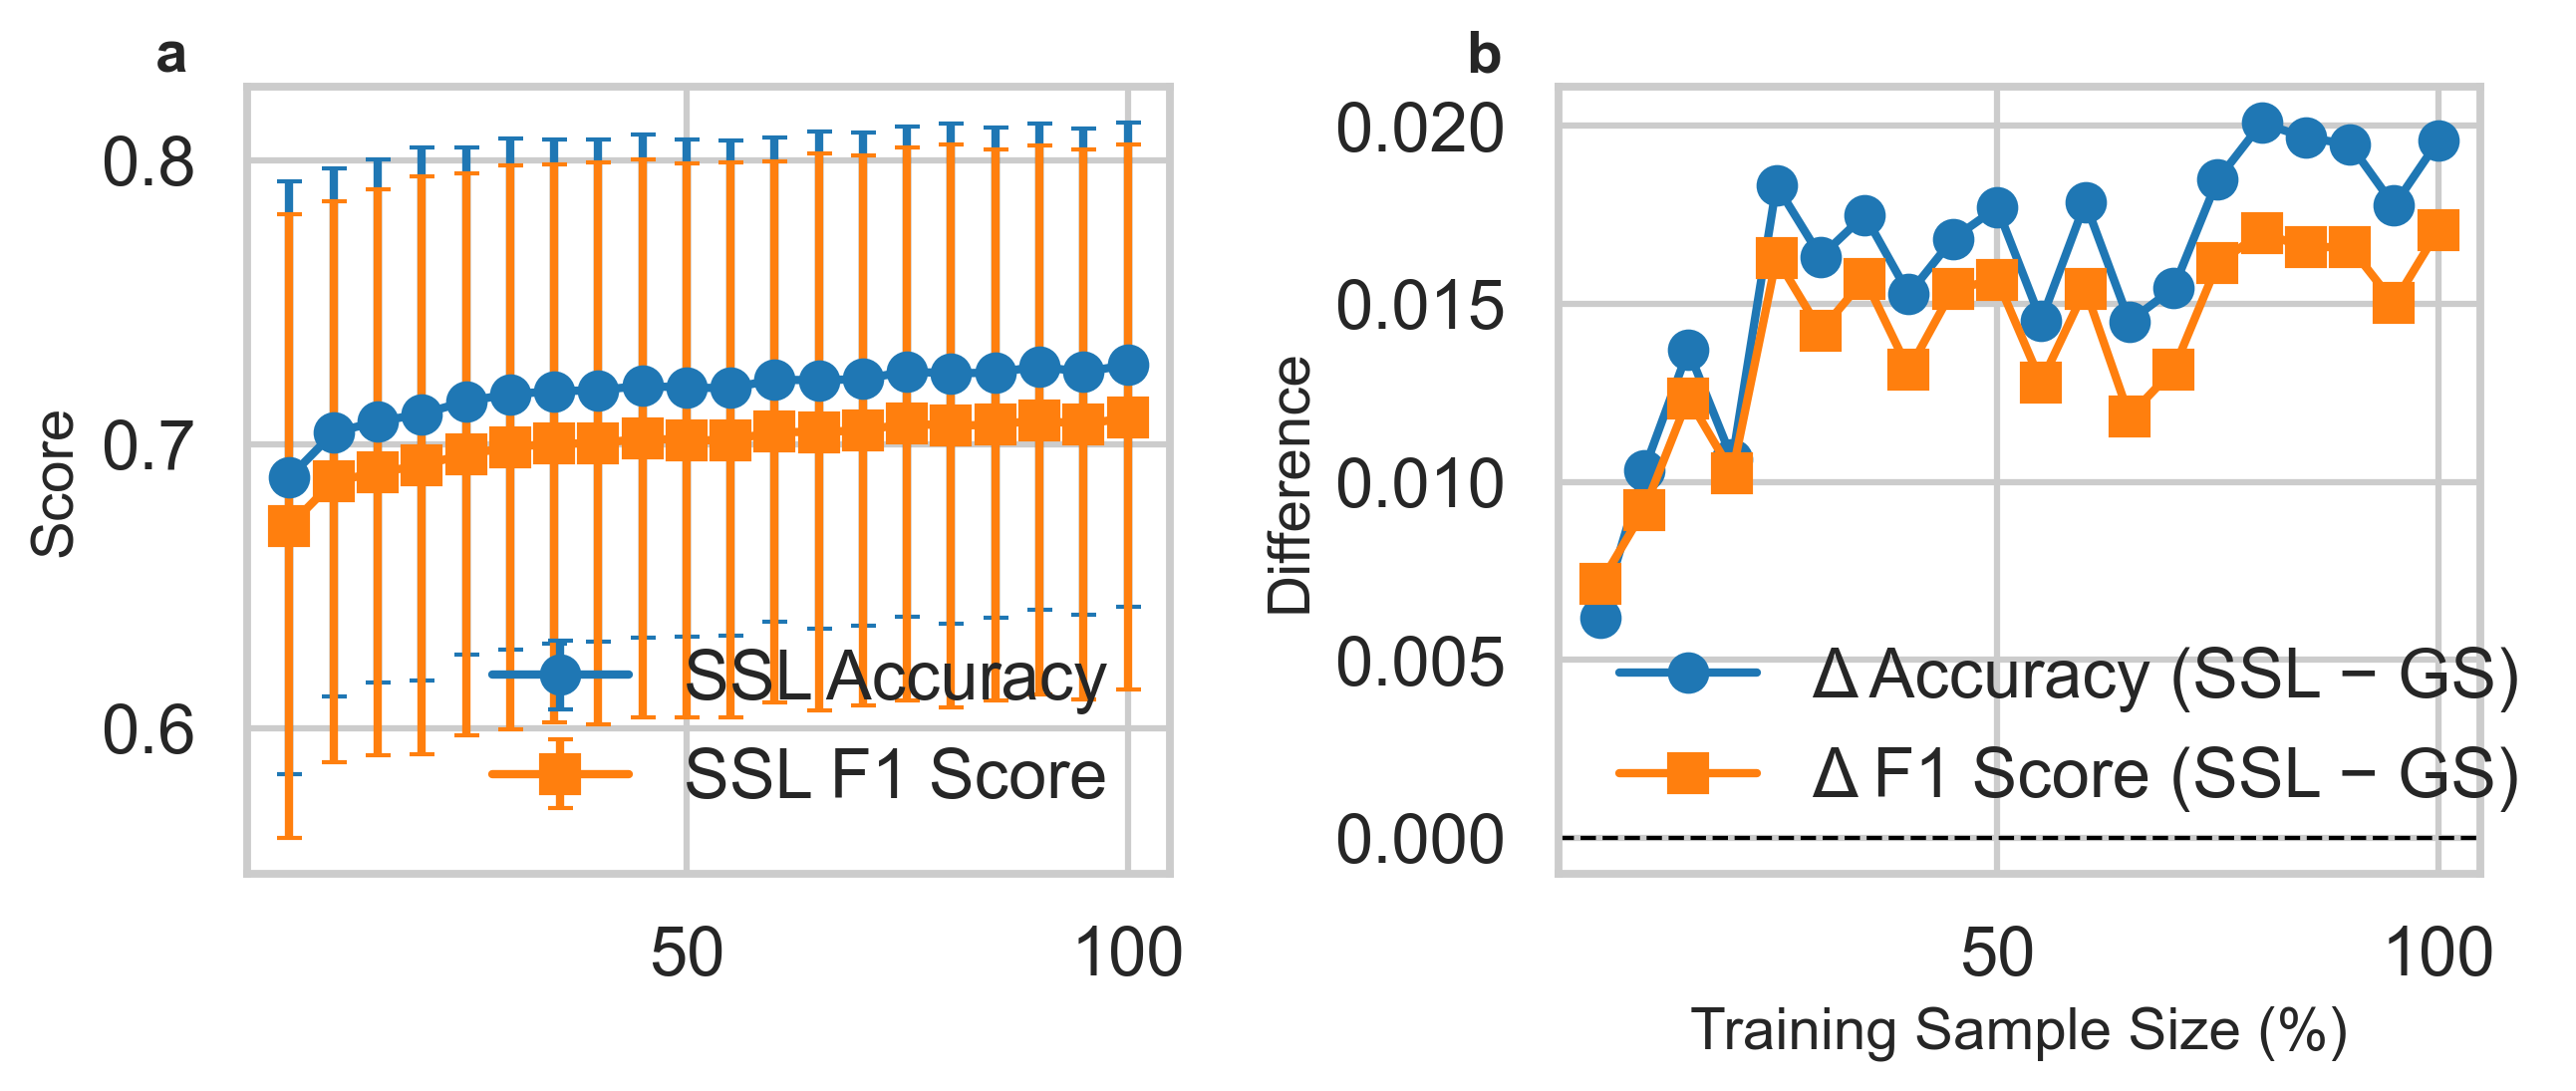

In [23]:
# ======================================================
# Publication-quality plot
# ======================================================
sns.set_context("talk")
sns.set_style("whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(9, 4), sharex=True)

# --- Panel (a): SSL Accuracy and F1 ---
axes[0].errorbar(
    results_df['fraction']*100, results_df['ssl_acc_mean'],
    yerr=results_df['ssl_acc_std'], fmt='-o', capsize=3, lw=2, label="SSL Accuracy"
)
axes[0].errorbar(
    results_df['fraction']*100, results_df['ssl_f1_mean'],
    yerr=results_df['ssl_f1_std'], fmt='-s', capsize=3, lw=2, label="SSL F1 Score"
)
axes[0].set_ylabel("Score", fontsize=14)
axes[0].legend(frameon=False)
axes[0].text(-0.1, 1.02, "a", transform=axes[0].transAxes, fontsize=14, fontweight='bold')

# --- Panel (b): Difference SSL − Gold Standard ---
axes[1].plot(
    results_df['fraction']*100, results_df['acc_diff'],
    marker='o', lw=2, label="Δ Accuracy (SSL − GS)"
)
axes[1].plot(
    results_df['fraction']*100, results_df['f1_diff'],
    marker='s', lw=2, label="Δ F1 Score (SSL − GS)"
)
axes[1].axhline(0, color='black', linestyle='--', lw=1)
axes[1].set_xlabel("Training Sample Size (%)", fontsize=14)
axes[1].set_ylabel("Difference", fontsize=14)
axes[1].legend(frameon=False)
axes[1].text(-0.1, 1.02, "b", transform=axes[1].transAxes, fontsize=14, fontweight='bold')

plt.tight_layout()
# plt.savefig("ssl_vs_gs_f1_accuracy_panels.png", dpi=300, bbox_inches="tight")
plt.show()

### Experiment 1.5: train on 2018 (no change), predict on 2018 (no change)

### Experiment 1.5: train on 2018 (no change), predict on 2018 (no change)

In [14]:
df18subset = gdf18[gdf18['change'] == 0].copy()

In [15]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, classification_report, f1_score
import numpy as np

# Features and target
X = df18subset[wavelength23_cols]
y = df18subset['class'].astype(int)
groups = df18subset['cluster']  # replace with the appropriate grouping column

# Classifier
clf = RandomForestClassifier(random_state=42, n_jobs=-1)

# GroupKFold setup
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

# Store metrics
f1_scores = []
accuracy_scores = []
reports = []

for i, (train_idx, test_idx) in enumerate(gkf.split(X, y, groups)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    accuracy_scores.append(acc)

    # F1
    f1 = f1_score(y_test, y_pred, average='weighted')
    f1_scores.append(f1)
    
    # Report
    report = classification_report(y_test, y_pred, output_dict=True)
    reports.append(report)
    
    print(f"\nFold {i + 1} — Accuracy: {acc:.2f}, F1 Score: {f1:.2f}")
    print(classification_report(y_test, y_pred))

# Summary
print(f"\nAverage Accuracy over {n_splits} folds: {np.mean(accuracy_scores):.2f} ({np.std(accuracy_scores):.2f})")
print(f"Average F1 Score over {n_splits} folds: {np.mean(f1_scores):.2f} ({np.std(f1_scores):.2f})")



Fold 1 — Accuracy: 0.41, F1 Score: 0.41
              precision    recall  f1-score   support

           0       0.67      0.33      0.44        12
           1       0.00      0.00      0.00         0
           2       0.09      0.27      0.14        15
           3       0.32      0.69      0.44        64
           4       0.49      0.53      0.51        58
           5       0.80      0.35      0.49        34
           6       0.76      0.25      0.38        51
           7       0.71      0.41      0.52        37
           8       0.59      0.21      0.31        90
          10       0.35      1.00      0.52         8

    accuracy                           0.41       369
   macro avg       0.48      0.40      0.37       369
weighted avg       0.56      0.41      0.41       369


Fold 2 — Accuracy: 0.55, F1 Score: 0.54
              precision    recall  f1-score   support

           0       0.80      0.87      0.83        23
           1       0.67      0.11      0.18       

In [37]:
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()

# Load data
X, y = df18subset[wavelength23_cols], df18subset['class'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

clf.fit(X_train, y_train)

RandomForestClassifier()

In [38]:
prediction_probabilities = clf.predict_proba(X_test)
prediction_probabilities.shape

# Get the predicted class labels
predicted_labels = clf.predict(X_test)
# Calculate accuracy
accuracy = accuracy_score(y_test, predicted_labels)
print(f"Accuracy: {accuracy:.2f}")

# from .65

Accuracy: 0.63


In [17]:
from tabpfn import TabPFNClassifier
from tabpfn_extensions.many_class import ManyClassClassifier 
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, classification_report, f1_score
import numpy as np

# Features and target
X = gdf18[wavelength23_cols]
y = gdf18['class'].astype(int)
groups = gdf18['cluster']  # replace with the appropriate grouping column

# Classifier
# Create a base TabPFN classifier
base_clf = TabPFNClassifier()

# Initialize a classifier
clf = ManyClassClassifier(
    estimator=base_clf,
    alphabet_size=10  # Use TabPFN's maximum class limit
)

# GroupKFold setup
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

# Store metrics
f1_scores = []
accuracy_scores = []
reports = []

for i, (train_idx, test_idx) in enumerate(gkf.split(X, y, groups)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    accuracy_scores.append(acc)

    # F1
    f1 = f1_score(y_test, y_pred, average='weighted')
    f1_scores.append(f1)
    
    # Report
    report = classification_report(y_test, y_pred, output_dict=True)
    reports.append(report)
    
    print(f"\nFold {i + 1} — Accuracy: {acc:.2f}, F1 Score: {f1:.2f}")
    print(classification_report(y_test, y_pred))

# Summary
print(f"\nAverage Accuracy over {n_splits} folds: {np.mean(accuracy_scores):.2f} ({np.std(accuracy_scores):.2f})")
print(f"Average F1 Score over {n_splits} folds: {np.mean(f1_scores):.2f} ({np.std(f1_scores):.2f})")


  0%|          | 0/16 [00:00<?, ?it/s]

(…)fn-v2-classifier-finetuned-zk73skhh.ckpt:   0%|          | 0.00/29.0M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/37.0 [00:00<?, ?B/s]

100%|██████████| 16/16 [01:18<00:00,  4.89s/it]



Fold 1 — Accuracy: 0.62, F1 Score: 0.63
              precision    recall  f1-score   support

           0       0.90      0.75      0.82        12
           1       0.00      0.00      0.00         0
           2       0.40      0.56      0.47        32
           3       0.53      0.71      0.61        78
           4       0.65      0.71      0.68        65
           5       0.76      0.42      0.54        38
           6       0.83      0.73      0.78        52
           7       0.91      0.54      0.68        37
           8       0.66      0.44      0.53        91
           9       0.64      0.92      0.75        25
          10       0.53      1.00      0.70         8

    accuracy                           0.62       438
   macro avg       0.62      0.62      0.59       438
weighted avg       0.67      0.62      0.63       438



100%|██████████| 16/16 [01:15<00:00,  4.70s/it]



Fold 2 — Accuracy: 0.66, F1 Score: 0.68
              precision    recall  f1-score   support

           0       1.00      0.73      0.85        15
           1       0.00      0.00      0.00         0
           2       0.84      0.81      0.82       124
           3       0.32      0.36      0.34        39
           4       0.90      0.57      0.70        49
           5       0.58      0.63      0.60        46
           6       0.58      0.68      0.62        22
           7       0.64      0.82      0.72        11
           8       0.44      0.52      0.48        50
           9       0.00      0.00      0.00         0
          10       1.00      0.90      0.95        20

    accuracy                           0.66       376
   macro avg       0.57      0.55      0.55       376
weighted avg       0.70      0.66      0.68       376



100%|██████████| 16/16 [01:19<00:00,  4.97s/it]



Fold 3 — Accuracy: 0.66, F1 Score: 0.65
              precision    recall  f1-score   support

           0       0.69      0.87      0.77        23
           1       0.50      0.05      0.10        19
           2       0.60      0.75      0.67        16
           3       0.84      0.73      0.78       102
           4       0.63      0.66      0.65        65
           5       0.42      0.36      0.38        14
           6       0.21      0.29      0.24        14
           7       0.53      0.79      0.63        24
           8       0.42      0.56      0.48         9
           9       0.00      0.00      0.00         0
          10       1.00      0.95      0.98        21

    accuracy                           0.66       307
   macro avg       0.53      0.55      0.52       307
weighted avg       0.68      0.66      0.65       307



100%|██████████| 16/16 [01:19<00:00,  4.95s/it]



Fold 4 — Accuracy: 0.77, F1 Score: 0.78
              precision    recall  f1-score   support

           0       1.00      0.78      0.88         9
           1       0.00      0.00      0.00         0
           2       0.88      0.80      0.83        79
           3       0.81      0.74      0.77        65
           4       0.71      0.74      0.72        39
           5       0.00      0.00      0.00         2
           6       0.70      0.73      0.72        26
           7       0.46      0.55      0.50        11
           8       0.52      0.74      0.61        19
           9       0.86      0.86      0.86        42
          10       0.92      1.00      0.96        12

    accuracy                           0.77       304
   macro avg       0.62      0.63      0.62       304
weighted avg       0.79      0.77      0.78       304



100%|██████████| 16/16 [01:23<00:00,  5.19s/it]


Fold 5 — Accuracy: 0.68, F1 Score: 0.69
              precision    recall  f1-score   support

           0       0.82      0.93      0.88        15
           1       0.80      0.17      0.28        24
           2       0.75      0.53      0.62        17
           3       0.81      0.91      0.86        43
           4       0.54      0.74      0.62        34
           5       0.00      0.00      0.00         3
           6       0.12      0.40      0.18         5
           7       0.62      0.70      0.66        30
           8       0.71      0.61      0.65        28
           9       0.91      0.67      0.77        48
          10       1.00      1.00      1.00        16

    accuracy                           0.68       263
   macro avg       0.64      0.60      0.59       263
weighted avg       0.75      0.68      0.69       263


Average Accuracy over 5 folds: 0.68 (0.05)
Average F1 Score over 5 folds: 0.68 (0.05)


In [39]:
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split

from tabpfn import TabPFNClassifier
from tabpfn_extensions.many_class import ManyClassClassifier

# Create a base TabPFN classifier
base_clf = TabPFNClassifier()

# Load data
X, y = df18subset[wavelength23_cols], df18subset['class'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Initialize a classifier
clf = ManyClassClassifier(
    estimator=base_clf,
    alphabet_size=10  # Use TabPFN's maximum class limit
)
clf.fit(X_train, y_train)

ManyClassClassifier(alphabet_size=10, estimator=TabPFNClassifier())

In [40]:
# Predict probabilities
# prediction_probabilities = clf.predict_proba(X_test)
# print("ROC AUC:", roc_auc_score(y_test, prediction_probabilities[:, 1]))

# Predict labels
predictions = clf.predict(X_test)
print("Accuracy", accuracy_score(y_test, predictions))

# from .785

Accuracy 0.7417503586800573


### Experiment 1.6: train on 2023 (all), predict on 2023 (all)

In [19]:
# use 2018 class for 2023 whereever there is no change
gdf23.loc[gdf23['change'] == 0, '2023_class'] = gdf23['class']
gdf23.dropna(subset=['2023_class'], inplace=True)

In [21]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, classification_report, f1_score
import numpy as np

# Features and target
X, y = gdf23[wavelength23_cols], gdf23['2023_class'].astype(int)
groups = gdf23['cluster']  # replace with the appropriate grouping column

# Classifier
clf = RandomForestClassifier(random_state=42, n_jobs=-1)

# GroupKFold setup
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

# Store metrics
f1_scores = []
accuracy_scores = []
reports = []

for i, (train_idx, test_idx) in enumerate(gkf.split(X, y, groups)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    accuracy_scores.append(acc)

    # F1
    f1 = f1_score(y_test, y_pred, average='weighted')
    f1_scores.append(f1)
    
    # Report
    report = classification_report(y_test, y_pred, output_dict=True)
    reports.append(report)
    
    print(f"\nFold {i + 1} — Accuracy: {acc:.2f}, F1 Score: {f1:.2f}")
    print(classification_report(y_test, y_pred))

# Summary
print(f"\nAverage Accuracy over {n_splits} folds: {np.mean(accuracy_scores):.2f} ({np.std(accuracy_scores):.2f})")
print(f"Average F1 Score over {n_splits} folds: {np.mean(f1_scores):.2f} ({np.std(f1_scores):.2f})")



Fold 1 — Accuracy: 0.50, F1 Score: 0.50
              precision    recall  f1-score   support

           0       0.42      0.64      0.51        25
           1       0.00      0.00      0.00         0
           2       0.10      0.33      0.15        15
           3       0.48      0.61      0.53        64
           4       0.59      0.64      0.61        84
           5       0.76      0.38      0.51        34
           6       0.78      0.35      0.49        51
           7       0.62      0.74      0.67        46
           8       0.57      0.33      0.42        91
          10       0.36      1.00      0.53         8
          12       0.00      0.00      0.00        18

    accuracy                           0.50       436
   macro avg       0.43      0.46      0.40       436
weighted avg       0.55      0.50      0.50       436


Fold 2 — Accuracy: 0.44, F1 Score: 0.44
              precision    recall  f1-score   support

           0       0.50      0.25      0.33       

In [42]:
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()

# Load data
X, y = gdf23[wavelength23_cols], gdf23['2023_class'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

clf.fit(X_train, y_train)

RandomForestClassifier()

In [44]:
prediction_probabilities = clf.predict_proba(X_test)
prediction_probabilities.shape

# Get the predicted class labels
predicted_labels = clf.predict(X_test)
# Calculate accuracy
accuracy = accuracy_score(y_test, predicted_labels)
print(f"Accuracy: {accuracy:.2f}")

# from .54

Accuracy: 0.59


In [22]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, classification_report, f1_score
import numpy as np

# Features and target
X, y = gdf23[wavelength23_cols], gdf23['2023_class'].astype(int)
groups = gdf23['cluster']  # replace with the appropriate grouping column

# Classifier
# Create a base TabPFN classifier
base_clf = TabPFNClassifier()

# Initialize a classifier
clf = ManyClassClassifier(
    estimator=base_clf,
    alphabet_size=10  # Use TabPFN's maximum class limit
)

# GroupKFold setup
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

# Store metrics
f1_scores = []
accuracy_scores = []
reports = []

for i, (train_idx, test_idx) in enumerate(gkf.split(X, y, groups)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    accuracy_scores.append(acc)

    # F1
    f1 = f1_score(y_test, y_pred, average='weighted')
    f1_scores.append(f1)
    
    # Report
    report = classification_report(y_test, y_pred, output_dict=True)
    reports.append(report)
    
    print(f"\nFold {i + 1} — Accuracy: {acc:.2f}, F1 Score: {f1:.2f}")
    print(classification_report(y_test, y_pred))

# Summary
print(f"\nAverage Accuracy over {n_splits} folds: {np.mean(accuracy_scores):.2f} ({np.std(accuracy_scores):.2f})")
print(f"Average F1 Score over {n_splits} folds: {np.mean(f1_scores):.2f} ({np.std(f1_scores):.2f})")


100%|██████████| 16/16 [01:12<00:00,  4.53s/it]



Fold 1 — Accuracy: 0.58, F1 Score: 0.58
              precision    recall  f1-score   support

           0       0.38      0.44      0.41        25
           1       0.00      0.00      0.00         0
           2       0.24      0.53      0.33        15
           3       0.54      0.69      0.60        64
           4       0.60      0.65      0.62        84
           5       0.90      0.56      0.69        34
           6       0.88      0.69      0.77        51
           7       0.64      0.78      0.71        46
           8       0.64      0.41      0.50        91
          10       0.40      1.00      0.57         8
          12       0.00      0.00      0.00        18

    accuracy                           0.58       436
   macro avg       0.47      0.52      0.47       436
weighted avg       0.61      0.58      0.58       436



100%|██████████| 16/16 [01:17<00:00,  4.84s/it]



Fold 2 — Accuracy: 0.53, F1 Score: 0.52
              precision    recall  f1-score   support

           0       0.48      0.19      0.27        52
           1       0.00      0.00      0.00         0
           2       0.66      0.57      0.61        68
           3       0.26      0.52      0.34        31
           4       0.30      0.66      0.41        32
           5       0.65      0.67      0.66        45
           6       0.77      0.91      0.83        22
           7       0.79      0.41      0.54        27
           8       0.64      0.57      0.61        47
          10       0.96      0.89      0.92        27
          12       0.00      0.00      0.00        25

    accuracy                           0.53       376
   macro avg       0.50      0.49      0.47       376
weighted avg       0.56      0.53      0.52       376



100%|██████████| 16/16 [01:21<00:00,  5.07s/it]



Fold 3 — Accuracy: 0.59, F1 Score: 0.59
              precision    recall  f1-score   support

           0       0.33      0.80      0.47        25
           1       0.00      0.00      0.00        19
           2       0.43      0.75      0.55        16
           3       0.89      0.52      0.66       103
           4       0.66      0.55      0.60        60
           5       0.41      0.64      0.50        14
           6       0.60      0.64      0.62        14
           7       0.71      0.83      0.77        24
           8       0.50      0.56      0.53         9
          10       0.91      1.00      0.95        20
          12       0.00      0.00      0.00         3

    accuracy                           0.59       307
   macro avg       0.49      0.57      0.51       307
weighted avg       0.65      0.59      0.59       307



100%|██████████| 16/16 [01:22<00:00,  5.16s/it]



Fold 4 — Accuracy: 0.66, F1 Score: 0.67
              precision    recall  f1-score   support

           0       0.67      0.60      0.63        10
           1       0.00      0.00      0.00         0
           2       0.95      0.55      0.70        69
           3       0.74      0.77      0.76        66
           4       0.64      0.77      0.70        57
           5       0.11      0.50      0.18         2
           6       0.62      0.69      0.65        26
           7       0.75      0.50      0.60        24
           8       0.43      0.67      0.52        27
          10       0.92      1.00      0.96        12
          12       0.17      0.09      0.12        11

    accuracy                           0.66       304
   macro avg       0.54      0.56      0.53       304
weighted avg       0.71      0.66      0.67       304



100%|██████████| 16/16 [01:26<00:00,  5.43s/it]


Fold 5 — Accuracy: 0.54, F1 Score: 0.55
              precision    recall  f1-score   support

           0       0.64      0.56      0.60        16
           1       0.00      0.00      0.00        21
           2       0.50      0.35      0.41        17
           3       0.71      0.27      0.39        44
           4       0.82      0.68      0.74        59
           5       0.03      0.33      0.05         3
           6       0.05      0.20      0.08         5
           7       0.64      0.83      0.72        42
           8       0.53      0.66      0.58        32
          10       0.90      1.00      0.95        18
          12       0.00      0.00      0.00         6

    accuracy                           0.54       263
   macro avg       0.44      0.44      0.41       263
weighted avg       0.60      0.54      0.55       263


Average Accuracy over 5 folds: 0.58 (0.05)
Average F1 Score over 5 folds: 0.58 (0.05)


In [45]:
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split

from tabpfn import TabPFNClassifier
from tabpfn_extensions.many_class import ManyClassClassifier

# Create a base TabPFN classifier
base_clf = TabPFNClassifier()

# Load data
X, y = gdf23[wavelength23_cols], gdf23['2023_class'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Initialize a classifier
clf = ManyClassClassifier(
    estimator=base_clf,
    alphabet_size=10  # Use TabPFN's maximum class limit
)
clf.fit(X_train, y_train)

ManyClassClassifier(alphabet_size=10, estimator=TabPFNClassifier())

In [46]:
# Predict probabilities
# prediction_probabilities = clf.predict_proba(X_test)
# print("ROC AUC:", roc_auc_score(y_test, prediction_probabilities[:, 1]))

# Predict labels
predictions = clf.predict(X_test)
print("Accuracy", accuracy_score(y_test, predictions))

# from .690

100%|██████████| 16/16 [00:04<00:00,  3.91it/s]

Accuracy 0.6761565836298933


### Experiment 2: train on 2023 (no change), predict on 2023 (no change)

In [ ]:
df23subset = gdf23[gdf23['change'] == 0].copy()
# class and 2023_class are the same for no change points

In [ ]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, classification_report, f1_score
import numpy as np

# Features and target
X, y = df23subset[wavelength23_cols], df23subset['class'].astype(int)
groups = df23subset['cluster']  # replace with the appropriate grouping column

# Classifier
clf = RandomForestClassifier(random_state=42, n_jobs=-1)

# GroupKFold setup
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

# Store metrics
f1_scores = []
accuracy_scores = []
reports = []

for i, (train_idx, test_idx) in enumerate(gkf.split(X, y, groups)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    accuracy_scores.append(acc)

    # F1
    f1 = f1_score(y_test, y_pred, average='weighted')
    f1_scores.append(f1)
    
    # Report
    report = classification_report(y_test, y_pred, output_dict=True)
    reports.append(report)
    
    print(f"\nFold {i + 1} — Accuracy: {acc:.2f}, F1 Score: {f1:.2f}")
    print(classification_report(y_test, y_pred))

# Summary
print(f"\nAverage Accuracy over {n_splits} folds: {np.mean(accuracy_scores):.2f} ({np.std(accuracy_scores):.2f})")
print(f"Average F1 Score over {n_splits} folds: {np.mean(f1_scores):.2f} ({np.std(f1_scores):.2f})")



Fold 1 — Accuracy: 0.56, F1 Score: 0.58
              precision    recall  f1-score   support

           0       0.67      0.67      0.67        12
           1       0.00      0.00      0.00         0
           2       0.10      0.33      0.16        15
           3       0.49      0.56      0.52        64
           4       0.60      0.79      0.68        58
           5       0.83      0.44      0.58        34
           6       0.83      0.39      0.53        51
           7       0.91      0.78      0.84        37
           8       0.66      0.43      0.52        90
          10       0.38      1.00      0.55         8

    accuracy                           0.56       369
   macro avg       0.55      0.54      0.51       369
weighted avg       0.66      0.56      0.58       369


Fold 2 — Accuracy: 0.57, F1 Score: 0.58
              precision    recall  f1-score   support

           0       0.76      0.57      0.65        23
           1       0.11      0.05      0.07       

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()

# Load data
X, y = df23subset[wavelength23_cols], df23subset['class'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

clf.fit(X_train, y_train)

RandomForestClassifier()

In [32]:
prediction_probabilities = clf.predict_proba(X_test)
prediction_probabilities.shape

# Get the predicted class labels
predicted_labels = clf.predict(X_test)
# Calculate accuracy
accuracy = accuracy_score(y_test, predicted_labels)
print(f"Accuracy: {accuracy:.2f}")

# from .60

Accuracy: 0.63


In [ ]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, classification_report, f1_score
import numpy as np

# Features and target
X, y = df23subset[wavelength23_cols], df23subset['class'].astype(int)
groups = df23subset['cluster']  # replace with the appropriate grouping column

# Classifier
# Create a base TabPFN classifier
base_clf = TabPFNClassifier()

# Initialize a classifier
clf = ManyClassClassifier(
    estimator=base_clf,
    alphabet_size=10  # Use TabPFN's maximum class limit
)

# GroupKFold setup
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

# Store metrics
f1_scores = []
accuracy_scores = []
reports = []

for i, (train_idx, test_idx) in enumerate(gkf.split(X, y, groups)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    accuracy_scores.append(acc)

    # F1
    f1 = f1_score(y_test, y_pred, average='weighted')
    f1_scores.append(f1)
    
    # Report
    report = classification_report(y_test, y_pred, output_dict=True)
    reports.append(report)
    
    print(f"\nFold {i + 1} — Accuracy: {acc:.2f}, F1 Score: {f1:.2f}")
    print(classification_report(y_test, y_pred))

# Summary
print(f"\nAverage Accuracy over {n_splits} folds: {np.mean(accuracy_scores):.2f} ({np.std(accuracy_scores):.2f})")
print(f"Average F1 Score over {n_splits} folds: {np.mean(f1_scores):.2f} ({np.std(f1_scores):.2f})")



Fold 1 — Accuracy: 0.60, F1 Score: 0.61
              precision    recall  f1-score   support

           0       0.70      0.58      0.64        12
           1       0.00      0.00      0.00         0
           2       0.21      0.60      0.32        15
           3       0.54      0.67      0.60        64
           4       0.60      0.69      0.64        58
           5       0.89      0.47      0.62        34
           6       0.89      0.65      0.75        51
           7       0.72      0.78      0.75        37
           8       0.70      0.41      0.52        90
          10       0.42      1.00      0.59         8

    accuracy                           0.60       369
   macro avg       0.57      0.59      0.54       369
weighted avg       0.68      0.60      0.61       369


Fold 2 — Accuracy: 0.68, F1 Score: 0.68
              precision    recall  f1-score   support

           0       0.78      0.61      0.68        23
           1       0.00      0.00      0.00       

In [51]:
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split

from tabpfn import TabPFNClassifier
from tabpfn_extensions.many_class import ManyClassClassifier

# Create a base TabPFN classifier
base_clf = TabPFNClassifier()

# Load data
X, y = df23subset[wavelength23_cols], df23subset['class'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Initialize a classifier
clf = ManyClassClassifier(
    estimator=base_clf,
    alphabet_size=10  # Use TabPFN's maximum class limit
)
clf.fit(X_train, y_train)

ManyClassClassifier(alphabet_size=10, estimator=TabPFNClassifier())

In [52]:
# Predict probabilities
# prediction_probabilities = clf.predict_proba(X_test)
# print("ROC AUC:", roc_auc_score(y_test, prediction_probabilities[:, 1]))

# Predict labels
predictions = clf.predict(X_test)
print("Accuracy", accuracy_score(y_test, predictions))

# from .760

Accuracy 0.7546628407460545


### Experiment 3: train on 2018 (2018), predict on 2023 (no change)

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, classification_report, f1_score
import pandas as pd
import numpy as np

# Add source labels
gdf18['source'] = '2018'
df23subset['source'] = '2023'

# Combine for consistent group splitting
combined = pd.concat([gdf18, df23subset], ignore_index=True)
X_all = combined[wavelength23_cols]
y_all = combined['class'].astype(int)
groups_all = combined['cluster']

# Track source to separate later
sources = combined['source']

# GroupKFold
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

# Classifier
clf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Metrics
f1_scores = []
accuracy_scores = []

for i, (train_idx, test_idx) in enumerate(gkf.split(X_all, y_all, groups_all)):
    # Get train/test data
    train_data = combined.iloc[train_idx]
    test_data = combined.iloc[test_idx]

    # subset 2018 train data to only include 2018 data
    train_data = train_data.loc[train_data['source'] == '2018']

    # subset 2023 test data to only include 2023 data
    test_data = test_data.loc[test_data['source'] == '2023']
    
    # Ensure all test groups come from df23subset only
    if not all(test_data['source'] == '2023'):
        raise ValueError("Test set contains data from 2018, which is not allowed.")

    X_train = train_data[wavelength23_cols]
    y_train = train_data['class'].astype(int)
    X_test = test_data[wavelength23_cols]
    y_test = test_data['class'].astype(int)

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    accuracy_scores.append(acc)
    f1_scores.append(f1)

    print(f"\nFold {i+1} — Accuracy: {acc:.2f}, F1 Score: {f1:.2f}")
    print(classification_report(y_test, y_pred))

# Summary
print(f"\nAverage Accuracy (only folds using 2023 test data): {np.mean(accuracy_scores):.2f} ({np.std(accuracy_scores):.2f})")
print(f"Average F1 Score: {np.mean(f1_scores):.2f} ({np.std(f1_scores):.2f})")



Fold 1 — Accuracy: 0.50, F1 Score: 0.50
              precision    recall  f1-score   support

           0       0.73      0.67      0.70        12
           1       0.00      0.00      0.00         0
           2       0.43      0.20      0.27        15
           3       0.46      0.70      0.56        64
           4       0.49      0.72      0.59        58
           5       0.78      0.21      0.33        34
           6       0.63      0.24      0.34        51
           7       1.00      0.41      0.58        37
           8       0.55      0.48      0.51        90
          10       0.67      1.00      0.80         8

    accuracy                           0.50       369
   macro avg       0.57      0.46      0.47       369
weighted avg       0.61      0.50      0.50       369


Fold 2 — Accuracy: 0.45, F1 Score: 0.45
              precision    recall  f1-score   support

           0       0.50      0.20      0.29         5
           1       0.00      0.00      0.00       

In [53]:
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()

# Load data
X, y = gdf18[wavelength23_cols], gdf18['class'].astype(int)

clf.fit(X, y)

RandomForestClassifier()

In [54]:
prediction_probabilities = clf.predict_proba(df23subset[wavelength23_cols])
prediction_probabilities.shape

# Get the predicted class labels
predicted_labels = clf.predict(df23subset[wavelength23_cols])
# Calculate accuracy
accuracy = accuracy_score(df23subset['class'], predicted_labels)
print(f"Accuracy: {accuracy:.2f}")

# from .05

Accuracy: 0.54


In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, classification_report, f1_score
import pandas as pd
import numpy as np

# Add source labels
gdf18['source'] = '2018'
df23subset['source'] = '2023'

# Combine for consistent group splitting
combined = pd.concat([gdf18, df23subset], ignore_index=True)
X_all = combined[wavelength23_cols]
y_all = combined['class'].astype(int)
groups_all = combined['cluster']

# Track source to separate later
sources = combined['source']

# GroupKFold
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

# Classifier
# Create a base TabPFN classifier
base_clf = TabPFNClassifier()

# Initialize a classifier
clf = ManyClassClassifier(
    estimator=base_clf,
    alphabet_size=10  # Use TabPFN's maximum class limit
)

# Metrics
f1_scores = []
accuracy_scores = []

for i, (train_idx, test_idx) in enumerate(gkf.split(X_all, y_all, groups_all)):
    # Get train/test data
    train_data = combined.iloc[train_idx]
    test_data = combined.iloc[test_idx]

    # subset 2018 train data to only include 2018 data
    train_data = train_data.loc[train_data['source'] == '2018']

    # subset 2023 test data to only include 2023 data
    test_data = test_data.loc[test_data['source'] == '2023']
    
    # Ensure all test groups come from df23subset only
    if not all(test_data['source'] == '2023'):
        raise ValueError("Test set contains data from 2018, which is not allowed.")

    X_train = train_data[wavelength23_cols]
    y_train = train_data['class'].astype(int)
    X_test = test_data[wavelength23_cols]
    y_test = test_data['class'].astype(int)

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    accuracy_scores.append(acc)
    f1_scores.append(f1)

    print(f"\nFold {i+1} — Accuracy: {acc:.2f}, F1 Score: {f1:.2f}")
    print(classification_report(y_test, y_pred))

# Summary
print(f"\nAverage Accuracy (only folds using 2023 test data): {np.mean(accuracy_scores):.2f} ({np.std(accuracy_scores):.2f})")
print(f"Average F1 Score: {np.mean(f1_scores):.2f} ({np.std(f1_scores):.2f})")


100%|██████████| 16/16 [01:08<00:00,  4.28s/it]



Fold 1 — Accuracy: 0.50, F1 Score: 0.50
              precision    recall  f1-score   support

           0       0.67      0.67      0.67        12
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00        15
           3       0.46      0.41      0.43        64
           4       0.51      0.52      0.51        58
           5       0.50      0.09      0.15        34
           6       0.70      0.61      0.65        51
           7       0.95      0.57      0.71        37
           8       0.46      0.63      0.54        90
           9       0.00      0.00      0.00         0
          10       0.80      1.00      0.89         8

    accuracy                           0.50       369
   macro avg       0.46      0.41      0.41       369
weighted avg       0.55      0.50      0.50       369



100%|██████████| 16/16 [01:10<00:00,  4.44s/it]



Fold 2 — Accuracy: 0.51, F1 Score: 0.50
              precision    recall  f1-score   support

           0       0.50      0.60      0.55         5
           1       0.00      0.00      0.00         0
           2       1.00      0.16      0.28        68
           3       0.29      0.65      0.40        31
           4       0.50      0.16      0.24        32
           5       0.51      0.58      0.54        45
           6       0.70      0.64      0.67        22
           7       0.82      0.82      0.82        11
           8       0.57      0.85      0.68        47
          10       1.00      0.79      0.88        19

    accuracy                           0.51       280
   macro avg       0.59      0.52      0.51       280
weighted avg       0.67      0.51      0.50       280



100%|██████████| 16/16 [01:18<00:00,  4.92s/it]



Fold 3 — Accuracy: 0.48, F1 Score: 0.50
              precision    recall  f1-score   support

           0       0.27      0.91      0.42        23
           1       0.52      0.79      0.62        19
           2       0.75      0.19      0.30        16
           3       0.82      0.40      0.54        99
           4       0.75      0.25      0.38        60
           5       0.41      0.50      0.45        14
           6       0.20      0.21      0.21        14
           7       0.79      0.62      0.70        24
           8       0.10      0.56      0.18         9
          10       1.00      1.00      1.00        20

    accuracy                           0.48       298
   macro avg       0.56      0.54      0.48       298
weighted avg       0.68      0.48      0.50       298



100%|██████████| 16/16 [01:15<00:00,  4.73s/it]



Fold 4 — Accuracy: 0.54, F1 Score: 0.51
              precision    recall  f1-score   support

           0       0.56      0.71      0.62         7
           1       0.00      0.00      0.00         0
           2       1.00      0.06      0.11        69
           3       0.66      0.85      0.74        61
           4       0.84      0.57      0.68        37
           5       0.00      0.00      0.00         2
           6       0.41      0.46      0.44        26
           7       0.77      0.91      0.83        11
           8       0.32      0.84      0.46        19
          10       1.00      1.00      1.00        12

    accuracy                           0.54       244
   macro avg       0.56      0.54      0.49       244
weighted avg       0.74      0.54      0.51       244



100%|██████████| 16/16 [01:31<00:00,  5.69s/it]


Fold 5 — Accuracy: 0.52, F1 Score: 0.50
              precision    recall  f1-score   support

           0       0.67      0.77      0.71        13
           1       0.00      0.00      0.00        21
           2       1.00      0.06      0.11        17
           3       0.53      0.49      0.51        39
           4       0.71      0.32      0.44        31
           5       0.30      1.00      0.46         3
           6       0.11      0.60      0.18         5
           7       0.83      0.83      0.83        30
           8       0.38      0.68      0.49        28
          10       0.89      1.00      0.94        16

    accuracy                           0.52       203
   macro avg       0.54      0.57      0.47       203
weighted avg       0.59      0.52      0.50       203


Average Accuracy (only folds using 2023 test data): 0.51 (0.02)
Average F1 Score: 0.50 (0.00)


In [55]:
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split

from tabpfn import TabPFNClassifier
from tabpfn_extensions.many_class import ManyClassClassifier

# Create a base TabPFN classifier
base_clf = TabPFNClassifier()

# Load data
X, y = gdf18[wavelength23_cols], gdf18['class'].astype(int)

# Initialize a classifier
clf = ManyClassClassifier(
    estimator=base_clf,
    alphabet_size=10  # Use TabPFN's maximum class limit
)
clf.fit(X, y)

ManyClassClassifier(alphabet_size=10, estimator=TabPFNClassifier())

In [56]:
# Predict probabilities
# prediction_probabilities = clf.predict_proba(X_test)
# print("ROC AUC:", roc_auc_score(y_test, prediction_probabilities[:, 1]))

# Predict labels
predictions = clf.predict(df23subset[wavelength23_cols])
print("Accuracy", accuracy_score(df23subset['class'], predictions))

# from 0.08

100%|██████████| 16/16 [00:06<00:00,  2.52it/s]

Accuracy 0.5767575322812052


### Experiment 4: train on 2018 (all) and 2023 (no change), predict on 2018 and 2023 (no change)

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, classification_report, f1_score
import pandas as pd
import numpy as np

# Add source labels
gdf18['source'] = '2018'
df23subset['source'] = '2023'

# Combine for consistent group splitting
combined = pd.concat([gdf18, df23subset], ignore_index=True)
X_all = combined[wavelength23_cols]
y_all = combined['class'].astype(int)
groups_all = combined['cluster']

# Track source to separate later
sources = combined['source']

# GroupKFold
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

# Classifier
clf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Metrics
f1_scores = []
accuracy_scores = []

for i, (train_idx, test_idx) in enumerate(gkf.split(X_all, y_all, groups_all)):
    # Get train/test data
    train_data = combined.iloc[train_idx]
    test_data = combined.iloc[test_idx]

    X_train = train_data[wavelength23_cols]
    y_train = train_data['class'].astype(int)
    X_test = test_data[wavelength23_cols]
    y_test = test_data['class'].astype(int)

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    accuracy_scores.append(acc)
    f1_scores.append(f1)

    print(f"\nFold {i+1} — Accuracy: {acc:.2f}, F1 Score: {f1:.2f}")
    print(classification_report(y_test, y_pred))

# Summary
print(f"\nAverage Accuracy (only folds using 2023 test data): {np.mean(accuracy_scores):.2f} ({np.std(accuracy_scores):.2f})")
print(f"Average F1 Score: {np.mean(f1_scores):.2f} ({np.std(f1_scores):.2f})")



Fold 1 — Accuracy: 0.50, F1 Score: 0.50
              precision    recall  f1-score   support

           0       0.46      0.46      0.46        24
           1       0.00      0.00      0.00         0
           2       0.23      0.49      0.31        47
           3       0.42      0.68      0.52       142
           4       0.54      0.71      0.61       123
           5       0.77      0.28      0.41        72
           6       0.80      0.39      0.52       103
           7       0.75      0.54      0.63        74
           8       0.64      0.29      0.40       181
           9       0.58      0.76      0.66        25
          10       0.48      1.00      0.65        16

    accuracy                           0.50       807
   macro avg       0.52      0.51      0.47       807
weighted avg       0.59      0.50      0.50       807


Fold 2 — Accuracy: 0.52, F1 Score: 0.54
              precision    recall  f1-score   support

           0       0.73      0.40      0.52       

In [40]:
df1823 = pd.concat([gdf18[['class']+wavelength23_cols], df23subset[['class']+wavelength23_cols]], ignore_index=True)
df1823

n18 = len(gdf18)
n23 = len(df23subset)


In [61]:
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()

# Load data
X, y = df1823[wavelength23_cols], df1823['class'].astype(int)
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, y, df1823.index, test_size=0.5, random_state=42)

clf.fit(X_train, y_train)

RandomForestClassifier()

In [62]:
train_from_18 = (idx_train < n18).sum()
train_from_23 = (idx_train >= n18).sum()
test_from_18 = (idx_test < n18).sum()
test_from_23 = (idx_test >= n18).sum()

train_total = len(idx_train)
test_total = len(idx_test)

print("Train proportions:")
print(f"df18: {train_from_18 / train_total:.2f}, df23: {train_from_23 / train_total:.2f}")

print("Test proportions:")
print(f"df18: {test_from_18 / test_total:.2f}, df23: {test_from_23 / test_total:.2f}")


Train proportions:
df18: 0.55, df23: 0.45
Test proportions:
df18: 0.55, df23: 0.45


In [63]:
prediction_probabilities = clf.predict_proba(X_test)
prediction_probabilities.shape

# Get the predicted class labels
predicted_labels = clf.predict(X_test)
# Calculate accuracy
accuracy = accuracy_score(y_test, predicted_labels)
print(f"Accuracy: {accuracy:.2f}")

# from .62

Accuracy: 0.65


In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, classification_report, f1_score
import pandas as pd
import numpy as np

# Add source labels
gdf18['source'] = '2018'
df23subset['source'] = '2023'

# Combine for consistent group splitting
combined = pd.concat([gdf18, df23subset], ignore_index=True)
X_all = combined[wavelength23_cols]
y_all = combined['class'].astype(int)
groups_all = combined['cluster']

# Track source to separate later
sources = combined['source']

# GroupKFold
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

# Classifier
# Create a base TabPFN classifier
base_clf = TabPFNClassifier()

# Initialize a classifier
clf = ManyClassClassifier(
    estimator=base_clf,
    alphabet_size=10  # Use TabPFN's maximum class limit
)

# Metrics
f1_scores = []
accuracy_scores = []

for i, (train_idx, test_idx) in enumerate(gkf.split(X_all, y_all, groups_all)):
    # Get train/test data
    train_data = combined.iloc[train_idx]
    test_data = combined.iloc[test_idx]

    X_train = train_data[wavelength23_cols]
    y_train = train_data['class'].astype(int)
    X_test = test_data[wavelength23_cols]
    y_test = test_data['class'].astype(int)

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    accuracy_scores.append(acc)
    f1_scores.append(f1)

    print(f"\nFold {i+1} — Accuracy: {acc:.2f}, F1 Score: {f1:.2f}")
    print(classification_report(y_test, y_pred))

# Summary
print(f"\nAverage Accuracy (only folds using 2023 test data): {np.mean(accuracy_scores):.2f} ({np.std(accuracy_scores):.2f})")
print(f"Average F1 Score: {np.mean(f1_scores):.2f} ({np.std(f1_scores):.2f})")


100%|██████████| 16/16 [02:41<00:00, 10.11s/it]



Fold 1 — Accuracy: 0.64, F1 Score: 0.65
              precision    recall  f1-score   support

           0       0.74      0.58      0.65        24
           1       0.00      0.00      0.00         0
           2       0.34      0.66      0.45        47
           3       0.56      0.70      0.62       142
           4       0.66      0.70      0.68       123
           5       0.80      0.44      0.57        72
           6       0.87      0.70      0.77       103
           7       0.86      0.76      0.81        74
           8       0.73      0.50      0.59       181
           9       0.63      0.88      0.73        25
          10       0.59      1.00      0.74        16

    accuracy                           0.64       807
   macro avg       0.61      0.63      0.60       807
weighted avg       0.70      0.64      0.65       807



100%|██████████| 16/16 [02:52<00:00, 10.79s/it]



Fold 2 — Accuracy: 0.66, F1 Score: 0.68
              precision    recall  f1-score   support

           0       0.93      0.65      0.76        20
           1       0.00      0.00      0.00         0
           2       0.87      0.64      0.74       192
           3       0.34      0.40      0.37        70
           4       0.69      0.62      0.65        81
           5       0.65      0.69      0.67        91
           6       0.64      0.82      0.72        44
           7       0.81      0.95      0.88        22
           8       0.55      0.65      0.60        97
           9       0.00      0.00      0.00         0
          10       1.00      0.95      0.97        39

    accuracy                           0.66       656
   macro avg       0.59      0.58      0.58       656
weighted avg       0.71      0.66      0.68       656



100%|██████████| 16/16 [02:57<00:00, 11.10s/it]



Fold 3 — Accuracy: 0.69, F1 Score: 0.68
              precision    recall  f1-score   support

           0       0.75      0.72      0.73        46
           1       0.20      0.05      0.08        38
           2       0.42      0.78      0.55        32
           3       0.88      0.68      0.77       201
           4       0.68      0.80      0.73       125
           5       0.47      0.64      0.55        28
           6       0.43      0.54      0.48        28
           7       0.65      0.77      0.70        48
           8       0.59      0.56      0.57        18
           9       0.00      0.00      0.00         0
          10       1.00      0.98      0.99        41

    accuracy                           0.69       605
   macro avg       0.55      0.59      0.56       605
weighted avg       0.70      0.69      0.68       605



100%|██████████| 16/16 [03:02<00:00, 11.38s/it]



Fold 4 — Accuracy: 0.74, F1 Score: 0.75
              precision    recall  f1-score   support

           0       0.92      0.69      0.79        16
           1       0.00      0.00      0.00         0
           2       0.88      0.64      0.74       148
           3       0.81      0.77      0.79       126
           4       0.75      0.79      0.77        76
           5       0.09      0.25      0.13         4
           6       0.60      0.62      0.61        52
           7       0.64      0.82      0.72        22
           8       0.48      0.82      0.60        38
           9       0.90      0.88      0.89        42
          10       0.96      1.00      0.98        24

    accuracy                           0.74       548
   macro avg       0.64      0.66      0.64       548
weighted avg       0.78      0.74      0.75       548



100%|██████████| 16/16 [03:05<00:00, 11.57s/it]


Fold 5 — Accuracy: 0.64, F1 Score: 0.64
              precision    recall  f1-score   support

           0       0.82      0.82      0.82        28
           1       0.60      0.07      0.12        45
           2       0.68      0.50      0.58        34
           3       0.80      0.72      0.76        82
           4       0.62      0.69      0.66        65
           5       0.10      0.50      0.17         6
           6       0.15      0.50      0.23        10
           7       0.70      0.75      0.73        60
           8       0.55      0.61      0.58        56
           9       0.87      0.69      0.77        48
          10       0.94      1.00      0.97        32

    accuracy                           0.64       466
   macro avg       0.62      0.62      0.58       466
weighted avg       0.70      0.64      0.64       466


Average Accuracy (only folds using 2023 test data): 0.68 (0.04)
Average F1 Score: 0.68 (0.04)


In [64]:
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split

from tabpfn import TabPFNClassifier
from tabpfn_extensions.many_class import ManyClassClassifier

# Create a base TabPFN classifier
base_clf = TabPFNClassifier()

# Load data
X, y = df1823[wavelength23_cols], df1823['class'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Initialize a classifier
clf = ManyClassClassifier(
    estimator=base_clf,
    alphabet_size=10  # Use TabPFN's maximum class limit
)
clf.fit(X_train, y_train)

ManyClassClassifier(alphabet_size=10, estimator=TabPFNClassifier())

In [65]:
# Predict probabilities
# prediction_probabilities = clf.predict_proba(X_test)
# print("ROC AUC:", roc_auc_score(y_test, prediction_probabilities[:, 1]))

# Predict labels
predictions = clf.predict(X_test)
print("Accuracy", accuracy_score(y_test, predictions))

# from .767

100%|██████████| 16/16 [00:05<00:00,  2.71it/s]

Accuracy 0.7709279688513953


### Experiment 5: train on 2018 (all) and 2023 (no change), predict on 2023 (change). Then train on all 2018 and 2023 and predict on 2023 (all)


In [50]:
# with spatial CV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, classification_report, f1_score
import pandas as pd
import numpy as np

# Add source labels
gdf18['source'] = '2018'
df23subset['source'] = '2023'

# Combine for consistent group splitting
combined = pd.concat([gdf18, df23subset], ignore_index=True)
X_all = combined[wavelength23_cols]
y_all = combined['class'].astype(int)
groups_all = combined['cluster']

# Track source to separate later
sources = combined['source']

# GroupKFold
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

# Classifier
clf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Metrics
f1_scores = []
accuracy_scores = []

# Collect all 2023 change subset predictions
df23_all_preds = []

for i, (train_idx, test_idx) in enumerate(gkf.split(X_all, y_all, groups_all)):
    # Get train/test data
    train_data = combined.iloc[train_idx]
    test_data = combined.iloc[test_idx]

    X_train = train_data[wavelength23_cols]
    y_train = train_data['class'].astype(int)
    X_test = test_data[wavelength23_cols]
    y_test = test_data['class'].astype(int)
    print(i , groups_all.iloc[test_idx].unique())

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    accuracy_scores.append(acc)
    f1_scores.append(f1)

    print(f"\nFold {i+1} — Accuracy: {acc:.2f}, F1 Score: {f1:.2f}")
    print(classification_report(y_test, y_pred))

    # Get pseudo labels for 2023 change points
    df23changesubset = gdf23[(gdf23['change'] == 1) & (gdf23['cluster']==groups_all.iloc[test_idx].unique()[0])].copy()
    X = df23changesubset[wavelength23_cols]
    predicted_labels = clf.predict(X)
    df23changesubset['predicted_class'] = predicted_labels
    df23_all_preds.append(df23changesubset)
    print(df23changesubset['predicted_class'].value_counts())

df23_all_preds = pd.concat(df23_all_preds, ignore_index=False)

# Summary
print(f"\nAverage Accuracy (only folds using 2023 test data): {np.mean(accuracy_scores):.2f} ({np.std(accuracy_scores):.2f})")
print(f"Average F1 Score: {np.mean(f1_scores):.2f} ({np.std(f1_scores):.2f})")


0 [3]

Fold 1 — Accuracy: 0.50, F1 Score: 0.50
              precision    recall  f1-score   support

           0       0.46      0.46      0.46        24
           1       0.00      0.00      0.00         0
           2       0.23      0.49      0.31        47
           3       0.42      0.68      0.52       142
           4       0.54      0.71      0.61       123
           5       0.77      0.28      0.41        72
           6       0.80      0.39      0.52       103
           7       0.75      0.54      0.63        74
           8       0.64      0.29      0.40       181
           9       0.58      0.76      0.66        25
          10       0.48      1.00      0.65        16

    accuracy                           0.50       807
   macro avg       0.52      0.51      0.47       807
weighted avg       0.59      0.50      0.50       807

predicted_class
4    37
8     8
3     8
7     6
0     4
1     2
5     1
9     1
Name: count, dtype: int64
1 [0]

Fold 2 — Accuracy: 0.52, F1

In [55]:
df23changesubset['class'] = df23changesubset['predicted_class'].astype(int)
dfallsemisuperivised = pd.concat([gdf18[['class', 'cluster']+wavelength23_cols], df23subset[['class', 'cluster']+wavelength23_cols], df23changesubset[['class', 'cluster']+wavelength23_cols]], ignore_index=True)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, classification_report, f1_score
import pandas as pd
import numpy as np

# Combine for consistent group splitting
X_all = dfallsemisuperivised[wavelength23_cols]
y_all = dfallsemisuperivised['class'].astype(int)
groups_all = dfallsemisuperivised['cluster']

# GroupKFold
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

# Classifier
clf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Metrics
f1_scores = []
accuracy_scores = []

for i, (train_idx, test_idx) in enumerate(gkf.split(X_all, y_all, groups_all)):
    # Get train/test data
    train_data = dfallsemisuperivised.iloc[train_idx]
    test_data = dfallsemisuperivised.iloc[test_idx]

    X_train = train_data[wavelength23_cols]
    y_train = train_data['class'].astype(int)
    X_test = test_data[wavelength23_cols]
    y_test = test_data['class'].astype(int)

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    accuracy_scores.append(acc)
    f1_scores.append(f1)

    print(f"\nFold {i+1} — Accuracy: {acc:.2f}, F1 Score: {f1:.2f}")
    print(classification_report(y_test, y_pred))

# Summary
print(f"\nAverage Accuracy: {np.mean(accuracy_scores):.2f} ({np.std(accuracy_scores):.2f})")
print(f"Average F1 Score: {np.mean(f1_scores):.2f} ({np.std(f1_scores):.2f})")



Fold 1 — Accuracy: 0.51, F1 Score: 0.52
              precision    recall  f1-score   support

           0       0.48      0.46      0.47        24
           1       0.00      0.00      0.00         0
           2       0.23      0.47      0.31        47
           3       0.42      0.69      0.52       142
           4       0.54      0.72      0.62       123
           5       0.78      0.35      0.48        72
           6       0.81      0.41      0.54       103
           7       0.73      0.50      0.59        74
           8       0.70      0.31      0.44       181
           9       0.59      0.76      0.67        25
          10       0.50      1.00      0.67        16

    accuracy                           0.51       807
   macro avg       0.53      0.51      0.48       807
weighted avg       0.61      0.51      0.52       807


Fold 2 — Accuracy: 0.51, F1 Score: 0.53
              precision    recall  f1-score   support

           0       0.90      0.45      0.60       

In [45]:
# get pseudo-labels for 2023 change class

df23changesubset = gdf23[gdf23['change'] == 1].copy()
X = df23changesubset[wavelength23_cols]
predicted_labels = clf.predict(X)
df23changesubset['predicted_class'] = predicted_labels

# Ensure the 'class' column is of compatible type (e.g., int)
df23changesubset['class'] = df23changesubset['class'].astype(int)

# Compare predicted and labels before change (lower agreement is better)
matches = df23changesubset['predicted_class'] == df23changesubset['class']

# Compute proportion (i.e., accuracy)
proportion = matches.mean()

print(f"Proportion of matches: {proportion:.2f}")

Proportion of matches: 0.17


In [ ]:
# without spatial CV
df1823 = pd.concat([gdf18[['class']+wavelength23_cols], df23subset[['class']+wavelength23_cols]], ignore_index=True)
df1823

n18 = len(gdf18)
n23 = len(df23subset)


In [67]:
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()

# Load data
X, y = df1823[wavelength23_cols], df1823['class'].astype(int)
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, y, df1823.index, test_size=0.5, random_state=42)

clf.fit(X_train, y_train)

RandomForestClassifier()

In [68]:
train_from_18 = (idx_train < n18).sum()
train_from_23 = (idx_train >= n18).sum()
test_from_18 = (idx_test < n18).sum()
test_from_23 = (idx_test >= n18).sum()

train_total = len(idx_train)
test_total = len(idx_test)

print("Train proportions:")
print(f"df18: {train_from_18 / train_total:.2f}, df23: {train_from_23 / train_total:.2f}")

print("Test proportions:")
print(f"df18: {test_from_18 / test_total:.2f}, df23: {test_from_23 / test_total:.2f}")


Train proportions:
df18: 0.55, df23: 0.45
Test proportions:
df18: 0.55, df23: 0.45


In [69]:
prediction_probabilities = clf.predict_proba(X_test)
prediction_probabilities.shape

# Get the predicted class labels
predicted_labels = clf.predict(X_test)
# Calculate accuracy
accuracy = accuracy_score(y_test, predicted_labels)
print(f"Accuracy: {accuracy:.2f}")

# from .63

Accuracy: 0.65


In [70]:
# get pseudo-labels for 2023 change class

df23changesubset = gdf23[gdf23['change'] == 1].copy()
X = df23changesubset[wavelength23_cols]
predicted_labels = clf.predict(X)
df23changesubset['predicted_class'] = predicted_labels

# Ensure the 'class' column is of compatible type (e.g., int)
df23changesubset['class'] = df23changesubset['class'].astype(int)

# Compare predicted and true labels
matches = df23changesubset['predicted_class'] == df23changesubset['class']

# Compute proportion (i.e., accuracy)
proportion = matches.mean()

print(f"Proportion of matches: {proportion:.2f}")


Proportion of matches: 0.15


In [71]:
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(df23changesubset['class'], df23changesubset['predicted_class']))
print(classification_report(df23changesubset['class'], df23changesubset['predicted_class']))


[[ 4  0  0  0  0  0  0  0  0  0 10]
 [ 0  0  0  0  0  0  0  0  3  0  0]
 [ 4  0  8 12 36  8  4  1 10  0  0]
 [ 1  0  3  6 11  1  0  0 11  0  0]
 [ 6  0  1  3 22  0  0  1  1  0  0]
 [ 1  0  0  1  1  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  3  0  0  0  0  0  0]
 [ 0  0  0  7 80  0  0 18  9  1  0]
 [ 0  0  0  0  0  0  0  0  0  0  2]]
              precision    recall  f1-score   support

           0       0.25      0.29      0.27        14
           1       0.00      0.00      0.00         3
           2       0.67      0.10      0.17        83
           3       0.20      0.18      0.19        33
           4       0.14      0.65      0.24        34
           5       0.00      0.00      0.00         3
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         4
           9       1.00      0.01      0.02       115
        

In [72]:
df23changesubset['class'] = df23changesubset['predicted_class'].astype(int)
dfallsemisuperivised = pd.concat([gdf18[['class']+wavelength23_cols], df23subset[['class']+wavelength23_cols], df23changesubset[['class']+wavelength23_cols]], ignore_index=True)

In [73]:
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()

# Load data
X, y = dfallsemisuperivised[wavelength23_cols], dfallsemisuperivised['class'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

clf.fit(X_train, y_train)

RandomForestClassifier()

In [74]:
# Get the predicted class labels
predicted_labels = clf.predict(X_test)
# Calculate accuracy
accuracy = accuracy_score(y_test, predicted_labels)
print(f"Accuracy: {accuracy:.2f}")

# from .65

Accuracy: 0.67


TABPFN

In [57]:
# with spatial CV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, classification_report, f1_score
import pandas as pd
import numpy as np

# Add source labels
gdf18['source'] = '2018'
df23subset['source'] = '2023'

# Combine for consistent group splitting
combined = pd.concat([gdf18, df23subset], ignore_index=True)
X_all = combined[wavelength23_cols]
y_all = combined['class'].astype(int)
groups_all = combined['cluster']

# Track source to separate later
sources = combined['source']

# GroupKFold
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

# Classifier
# Create a base TabPFN classifier
base_clf = TabPFNClassifier()

# Initialize a classifier
clf = ManyClassClassifier(
    estimator=base_clf,
    alphabet_size=10  # Use TabPFN's maximum class limit
)

# Metrics
f1_scores = []
accuracy_scores = []

# Collect all 2023 change subset predictions
df23_all_preds = []

for i, (train_idx, test_idx) in enumerate(gkf.split(X_all, y_all, groups_all)):
    # Get train/test data
    train_data = combined.iloc[train_idx]
    test_data = combined.iloc[test_idx]

    X_train = train_data[wavelength23_cols]
    y_train = train_data['class'].astype(int)
    X_test = test_data[wavelength23_cols]
    y_test = test_data['class'].astype(int)
    print(i , groups_all.iloc[test_idx].unique())

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    accuracy_scores.append(acc)
    f1_scores.append(f1)

    print(f"\nFold {i+1} — Accuracy: {acc:.2f}, F1 Score: {f1:.2f}")
    print(classification_report(y_test, y_pred))

    # Get pseudo labels for 2023 change points
    df23changesubset = gdf23[(gdf23['change'] == 1) & (gdf23['cluster']==groups_all.iloc[test_idx].unique()[0])].copy()
    X = df23changesubset[wavelength23_cols]
    predicted_labels = clf.predict(X)
    df23changesubset['predicted_class'] = predicted_labels
    df23_all_preds.append(df23changesubset)
    print(df23changesubset['predicted_class'].value_counts())

df23_all_preds = pd.concat(df23_all_preds, ignore_index=False)

# Summary
print(f"\nAverage Accuracy (only folds using 2023 test data): {np.mean(accuracy_scores):.2f} ({np.std(accuracy_scores):.2f})")
print(f"Average F1 Score: {np.mean(f1_scores):.2f} ({np.std(f1_scores):.2f})")


0 [3]


100%|██████████| 16/16 [02:41<00:00, 10.11s/it]



Fold 1 — Accuracy: 0.65, F1 Score: 0.66
              precision    recall  f1-score   support

           0       0.78      0.58      0.67        24
           1       0.00      0.00      0.00         0
           2       0.32      0.64      0.43        47
           3       0.57      0.73      0.64       142
           4       0.67      0.71      0.69       123
           5       0.82      0.46      0.59        72
           6       0.87      0.71      0.78       103
           7       0.85      0.77      0.81        74
           8       0.74      0.49      0.59       181
           9       0.64      0.92      0.75        25
          10       0.62      1.00      0.76        16

    accuracy                           0.65       807
   macro avg       0.62      0.64      0.61       807
weighted avg       0.70      0.65      0.66       807



100%|██████████| 16/16 [02:11<00:00,  8.19s/it]


predicted_class
4    36
7    10
3     7
8     7
2     4
1     2
5     1
Name: count, dtype: int64
1 [0]


100%|██████████| 16/16 [02:54<00:00, 10.90s/it]



Fold 2 — Accuracy: 0.66, F1 Score: 0.68
              precision    recall  f1-score   support

           0       0.93      0.70      0.80        20
           1       0.00      0.00      0.00         0
           2       0.87      0.64      0.73       192
           3       0.36      0.43      0.39        70
           4       0.69      0.62      0.65        81
           5       0.63      0.68      0.66        91
           6       0.63      0.84      0.72        44
           7       0.81      0.95      0.88        22
           8       0.55      0.64      0.59        97
           9       0.00      0.00      0.00         0
          10       1.00      0.95      0.97        39

    accuracy                           0.66       656
   macro avg       0.59      0.59      0.58       656
weighted avg       0.70      0.66      0.68       656



100%|██████████| 16/16 [02:24<00:00,  9.05s/it]


predicted_class
4     36
3     21
2     10
10     9
5      7
0      5
6      5
7      1
1      1
8      1
Name: count, dtype: int64
2 [4]


100%|██████████| 16/16 [02:57<00:00, 11.07s/it]



Fold 3 — Accuracy: 0.69, F1 Score: 0.69
              precision    recall  f1-score   support

           0       0.73      0.72      0.73        46
           1       0.17      0.05      0.08        38
           2       0.45      0.78      0.57        32
           3       0.87      0.70      0.77       201
           4       0.68      0.80      0.73       125
           5       0.47      0.64      0.55        28
           6       0.44      0.54      0.48        28
           7       0.69      0.77      0.73        48
           8       0.56      0.50      0.53        18
           9       0.00      0.00      0.00         0
          10       1.00      0.98      0.99        41

    accuracy                           0.69       605
   macro avg       0.55      0.59      0.56       605
weighted avg       0.70      0.69      0.69       605



100%|██████████| 16/16 [02:26<00:00,  9.14s/it]


predicted_class
2     3
4     2
10    1
0     1
7     1
3     1
Name: count, dtype: int64
3 [2]


100%|██████████| 16/16 [03:00<00:00, 11.30s/it]



Fold 4 — Accuracy: 0.74, F1 Score: 0.75
              precision    recall  f1-score   support

           0       0.91      0.62      0.74        16
           1       0.00      0.00      0.00         0
           2       0.88      0.66      0.75       148
           3       0.82      0.77      0.80       126
           4       0.72      0.79      0.75        76
           5       0.09      0.25      0.13         4
           6       0.61      0.63      0.62        52
           7       0.59      0.73      0.65        22
           8       0.49      0.82      0.61        38
           9       0.88      0.86      0.87        42
          10       0.96      1.00      0.98        24

    accuracy                           0.74       548
   macro avg       0.63      0.65      0.63       548
weighted avg       0.78      0.74      0.75       548



100%|██████████| 16/16 [02:33<00:00,  9.56s/it]


predicted_class
4    37
8    10
3     7
7     3
0     2
5     1
Name: count, dtype: int64
4 [1]


100%|██████████| 16/16 [03:02<00:00, 11.42s/it]



Fold 5 — Accuracy: 0.63, F1 Score: 0.63
              precision    recall  f1-score   support

           0       0.82      0.82      0.82        28
           1       0.50      0.04      0.08        45
           2       0.69      0.53      0.60        34
           3       0.81      0.71      0.75        82
           4       0.61      0.66      0.63        65
           5       0.07      0.33      0.11         6
           6       0.14      0.50      0.22        10
           7       0.66      0.75      0.70        60
           8       0.56      0.61      0.58        56
           9       0.86      0.67      0.75        48
          10       0.94      1.00      0.97        32

    accuracy                           0.63       466
   macro avg       0.61      0.60      0.57       466
weighted avg       0.68      0.63      0.63       466



100%|██████████| 16/16 [02:39<00:00,  9.94s/it]

predicted_class
4     39
8      7
7      7
3      3
10     2
5      2
Name: count, dtype: int64

Average Accuracy (only folds using 2023 test data): 0.68 (0.04)
Average F1 Score: 0.68 (0.04)


In [58]:
df23changesubset['class'] = df23changesubset['predicted_class'].astype(int)
dfallsemisuperivised = pd.concat([gdf18[['class', 'cluster']+wavelength23_cols], df23subset[['class', 'cluster']+wavelength23_cols], df23changesubset[['class', 'cluster']+wavelength23_cols]], ignore_index=True)

In [59]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, classification_report, f1_score
import pandas as pd
import numpy as np

# Combine for consistent group splitting
X_all = dfallsemisuperivised[wavelength23_cols]
y_all = dfallsemisuperivised['class'].astype(int)
groups_all = dfallsemisuperivised['cluster']

# GroupKFold
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

# Classifier
# Create a base TabPFN classifier
base_clf = TabPFNClassifier()

# Initialize a classifier
clf = ManyClassClassifier(
    estimator=base_clf,
    alphabet_size=10  # Use TabPFN's maximum class limit
)

# Metrics
f1_scores = []
accuracy_scores = []

for i, (train_idx, test_idx) in enumerate(gkf.split(X_all, y_all, groups_all)):
    # Get train/test data
    train_data = dfallsemisuperivised.iloc[train_idx]
    test_data = dfallsemisuperivised.iloc[test_idx]

    X_train = train_data[wavelength23_cols]
    y_train = train_data['class'].astype(int)
    X_test = test_data[wavelength23_cols]
    y_test = test_data['class'].astype(int)

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    accuracy_scores.append(acc)
    f1_scores.append(f1)

    print(f"\nFold {i+1} — Accuracy: {acc:.2f}, F1 Score: {f1:.2f}")
    print(classification_report(y_test, y_pred))

# Summary
print(f"\nAverage Accuracy: {np.mean(accuracy_scores):.2f} ({np.std(accuracy_scores):.2f})")
print(f"Average F1 Score: {np.mean(f1_scores):.2f} ({np.std(f1_scores):.2f})")


100%|██████████| 16/16 [02:56<00:00, 11.00s/it]



Fold 1 — Accuracy: 0.65, F1 Score: 0.66
              precision    recall  f1-score   support

           0       0.82      0.58      0.68        24
           1       0.00      0.00      0.00         0
           2       0.35      0.64      0.45        47
           3       0.57      0.71      0.63       142
           4       0.65      0.70      0.67       123
           5       0.78      0.44      0.57        72
           6       0.89      0.75      0.81       103
           7       0.82      0.72      0.76        74
           8       0.75      0.52      0.62       181
           9       0.61      0.88      0.72        25
          10       0.59      1.00      0.74        16

    accuracy                           0.65       807
   macro avg       0.62      0.63      0.61       807
weighted avg       0.70      0.65      0.66       807



100%|██████████| 16/16 [03:06<00:00, 11.64s/it]



Fold 2 — Accuracy: 0.66, F1 Score: 0.67
              precision    recall  f1-score   support

           0       0.93      0.65      0.76        20
           1       0.00      0.00      0.00         0
           2       0.86      0.65      0.74       192
           3       0.34      0.43      0.38        70
           4       0.72      0.64      0.68        81
           5       0.62      0.66      0.64        91
           6       0.62      0.80      0.70        44
           7       0.80      0.91      0.85        22
           8       0.55      0.61      0.58        97
           9       0.00      0.00      0.00         0
          10       1.00      0.95      0.97        39

    accuracy                           0.66       656
   macro avg       0.59      0.57      0.57       656
weighted avg       0.70      0.66      0.67       656



100%|██████████| 16/16 [03:09<00:00, 11.81s/it]



Fold 3 — Accuracy: 0.70, F1 Score: 0.69
              precision    recall  f1-score   support

           0       0.74      0.70      0.72        46
           1       0.00      0.00      0.00        38
           2       0.40      0.78      0.53        32
           3       0.88      0.71      0.79       201
           4       0.69      0.82      0.75       125
           5       0.49      0.61      0.54        28
           6       0.44      0.57      0.50        28
           7       0.71      0.75      0.73        48
           8       0.60      0.50      0.55        18
           9       0.00      0.00      0.00         0
          10       1.00      0.98      0.99        41

    accuracy                           0.70       605
   macro avg       0.54      0.58      0.55       605
weighted avg       0.70      0.70      0.69       605



100%|██████████| 16/16 [03:13<00:00, 12.07s/it]



Fold 4 — Accuracy: 0.74, F1 Score: 0.75
              precision    recall  f1-score   support

           0       0.91      0.62      0.74        16
           1       0.00      0.00      0.00         0
           2       0.87      0.66      0.75       148
           3       0.83      0.76      0.79       126
           4       0.72      0.78      0.75        76
           5       0.09      0.25      0.13         4
           6       0.63      0.65      0.64        52
           7       0.62      0.73      0.67        22
           8       0.48      0.82      0.60        38
           9       0.88      0.88      0.88        42
          10       0.96      1.00      0.98        24

    accuracy                           0.74       548
   macro avg       0.63      0.65      0.63       548
weighted avg       0.78      0.74      0.75       548



100%|██████████| 16/16 [03:11<00:00, 11.98s/it]


Fold 5 — Accuracy: 0.69, F1 Score: 0.69
              precision    recall  f1-score   support

           0       0.79      0.82      0.81        28
           1       0.67      0.09      0.16        45
           2       0.67      0.53      0.59        34
           3       0.81      0.72      0.76        85
           4       0.76      0.81      0.79       104
           5       0.12      0.50      0.20         8
           6       0.15      0.50      0.23        10
           7       0.75      0.78      0.76        67
           8       0.62      0.70      0.66        63
           9       0.84      0.67      0.74        48
          10       0.94      1.00      0.97        34

    accuracy                           0.69       526
   macro avg       0.65      0.65      0.61       526
weighted avg       0.74      0.69      0.69       526


Average Accuracy: 0.69 (0.03)
Average F1 Score: 0.69 (0.03)


In [75]:
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split

from tabpfn import TabPFNClassifier
from tabpfn_extensions.many_class import ManyClassClassifier

# Create a base TabPFN classifier
base_clf = TabPFNClassifier()

# Load data
X, y = df1823[wavelength23_cols], df1823['class'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Initialize a classifier
clf = ManyClassClassifier(
    estimator=base_clf,
    alphabet_size=10  # Use TabPFN's maximum class limit
)
clf.fit(X_train, y_train)

ManyClassClassifier(alphabet_size=10, estimator=TabPFNClassifier())

In [76]:
# Predict probabilities
# prediction_probabilities = clf.predict_proba(X_test)
# print("ROC AUC:", roc_auc_score(y_test, prediction_probabilities[:, 1]))

# Predict labels
predictions = clf.predict(X_test)
print("Accuracy", accuracy_score(y_test, predictions))

100%|██████████| 16/16 [00:05<00:00,  2.75it/s]

Accuracy 0.7696301103179753


In [77]:
# get pseudo-labels for 2023 change class

df23changesubset = gdf23[gdf23['change'] == 1].copy()
X = df23changesubset[wavelength23_cols]
predicted_labels = clf.predict(X)
df23changesubset['predicted_class'] = predicted_labels

# Ensure the 'class' column is of compatible type (e.g., int)
df23changesubset['class'] = df23changesubset['class'].astype(int)

# Compare predicted and true labels
matches = df23changesubset['predicted_class'] == df23changesubset['class']

# Compute proportion (i.e., accuracy)
proportion = matches.mean()

print(f"Proportion of matches: {proportion:.2f}")


100%|██████████| 16/16 [00:04<00:00,  3.57it/s]

Proportion of matches: 0.22


In [78]:
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(df23changesubset['class'], df23changesubset['predicted_class']))
print(classification_report(df23changesubset['class'], df23changesubset['predicted_class']))


[[ 4  0  0  0  0  0  0  0  0  0 10]
 [ 0  2  0  0  0  0  0  0  1  0  0]
 [ 2  1 19 16 33  6  1  2  3  0  0]
 [ 0  0  5 13 11  1  0  0  3  0  0]
 [ 2  0  0  4 22  0  0  5  1  0  0]
 [ 0  1  1  0  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  3  0  0  0  0  0  0]
 [ 0  0  0  2 87  0  0 16 10  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  2]]
              precision    recall  f1-score   support

           0       0.50      0.29      0.36        14
           1       0.50      0.67      0.57         3
           2       0.76      0.23      0.35        83
           3       0.36      0.39      0.38        33
           4       0.14      0.65      0.23        34
           5       0.00      0.00      0.00         3
           6       0.50      1.00      0.67         1
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         4
           9       0.00      0.00      0.00       115
        

In [79]:
df23changesubset['class'] = df23changesubset['predicted_class'].astype(int)
dfallsemisuperivised = pd.concat([gdf18[['class']+wavelength23_cols], df23subset[['class']+wavelength23_cols], df23changesubset[['class']+wavelength23_cols]], ignore_index=True)

In [80]:
# Create a base TabPFN classifier
base_clf = TabPFNClassifier()

# Load data
X, y = dfallsemisuperivised[wavelength23_cols], dfallsemisuperivised['class'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Initialize a classifier
clf = ManyClassClassifier(
    estimator=base_clf,
    alphabet_size=10  # Use TabPFN's maximum class limit
)
clf.fit(X_train, y_train)


ManyClassClassifier(alphabet_size=10, estimator=TabPFNClassifier())

In [81]:
# Predict labels
predictions = clf.predict(X_test)
print("Accuracy", accuracy_score(y_test, predictions))

# from .786

100%|██████████| 16/16 [00:06<00:00,  2.35it/s]

Accuracy 0.7806757557794902


### Experiment 6: train on 2023 (stable), predict on 2018 (all labelled)

In [82]:
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()

# Load data
X, y = df23subset[wavelength23_cols], df23subset['class'].astype(int)

clf.fit(X, y)

RandomForestClassifier()

In [85]:
prediction_probabilities = clf.predict_proba(gdf18[wavelength23_cols])
prediction_probabilities.shape

# Get the predicted class labels
predicted_labels = clf.predict(gdf18[wavelength23_cols])
# Calculate accuracy
accuracy = accuracy_score(gdf18['class'], predicted_labels)
print(f"Accuracy: {accuracy:.2f}")

# from .04

Accuracy: 0.44


In [86]:
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split

from tabpfn import TabPFNClassifier
from tabpfn_extensions.many_class import ManyClassClassifier

# Create a base TabPFN classifier
base_clf = TabPFNClassifier()

# Load data
X, y = df23subset[wavelength23_cols], df23subset['class'].astype(int)

# Initialize a classifier
clf = ManyClassClassifier(
    estimator=base_clf,
    alphabet_size=10  # Use TabPFN's maximum class limit
)
clf.fit(X, y)

ManyClassClassifier(alphabet_size=10, estimator=TabPFNClassifier())

In [89]:
# Get the predicted class labels
predicted_labels = clf.predict(gdf18[wavelength23_cols])
# Calculate accuracy
accuracy = accuracy_score(gdf18['class'], predicted_labels)
print(f"Accuracy: {accuracy:.2f}")

# from .05

Accuracy: 0.50


### Experiment 7: train on 2018 (all) and 2023 (all), predict on 2023 (no change)

In [90]:
# use 2018 class for 2023 whereever there is no change
gdf23.loc[gdf23['change'] == 0, '2023_class'] = gdf23['class']
gdf23.dropna(subset=['2023_class'], inplace=True)

In [91]:
df1823 = pd.concat([gdf18[['class']+wavelength23_cols],
                    gdf23[['2023_class']+wavelength23_cols].rename(columns={'2023_class': 'class'})]
, ignore_index=True)
df1823

n18 = len(gdf18)
n23 = len(gdf23)


In [92]:
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()

# Load data
X, y = df1823[wavelength23_cols], df1823['class'].astype(int)
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, y, df1823.index, test_size=0.5, random_state=42)

clf.fit(X_train, y_train)

RandomForestClassifier()

In [93]:
train_from_18 = (idx_train < n18).sum()
train_from_23 = (idx_train >= n18).sum()
test_from_18 = (idx_test < n18).sum()
test_from_23 = (idx_test >= n18).sum()

train_total = len(idx_train)
test_total = len(idx_test)

print("Train proportions:")
print(f"df18: {train_from_18 / train_total:.2f}, df23: {train_from_23 / train_total:.2f}")

print("Test proportions:")
print(f"df18: {test_from_18 / test_total:.2f}, df23: {test_from_23 / test_total:.2f}")


Train proportions:
df18: 0.49, df23: 0.51
Test proportions:
df18: 0.51, df23: 0.49


In [94]:
prediction_probabilities = clf.predict_proba(X_test)
prediction_probabilities.shape

# Get the predicted class labels
predicted_labels = clf.predict(X_test)
# Calculate accuracy
accuracy = accuracy_score(y_test, predicted_labels)
print(f"Accuracy: {accuracy:.2f}")

# from .59

Accuracy: 0.62


In [95]:
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split

from tabpfn import TabPFNClassifier
from tabpfn_extensions.many_class import ManyClassClassifier

# Create a base TabPFN classifier
base_clf = TabPFNClassifier()

# Load data
X, y = df1823[wavelength23_cols], df1823['class'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Initialize a classifier
clf = ManyClassClassifier(
    estimator=base_clf,
    alphabet_size=10  # Use TabPFN's maximum class limit
)
clf.fit(X_train, y_train)

ManyClassClassifier(alphabet_size=10, estimator=TabPFNClassifier())

In [96]:
# Predict probabilities
# prediction_probabilities = clf.predict_proba(X_test)
# print("ROC AUC:", roc_auc_score(y_test, prediction_probabilities[:, 1]))

# Predict labels
predictions = clf.predict(X_test)
print("Accuracy", accuracy_score(y_test, predictions))

# from .748

100%|██████████| 16/16 [00:06<00:00,  2.43it/s]

Accuracy 0.7291049199762892
